# Experiments with MNIST Dataset and Gate Predicting Expert Loss

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
# from math import ceil, sin, cos, radians
# from collections import OrderedDict
import os
import pandas as pd
# from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
import torchvision.transforms.functional as TF
from torch.distributions.categorical import Categorical

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best performance
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_top_k_model import moe_top_k_model
from helper.moe_models import cross_entropy_loss, expert_entropy_loss, stochastic_loss
from helper.visualise_results import *

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models, figures and results will be stored. You can change this as you see fit.
fig_path = '../figures/mnist'
model_path = '../models/mnist'
results_path = '../results/mnist'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) #mean and standard deviation computed from the dataset

In [8]:
# Complete train and test data
trainsize = 60000
testsize = 10000

In [9]:
batch_size = 512

In [10]:
# Load data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


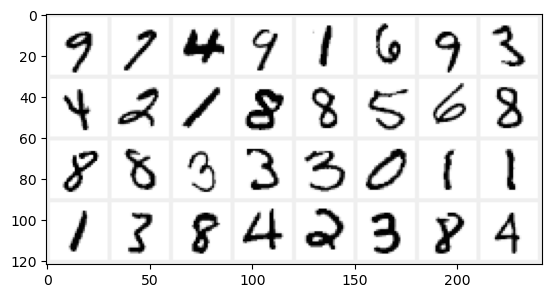

In [11]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        self.mp = nn.MaxPool2d(2,2)
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv1
        t = self.mp(F.relu(self.conv1(t)))
        
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = F.relu(self.fc1(t))

        # fc2
        t = F.relu(self.fc2(t))

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [13]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.mp = nn.MaxPool2d(2,2)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.mp(F.relu(self.conv1(t)))
        
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = F.relu(self.fc1(t))

        # fc2
        t = F.relu(self.fc2(t))

        # output expert log loss
        t = self.out(t)

        return t


In [14]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [15]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [16]:
class expert_loss_gate_optimizer:
    def __init__(self, optimizer_moe=None, optimizer_gate=None, optimizer_experts=None):
        self.optimizer_moe = optimizer_moe
        self.optimizer_gate = optimizer_gate
        self.optimizer_experts = optimizer_experts
        self.prev_epoch = 0
        self.count = 1
        
    def optimise(self, model=None, inputs=None, labels=None, outputs=None, expert_outputs=None, gate_outputs=None, 
                 loss_criterion=None, regularization=0.0, epoch=0):
        
        expert_outputs = expert_outputs.detach()
        
        # zero the parameter gradients
        if not self.optimizer_experts is None:
            self.optimizer_experts.zero_grad(set_to_none=True)                 
            expert_loss = loss_criterion(outputs=outputs, targets=labels)
            expert_loss.backward()
        else:
            print('Expert optimizer missing')

        self.optimizer_gate.zero_grad(set_to_none=True)
        gate_loss_criterion = expert_entropy_loss()
        gate_loss = gate_loss_criterion(expert_outputs=expert_outputs, gate_outputs=gate_outputs, targets=labels)
        gate_loss.backward()
        
        self.optimizer_experts.step()
        self.optimizer_gate.step()
        
        moe_loss_criterion = cross_entropy_loss()
        loss = moe_loss_criterion(outputs=outputs, targets=labels)
        
        return loss

In [17]:
from helper import moe_models
from moe_models.moe_models_base import moe_models_base

# The moe architecture that outputs an expected output of the experts
# based on the gate probabilities
class moe_expert_loss_top_1_model(moe_models_base):

    def __init__(self, num_experts=5, num_classes=10, augment=0, attention_flag=0, hidden=None, experts=None, gate=None, task='classification',device = torch.device("cpu")):
        super(moe_expert_loss_top_1_model,self).__init__(num_experts, num_classes, augment, attention_flag, hidden, experts, gate, task, device)
        self.device = device
    
    def selected_experts(self):
        return torch.argmin(self.gate_outputs, dim=1)

    def forward(self,inputs, T=1.0):

        p = self.gate(inputs, T)        
        
        y = []
        for i, expert in enumerate(self.experts):
            expert_output = expert(inputs)
            y.append(expert_output)
            
        y = torch.stack(y).transpose_(0,1).to(self.device)

        self.expert_outputs = y
        self.gate_outputs = p
        
        selected_experts = torch.argmin(p, dim=1)
        
        output = y[torch.arange(y.shape[0]).type_as(selected_experts), selected_experts]

        return output


In [18]:
from helper import moe_models
from moe_models.moe_models_base import moe_models_base

# The moe architecture that outputs an expected output of the experts
# based on the gate probabilities
class moe_expert_stochastic_model(moe_models_base):

    def __init__(self, num_experts=5, num_classes=10, augment=0, attention_flag=0, hidden=None, experts=None, gate=None, task='classification',device = torch.device("cpu")):
        super(moe_expert_stochastic_model,self).__init__(num_experts, num_classes, augment, attention_flag, hidden, experts, gate, task, device)
        self.device = device

    def forward(self,inputs, T=1.0):

        p = self.gate(inputs, T)        
        
        y = []
        for i, expert in enumerate(self.experts):
            expert_output = expert(inputs)
            y.append(expert_output)
            
        y = torch.stack(y).transpose_(0,1).to(self.device)

        self.expert_outputs = y
        self.gate_outputs = p
        
        try:
            m  = Categorical(F.softmax(p, dim=1))
            self.samples = m.sample().to(device)
        except:
            raise

        output = y[torch.arange(y.shape[0]).type_as(self.samples), self.samples]

        return output


## Functions to train models

### Function to train original model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [19]:
def train_original_model(model_1, model_name, k=0, trainloader=trainloader, testloader=testloader, runs=1, temps=[[1.0]*20],
                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                         w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20):

    moe_model_types = {'moe_top_k_model':(moe_top_k_model,cross_entropy_loss().to(device)),
                       'moe_expert_loss_top_1_model':(moe_expert_loss_top_1_model, cross_entropy_loss().to(device)),
                       'moe_expert_stochastic_model':(moe_expert_stochastic_model,cross_entropy_loss().to(device))}
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, 
                                                                                      w_sample_sim_same_range,  
                                                                                      w_sample_sim_diff_range):
        
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
 
        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {model_name:{'model':moe_model_types[model_name][0],'loss':moe_model_types[model_name][1],
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)

                gate_model = gate_layers(total_experts).to(device)
                
                if k > 0:
                    moe_model = val['model'](k, total_experts, num_classes,
                                             experts=expert_models, gate=gate_model, device=device).to(device)
                else:
                    moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model, device=device).to(device)

                optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001,  amsgrad=False)
                params = []
                for i, expert in enumerate(expert_models):
                    params.append({'params':expert.parameters()})
                optimizer_experts = optim.Adam(params, lr=0.001,  amsgrad=False)
                optimizer = expert_loss_gate_optimizer(optimizer_gate=optimizer_gate, optimizer_experts=optimizer_experts)
                
                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer = optimizer, T = T, 
                                       w_importance=w_importance, w_sample_sim_same = w_sample_sim_same, 
                                       w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            if  os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []


### Function to pre-train experts with data splits

In [20]:
# Function to pre-train experts according to the split
def train_experts(total_experts, num_classes, num_epochs, batch_size,
                  trainset, testset):
    expert_models_copy = experts(total_experts, num_classes).to(device)
    expert_models = deepcopy(expert_models_copy)
    
    train_splits = random_split(trainset, [int(trainsize/total_experts)]*total_experts,generator=torch.Generator().manual_seed(42))
    
    for i, expert in enumerate(expert_models):
        
        trainloader = torch.utils.data.DataLoader(train_splits[i], 
                                          batch_size=batch_size,
                                          shuffle=True)
        
        optimizer_expert = optim.Adam(expert.parameters(), lr=0.001, amsgrad=False)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, None, None,labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1
                
            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )
    pre_trained_expert = 'mnist_pre_trained_splits'
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    torch.save([expert_models, expert_models_copy],open(os.path.join(model_path, plot_file),'wb'))
    return expert_models, expert_models_copy

## Experiments

In [ ]:
# Pre-train experts on pre-defined splits
expert_models, expert_models_copy = train_experts(total_experts=total_experts, num_classes=num_classes, 
                                                  num_epochs=num_epochs, batch_size=batch_size, 
                                                  trainset=trainset,testset=testset)

In [51]:
def train_with_pretrained_experts(m, model_type, pre_trained_expert,
                                 total_experts, num_classes, num_epochs):
    
    # Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
    T = [1.0]*20
    #re_trained_expert = 'mnist_pre_trained_10K'
    n_split_models_1 = []

    model_types = {
                'moe_expert_stochastic_model': {
                    'moe_expert_stochastic_model':{'model':moe_expert_stochastic_model,'loss':stochastic_loss(cross_entropy_loss).to(device),'experts':{}},
                },
                'moe_expert_expectation_model': {
                    'moe_expert_expectation_model':{'model':moe_expert_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
                }
    }

    models = model_types[model_type]
    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file), map_location=device)

    for i, expert in enumerate(expert_models):
        for param in expert.parameters():
            param.requires_grad = False

    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts)

        moe_model = val['model'](total_experts, num_classes, 
                                 experts=expert_models, gate=gate_model, device=device)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001,  amsgrad=False)
        params = []
        for i, expert in enumerate(expert_models):
            params.append({'params':expert.parameters()})
        optimizer_experts = optim.Adam(params, lr=0.001,  amsgrad=False)
        optimizer = expert_loss_gate_optimizer(optimizer_gate=optimizer_gate)

        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer=optimizer, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_1.append(models)
    torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_1 = []

### Experiment 1: Original MoE model trained without gate regularization

In [26]:
total_experts = 10

In [27]:
num_epochs = 20

In [28]:
runs = 1

In [29]:
temps = [[1]*num_epochs]

In [30]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_top_1_loss_gate'
train_original_model(model_1, 'moe_top_k_model', 1, trainloader, testloader, runs, temps=temps, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.98 , training accuracy 0.29 , test accuracy 0.62
epoch 1 training loss 0.87 , training accuracy 0.73 , test accuracy 0.78
epoch 2 training loss 0.64 , training accuracy 0.80 , test accuracy 0.81
epoch 3 training loss 0.60 , training accuracy 0.81 , test accuracy 0.83
epoch 4 training loss 0.57 , training accuracy 0.82 , test accuracy 0.83
epoch 5 training loss 0.55 , training accuracy 0.83 , test accuracy 0.84
epoch 6 training loss 0.53 , training accuracy 0.84 , test accuracy 0.84
epoch 7 training loss 0.52 , training accuracy 0.84 , test accuracy 0.84
epoch 8 training loss 0.51 , training accuracy 0.84 , test accuracy 0.85
epoch 9 training loss 0.50 , training accuracy 0.84 , test accuracy 0.85
epoch 10 training loss 0.49 , training accuracy 0.85 , test accuracy 0.85
epoch 11 training loss 0.48 , training accuracy 0.85 , test accuracy 0.85
epoch 12 training loss 0.47 , training accuracy 0.85 ,

KeyboardInterrupt: 

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_stochastic_loss_gate'
train_original_model(model_1, 'moe_expert_stochastic_model', trainloader, testloader, runs, temps=temps, 
                    num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [56]:
m = 'mnist_pretrained_experts_stochastic'
model_type = 'moe_expert_stochastic_model'
pre_trained_expert = 'mnist_pre_trained'
train_with_pretrained_experts(m, model_type, pre_trained_expert, total_experts,
                              num_classes, num_epochs)

mnist_pre_trained_10_5_expert_model.pt
Model: moe_expert_stochastic_model 5 Experts
Building model with pre-trained experts
model params: 26063
epoch 0 training loss 5.86 , training accuracy 0.19 , test accuracy 0.20
epoch 1 training loss 3.88 , training accuracy 0.34 , test accuracy 0.48
epoch 2 training loss 2.59 , training accuracy 0.57 , test accuracy 0.64
epoch 3 training loss 1.80 , training accuracy 0.71 , test accuracy 0.75
epoch 4 training loss 1.40 , training accuracy 0.78 , test accuracy 0.80
epoch 5 training loss 1.20 , training accuracy 0.81 , test accuracy 0.83
epoch 6 training loss 1.08 , training accuracy 0.83 , test accuracy 0.84
epoch 7 training loss 1.00 , training accuracy 0.84 , test accuracy 0.85
epoch 8 training loss 0.93 , training accuracy 0.85 , test accuracy 0.86
epoch 9 training loss 0.87 , training accuracy 0.86 , test accuracy 0.86
epoch 10 training loss 0.83 , training accuracy 0.87 , test accuracy 0.87
epoch 11 training loss 0.80 , training accuracy 0.87

In [70]:
total_experts = 5

In [71]:
num_epochs = 20

In [72]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = [0.4]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.4']


In [73]:
runs = 1

In [74]:
train_original_model(model_2, 'moe_expert_expectation_model', trainloader, testloader, runs, w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.4
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 12.57 , training accuracy 0.37 , test accuracy 0.72
epoch 1 training loss 7.85 , training accuracy 0.76 , test accuracy 0.84
epoch 2 training loss 6.24 , training accuracy 0.85 , test accuracy 0.85
epoch 3 training loss 5.71 , training accuracy 0.86 , test accuracy 0.86
epoch 4 training loss 5.45 , training accuracy 0.85 , test accuracy 0.88
epoch 5 training loss 5.26 , training accuracy 0.82 , test accuracy 0.79
epoch 6 training loss 5.15 , training accuracy 0.79 , test accuracy 0.81
epoch 7 training loss 5.08 , training accuracy 0.83 , test accuracy 0.85
epoch 8 training loss 5.00 , training accuracy 0.79 , test accuracy 0.76
epoch 9 training loss 4.95 , training accuracy 0.83 , test accuracy 0.85
epoch 10 training loss 4.90 , training accuracy 0.82 , test accuracy 0.90
epoch 11 training loss 4.87 , training accuracy 0.89 , test accuracy 0.87
epoch 12 training loss 4.83 , training accuracy 0.82 

In [ ]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_with_reg_hidden_32'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

In [ ]:
runs = 10

In [ ]:
train_original_model(model_3, trainloader, testloader, runs, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [ ]:
model_4 = 'mnist_single_model_hidden_32'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, trainloader, testloader, num_classes, num_epochs, runs)

## Results

### Collect the train error, test error for the trained single models and store in the '../results/mnist_results.csv' file.

In [21]:
total_experts = 10
num_classes = 10
num_epochs = 20

In [22]:
import sys
sys.path.append('../src/mnist')

In [23]:
results_file = 'mnist_top_k_results.csv'

In [24]:
import csv
from helper import moe_models
from scipy.stats import entropy


def collect_results(m, model_type='moe_expectation_model', temps=[1.0], w_importance_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename = results_file):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                # model
                model = mod[model_type]['experts'][total_experts]['model']
                # history
                history = mod[model_type]['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                running_top1_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    expert_outputs = model.expert_outputs
                    gate_outputs = F.softmax(model.gate_outputs, dim=1)
                    running_top1_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += np.mean(entropy(gate_outputs.detach().cpu().numpy()))
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                top1_error = 1-(running_top1_accuracy/num_batches)
                
                data.append(top1_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)  
                gate_probabilities_sum = torch.mean(gate_outputs, dim=0).detach().cpu().numpy()   
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

In [34]:
m = 'mnist_without_reg_stochastic_loss_gate'
model_type = 'moe_expert_stochastic_model'
collect_results(m, model_type = model_type, T_scheds=[0], total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [25]:
m = 'mnist_without_reg_loss_gate'
model_type = 'moe_expert_loss_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=results_file)

device cuda:0
Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [68]:
m = 'mnist_without_reg_expectation'
model_type = 'moe_expert_expectation_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [69]:
m = 'mnist_pretrained_experts_stochastic'
model_type = 'moe_expert_stochastic_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [70]:
m = 'mnist_pretrained_experts_expectation'
model_type = 'moe_expert_expectation_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [71]:
m = 'mnist_pretrained_splits_experts_stochastic'
model_type = 'moe_expert_stochastic_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [72]:
m = 'mnist_pretrained_splits_experts_expectation'
model_type = 'moe_expert_expectation_model'
collect_results(m, model_type = model_type, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [27]:
import pandas as pd
filename = os.path.join(results_path, 'mnist_top_k_results.csv')
data = pd.read_csv(filename)

In [28]:
final_results_filename = os.path.join(results_path, 'mnist_top_k_final_results.csv')

In [29]:
models = ['mnist_single_model', 'mnist_without_reg_hidden_32', 'mnist_with_reg_hidden_32_importance', 
          'mnist_with_reg_hidden_32_sample', 'mnist_with_attn_reg_hidden_32_importance',
          'mnist_with_attn_sample_sim_reg_hidden_32_sample', 'new_mnist_with_attn_reg_hidden_32_importance',
          'new_mnist_with_attn_sample_sim_reg_hidden_32_sample',
          'mnist_without_reg_top_1_loss_gate', 'mnist_pretrained_splits_experts_stochastic']
models = ['mnist_without_reg_top_'+str(k)+'_' for k in range(1,total_experts+1)]+['mnist_without_reg_loss_gate_top_1']
print(models)
header = True
df = None
# std = ['{:.3f}'.format(std_val) for std_val in data.groupby('filename')['test error'].std().values]
data = data.groupby('filename').mean().reset_index()
# data['val error std'] = std
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    series = model_data.mean(numeric_only=True)
    row = pd.DataFrame([series.values], columns=series.index)
    row.insert(0, 'filename' , model_data['filename'].iloc[0])
    if df is None:
        df = row
    else:
        df = pd.concat([df, row])
header = ['filename', 'train error', 'test error', 'mutual information', 'sample entropy', 'experts usage']
    
df.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

['mnist_without_reg_top_1_', 'mnist_without_reg_top_2_', 'mnist_without_reg_top_3_', 'mnist_without_reg_top_4_', 'mnist_without_reg_top_5_', 'mnist_without_reg_top_6_', 'mnist_without_reg_top_7_', 'mnist_without_reg_top_8_', 'mnist_without_reg_top_9_', 'mnist_without_reg_top_10_', 'mnist_without_reg_loss_gate_top_1']


In [46]:
models = ['mnist_single_model', 'mnist_without_reg_hidden_32', 'mnist_with_reg_hidden_32_importance', 
          'mnist_with_reg_hidden_32_sample', 'mnist_with_attn_reg_hidden_32_importance',
          'mnist_with_attn_sample_sim_reg_hidden_32_sample', 'new_mnist_with_attn_reg_hidden_32_importance',
          'new_mnist_with_attn_sample_sim_reg_hidden_32_sample',
           'mnist_without_reg_top_1_loss_gate', 'mnist_without_reg_stochastic_loss_gate']
header = True
for i, m in enumerate(models):
    if i:
        header = False
    # select model with the minimum train error
    row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
    # compute the std of test error over the 10 runs
    std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    row['val error std'] = std
    row.to_csv(final_results_filename, mode='a', header=header, index=False, float_format='%.3f')

In [30]:
# display final results with mean
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

filename  train error  \
0             mnist_without_reg_top_1_10_10_models.pt        0.044   
1             mnist_without_reg_top_2_10_10_models.pt        0.072   
2             mnist_without_reg_top_3_10_10_models.pt        0.050   
3             mnist_without_reg_top_4_10_10_models.pt        0.047   
4             mnist_without_reg_top_5_10_10_models.pt        0.043   
5             mnist_without_reg_top_6_10_10_models.pt        0.040   
6             mnist_without_reg_top_7_10_10_models.pt        0.045   
7             mnist_without_reg_top_8_10_10_models.pt        0.041   
8             mnist_without_reg_top_9_10_10_models.pt        0.043   
9            mnist_without_reg_top_10_10_10_models.pt        0.031   
10  mnist_without_reg_loss_gate_top_1_10_10_models.pt        0.107   

    test error  mutual information  sample entropy  experts usage  
0        0.053               1.414           0.057          1.657  
1        0.077               0.602           0.114          0.814  
2        0.055               0.985           0.154          1.269  
3        0.055               1.108           0.139          1.372  
4        0.053               1.131           0.170          1.509  
5        0.049               1.234           0.152          1.563  
6        0.054               1.111           0.215          1.523  
7        0.051               1.230           0.269          1.760  
8        0.050               1.339           0.154          1.639  
9        0.042               1.700           0.169          2.033  
10       0.106               0.106           9.061          1.809

In [24]:
# display final results with min train error
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

filename  train error  \
0                      mnist_single_model_hidden_32_5        0.097   
1          mnist_without_reg_hidden_32_10_5_models.pt        0.021   
2   mnist_with_reg_hidden_32_importance_0.2_10_5_m...        0.015   
3   mnist_with_reg_hidden_32_sample_sim_same_1e-06...        0.015   
4   mnist_with_attn_reg_hidden_32_importance_0.2_1...        0.013   
5   mnist_with_attn_sample_sim_reg_hidden_32_sampl...        0.013   
6   new_mnist_with_attn_reg_hidden_32_importance_0...        0.009   
7   new_mnist_with_attn_sample_sim_reg_hidden_32_s...        0.009   
8   mnist_without_reg_stochastic_T_sched_3_10_5_mo...        0.052   
9   mnist_without_reg_stochastic_t_update_T_sched_...        0.065   
10  mnist_without_reg_stochastic_t_decay_T_sched_3...        0.073   

    test error mutual information sample entropy expert usage  val error std  
0        0.096                 NA             NA           NA          0.071  
1        0.038              2.022          0.092        2.172          0.030  
2        0.032              2.262          0.061         2.32          0.008  
3        0.029              2.244          0.051        2.246          0.009  
4        0.035               2.26          0.055        2.266          0.005  
5        0.032              2.275          0.039        2.321          0.006  
6        0.030              2.301          0.036         2.32          0.006  
7        0.028              2.191          0.056        2.319          0.007  
8        0.064              0.505          0.185          0.0          0.005  
9        0.074              0.404          0.052          0.0          0.005  
10       0.081              0.417          0.158          0.0          0.000

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
def show_results(m, model_type):
    classes = range(num_classes)
    test_loader = testloader

    # plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    # mod = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    
    mod, model_file = find_best_model(m, w_importance_range=[0.0], num_classes=num_classes, total_experts=total_experts, 
                                        num_epochs=num_epochs, model_path=model_path, device=device)
    
    # model
    model = mod[model_type]['experts'][total_experts]['model']
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
        outputs = model(test_inputs)
        
        print('test error', 1-accuracy(outputs,test_labels))
        expert_outputs = model.expert_outputs
        gate_outputs = model.gate_outputs
        
        expected_expert_outputs = expert_outputs[torch.arange(expert_outputs.shape[0]).type_as(test_labels),:, test_labels]
        eps=1e-15
        e_logp =torch.log(expected_expert_outputs+eps)
        print('expert log loss:\n', e_logp[0:5])
        print('expert log loss predicted by gate:\n', gate_outputs[0:5])
        
        selected_experts = torch.argmax(gate_outputs, dim=1)
        
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(test_labels, selected_experts):
            class_expert_table[expert,label] += 1

        fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(24, 15))
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    xticklabels=[classes[i] for i in range(0, num_classes)],
                    annot=True, cmap=cmap, fmt='d', ax=ax)

        plt.title('Experts selected per digit for '+str(len(test_loader))+' samples of\n MNIST test data', 
                  fontsize=12)
        
        pred_labels = torch.argmax(outputs, dim=1)
        fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 8))
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        sns.heatmap(confusion_matrix(test_labels.cpu(), pred_labels.cpu()), 
                    xticklabels=[classes[i] for i in range(0, num_classes)],
                    yticklabels=[classes[i] for i in range(0, num_classes)], 
                    annot=True, cmap=cmap, fmt='d', ax=ax)
        plt.title('Moe predictions')
        plt.show()


        exp_class_prob = torch.zeros(total_experts, num_classes).to(device)

        for e in range(total_experts):
            for index, l in enumerate(test_labels):
                exp_class_prob[e,l] += gate_outputs[index,e]


        exp_total_prob = torch.sum(exp_class_prob, dim=1).view(-1,1).to(device)
        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16,8))

        sns.heatmap(exp_class_prob.detach().cpu().numpy(), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            cmap=cmap, annot=True,  ax=ax)
        plt.title('Experts selected per digit for '+str(len(test_loader))+' samples of\n MNIST test data', 
                  fontsize=12)

        for i in range(total_experts):
            expert_output = expert_outputs[torch.arange(expert_outputs.shape[0]),i]
            pred_labels = torch.argmax(expert_output, dim=1)
            # print(test_labels[0:100])
            # print(pred_labels[0:100])
            fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 8))
            cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
            sns.heatmap(confusion_matrix(test_labels.cpu(), pred_labels.cpu()), 
                        xticklabels=[classes[i] for i in range(0, num_classes)],
                        yticklabels=[classes[i] for i in range(0, num_classes)], 
                        annot=True, cmap=cmap, fmt='d', ax=ax)
            plt.title('Expert %d predictions'%(i+1))
            plt.show()


mnist_without_reg_loss_gate_top_1_10_10_models.pt
Min Training Error 0.063
Mutual Information 1.126
Sample Entropy 0.328
Expert Usage 0.000
test error tensor(0.0702, device='cuda:0')
expert log loss:
 tensor([[-1.1013e-02, -6.8416e+00, -1.1211e+01, -2.5747e-04, -1.6085e-01,
         -3.2867e+00, -5.5187e+00, -2.5102e-03, -9.2382e-04, -6.9568e-03],
        [-1.2816e-04, -1.1032e-01, -9.6721e+00, -1.2040e-05, -4.6592e-03,
         -1.0611e-01, -2.8443e-03, -1.4388e+01, -1.7069e+00, -1.2509e+01],
        [-1.4700e-02, -6.0922e+00, -1.2377e+01, -3.2627e+00, -1.7514e-02,
         -2.4180e+00, -2.9425e-03, -3.8818e+00, -8.7334e+00, -7.9663e+00],
        [-1.0357e+01, -7.3047e+00, -1.5110e+01, -1.2050e+01, -3.4844e+00,
         -4.7803e-02, -8.1721e+00, -3.8386e-05, -2.3044e-02, -2.1407e-01],
        [-2.9697e-02, -6.6769e+00, -7.0921e+00, -1.3106e+01, -1.6143e-02,
         -6.3443e-01, -9.4186e+00, -4.8347e+00, -7.1675e+00, -3.4161e+00]],
       device='cuda:0', grad_fn=<SliceBackward0>)
exp

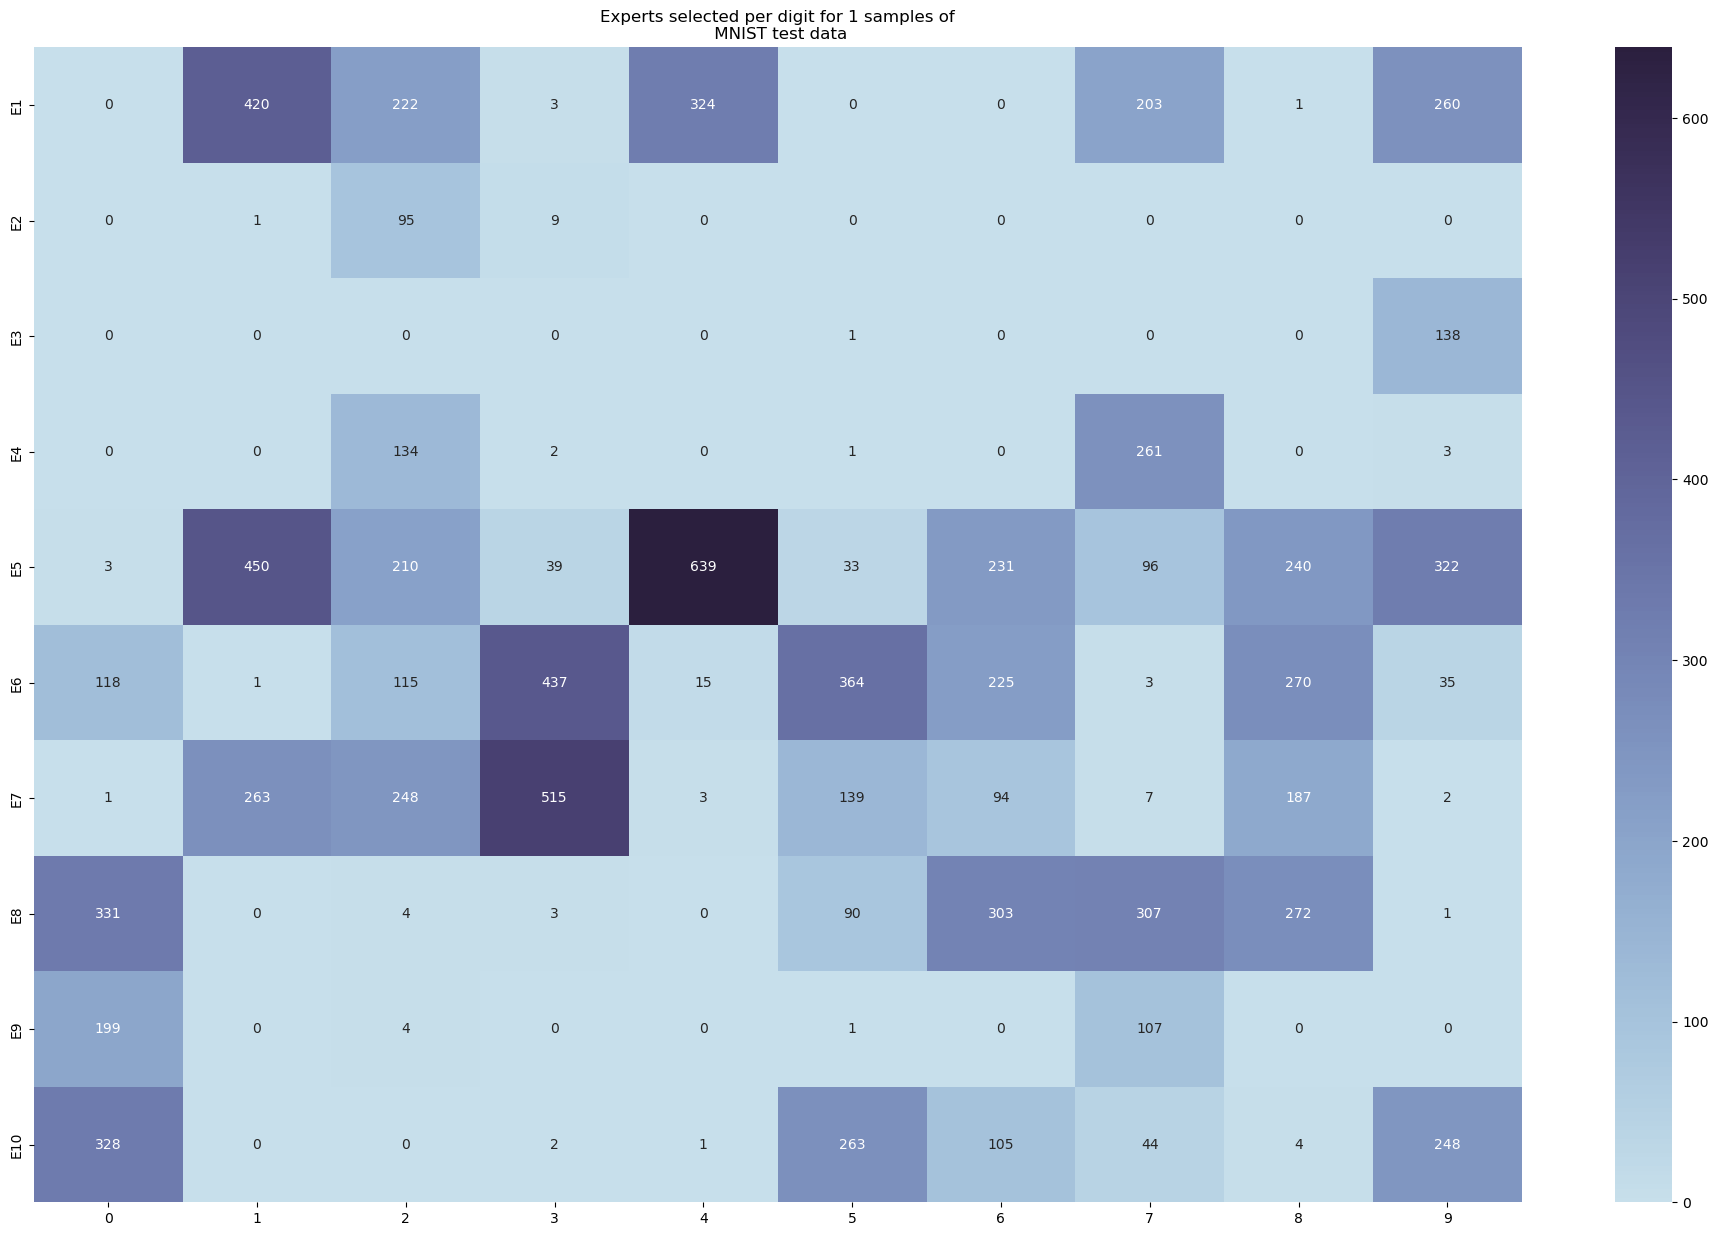

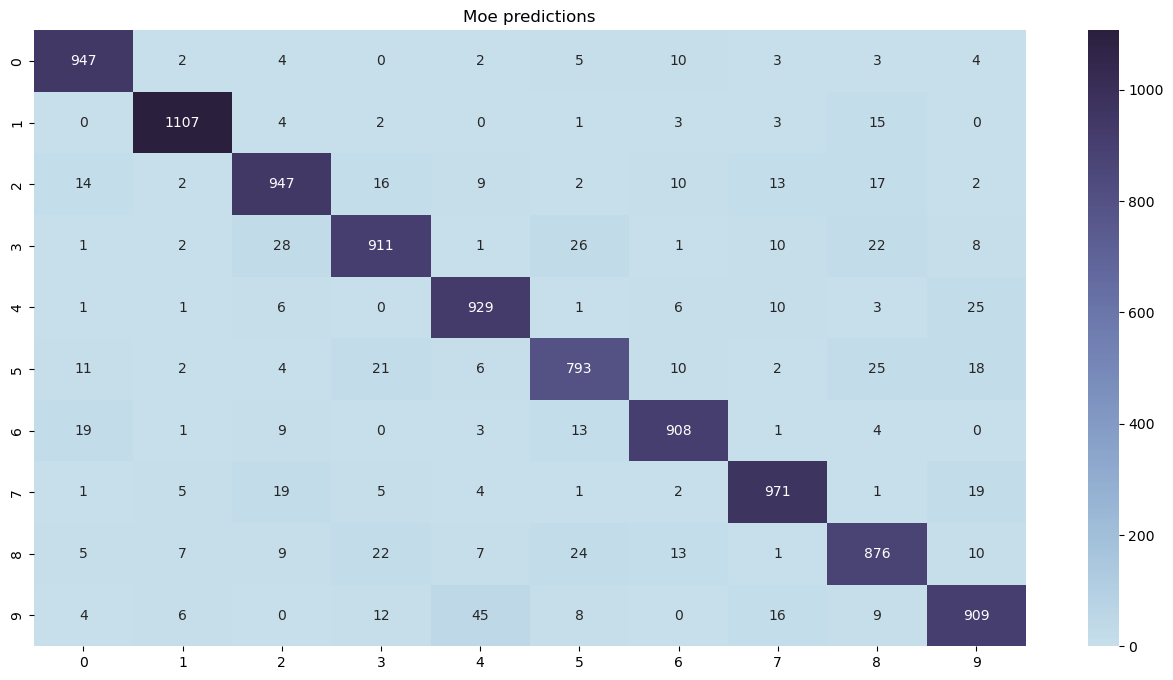

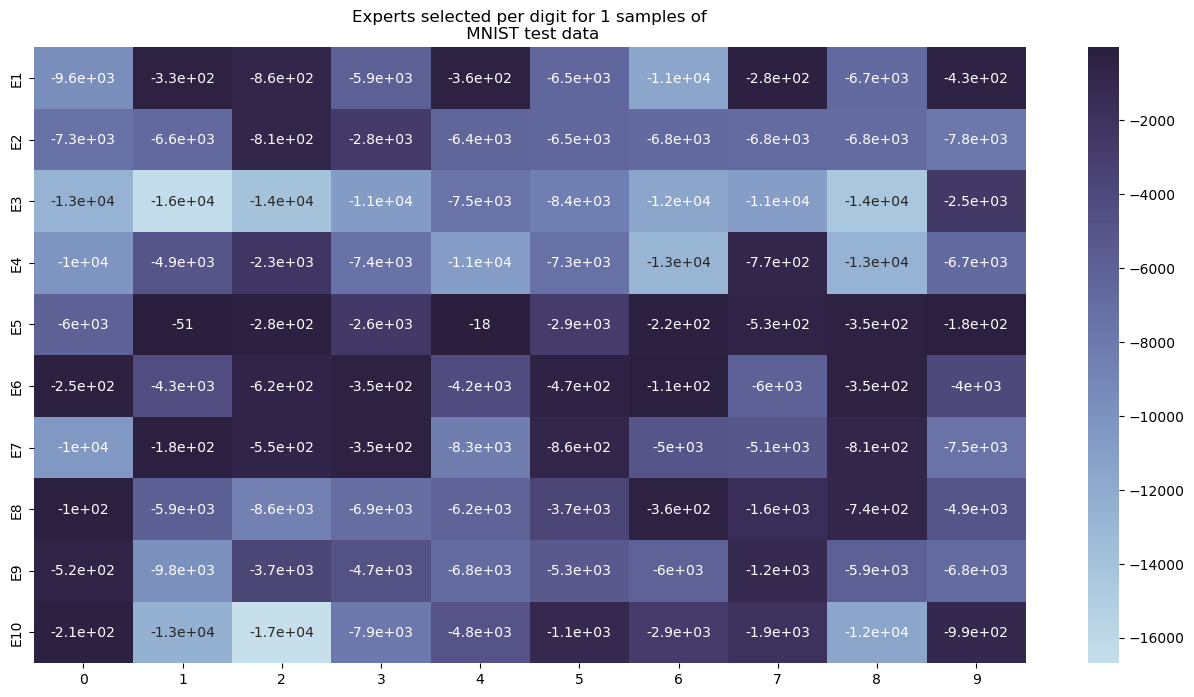

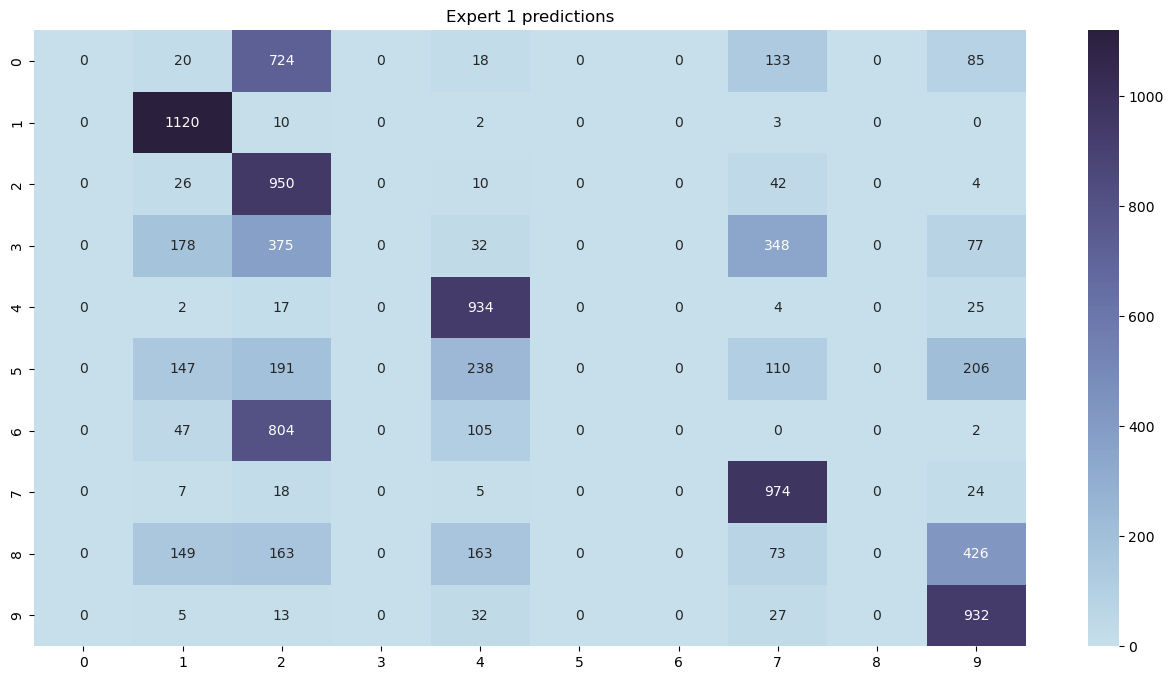

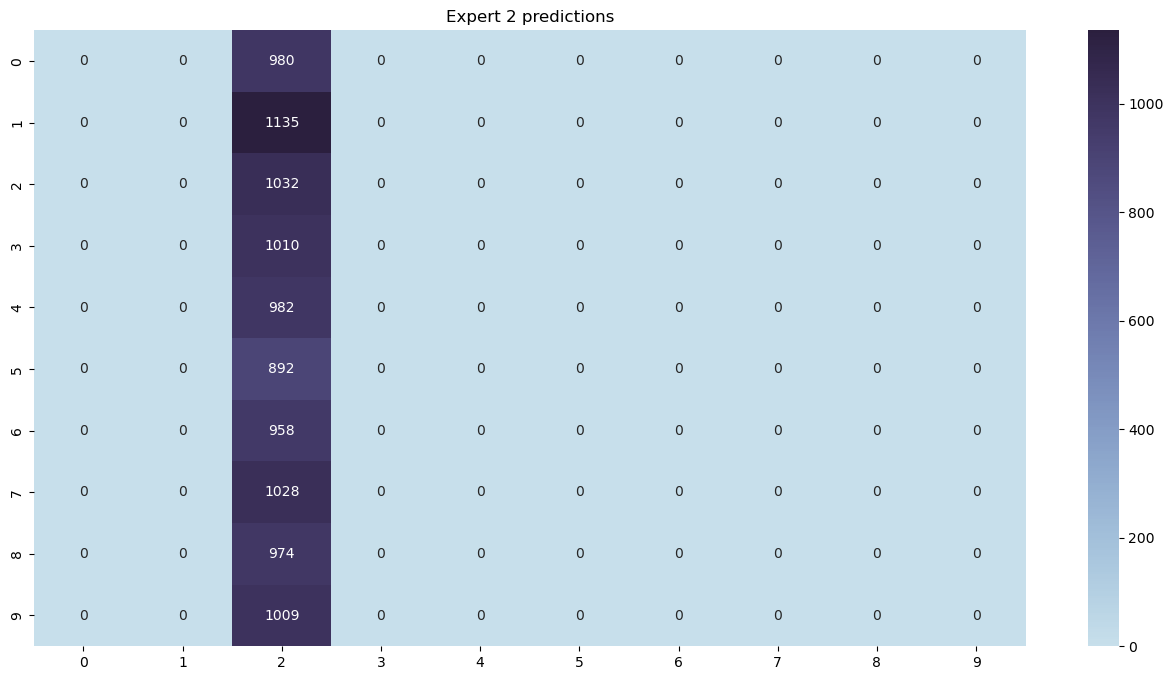

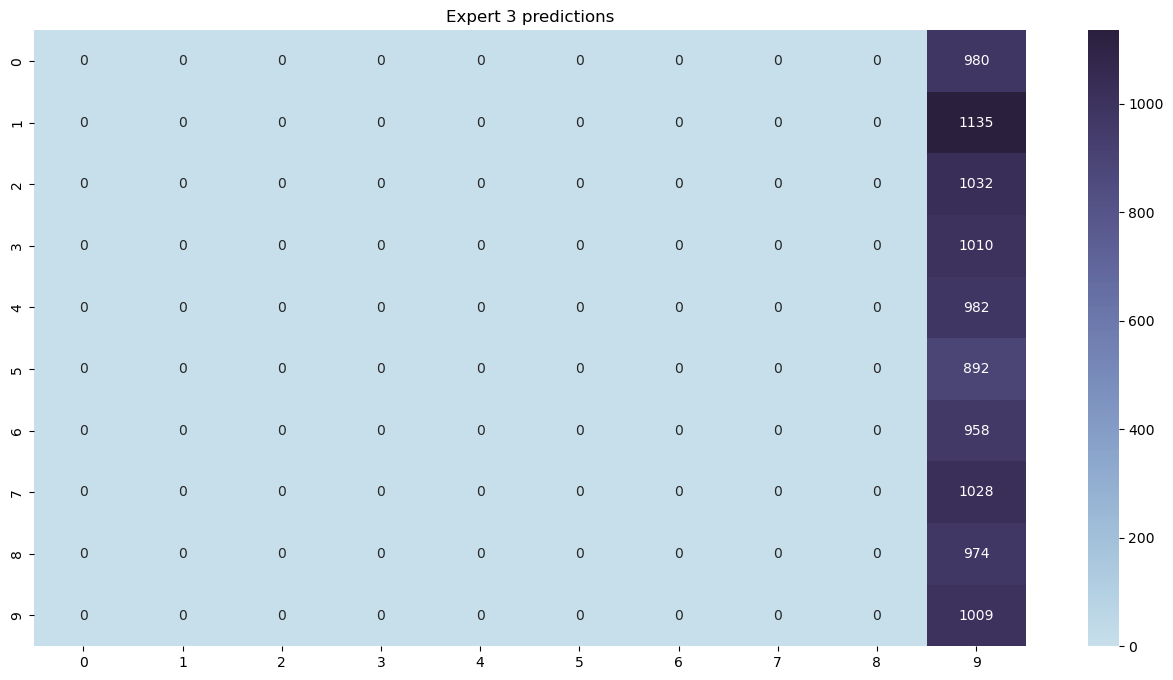

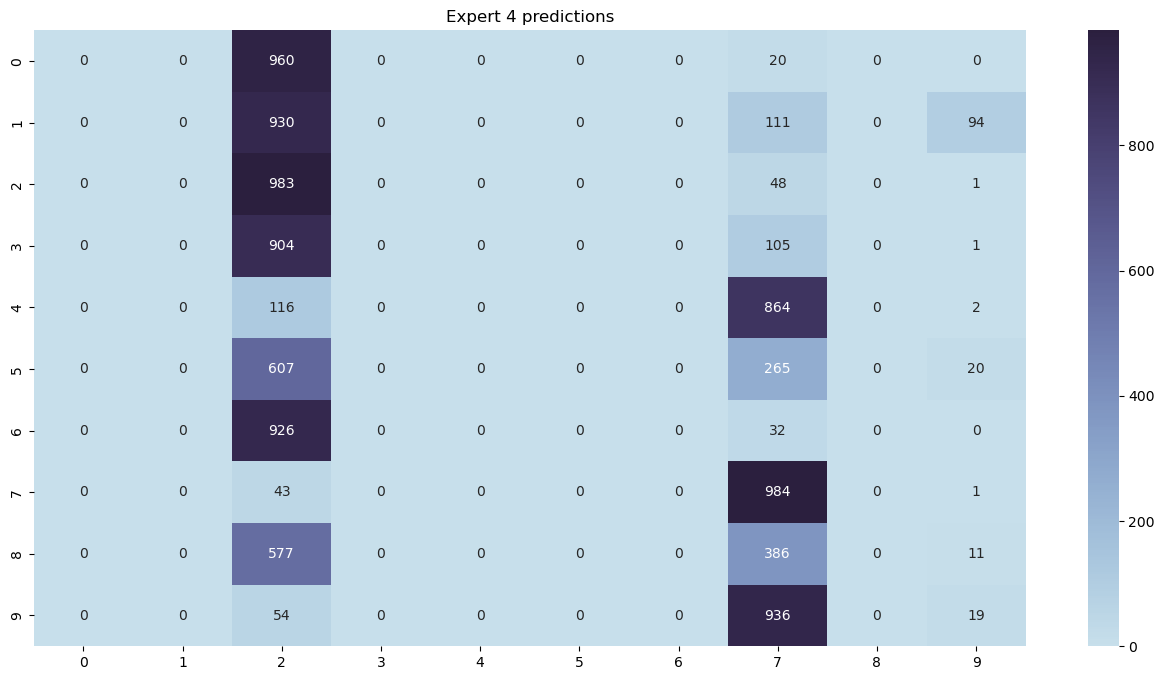

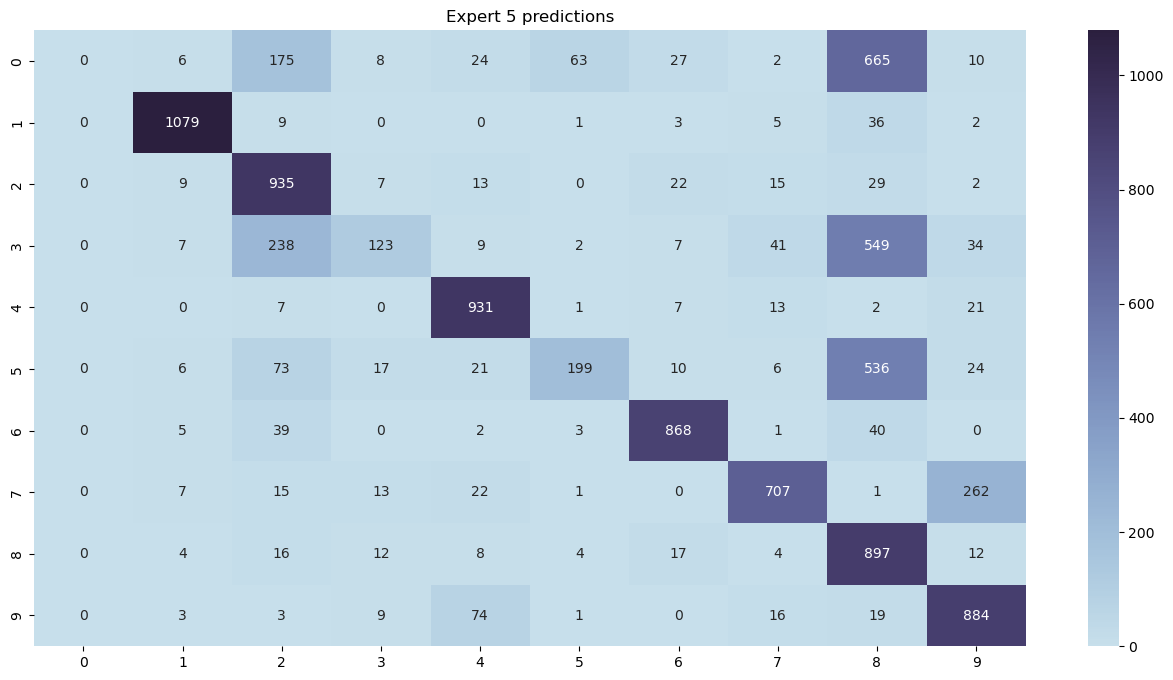

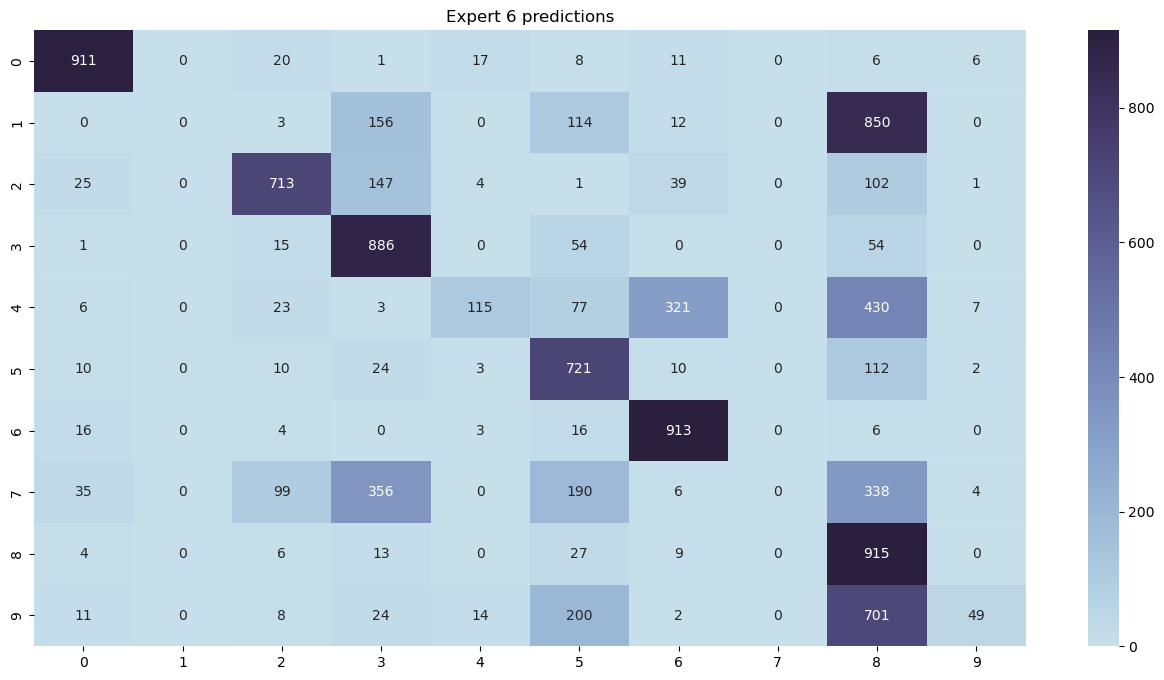

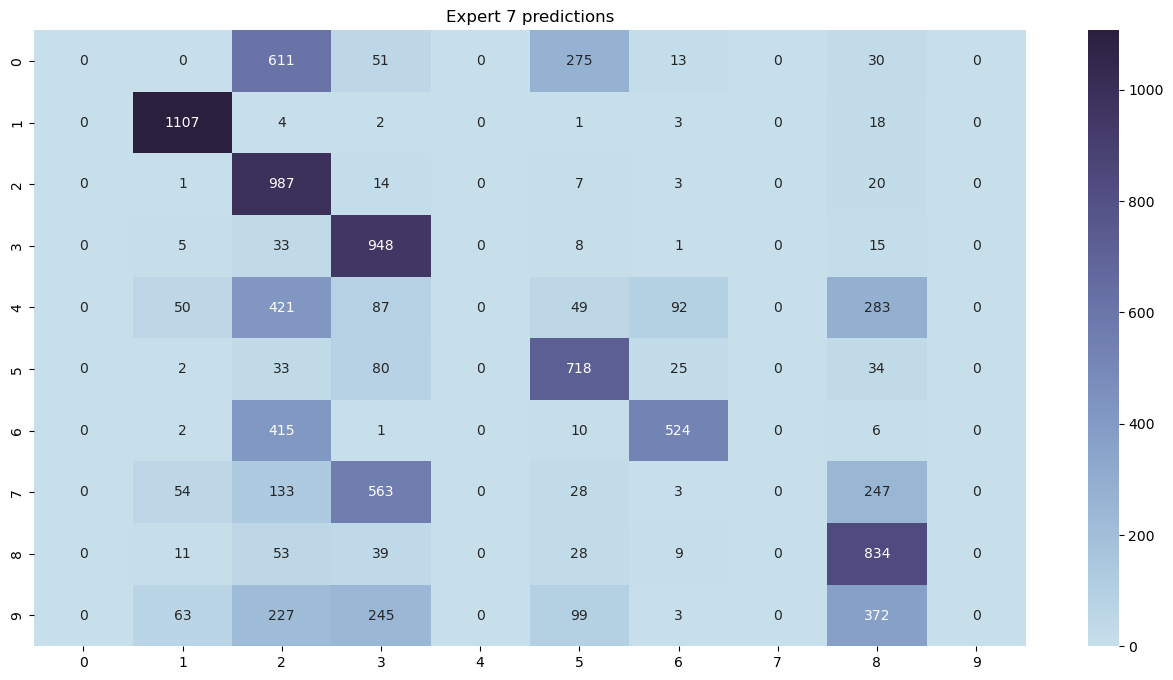

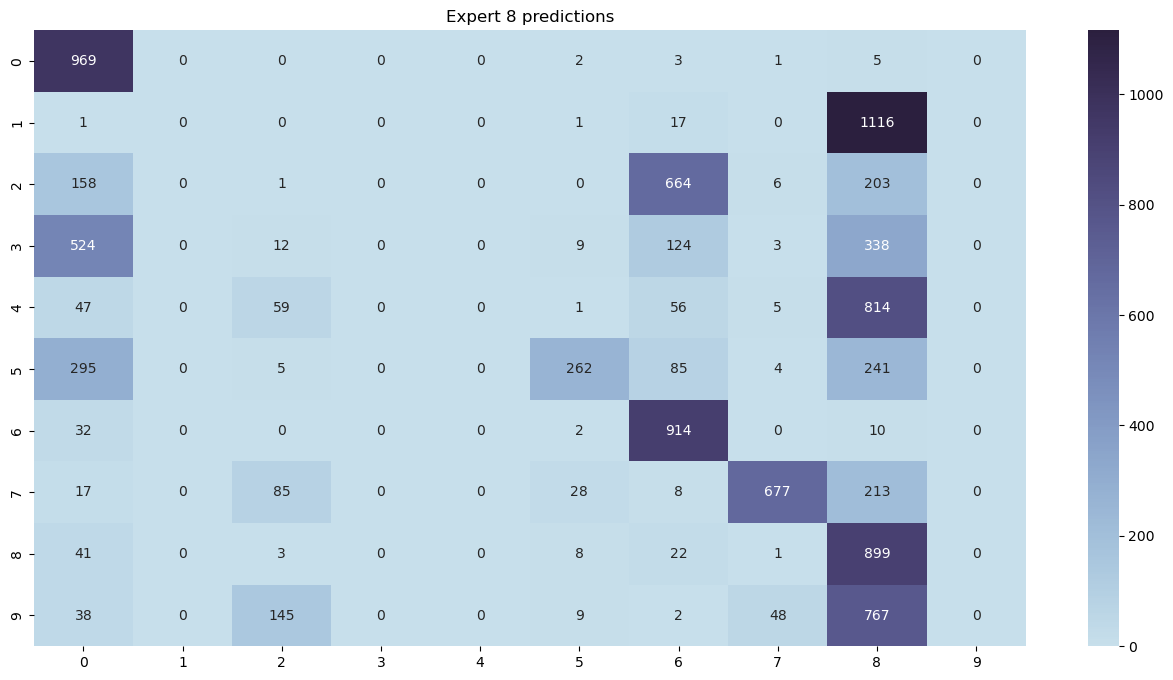

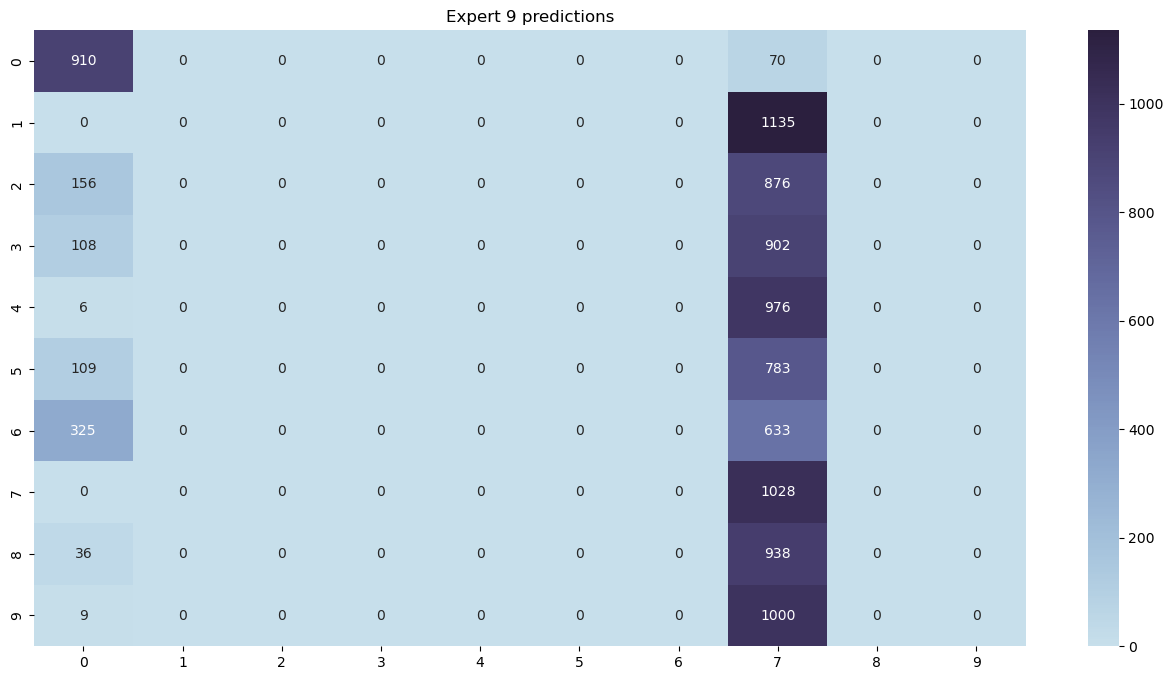

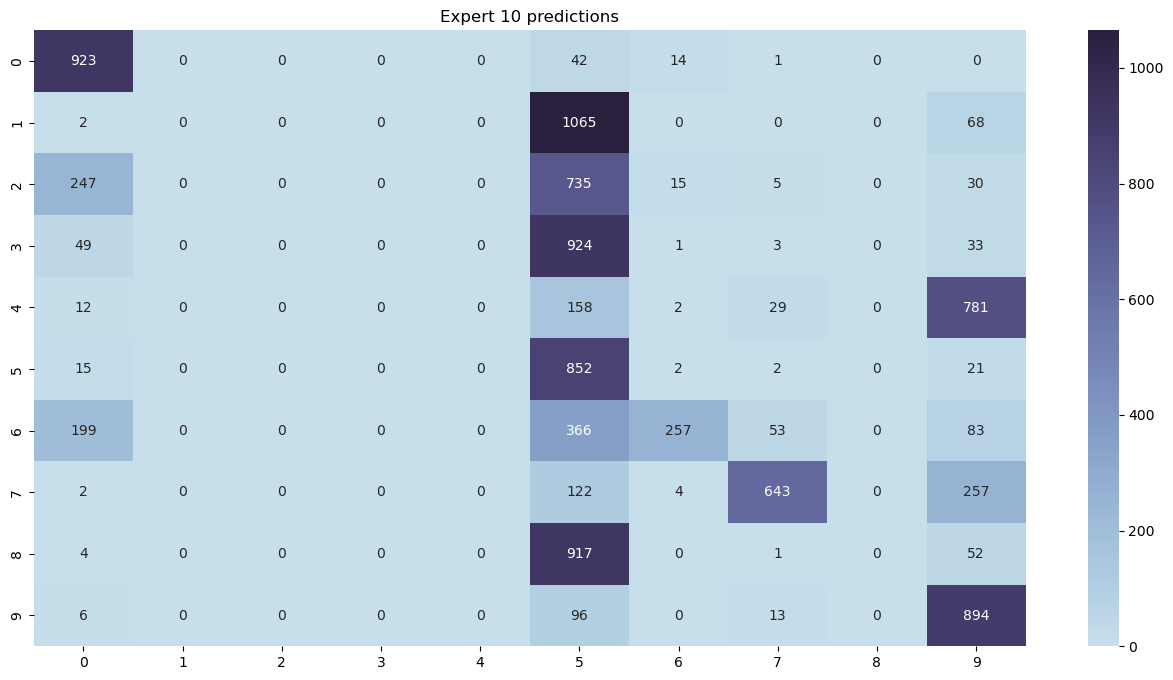

In [47]:
m = 'mnist_without_reg_loss_gate_top_1'
model_type = 'moe_top_k_model'

show_results(m, model_type)

T_sched 1
test error tensor(0.0806, device='cuda:0')
expert log loss:
 tensor([[-6.4312e+00, -1.1341e-02, -7.8847e+00, -7.3816e+00, -8.9667e-03],
        [-1.3648e-02, -5.4356e-04, -2.1577e-05, -3.4883e+00, -4.7453e-01],
        [-3.1970e+00, -1.0641e-03, -5.0145e+00, -1.1437e-02, -1.1779e+00],
        [-9.1533e+00, -3.0626e+01, -1.7646e+01, -8.3644e+00, -5.0229e-03],
        [-1.0396e+01, -1.1235e+01, -2.2767e+01, -4.8610e+00, -1.7803e-02]],
       device='cuda:0', grad_fn=<SliceBackward0>)
expert log loss predicted by gate:
 tensor([[-6.3208e+00, -3.2135e-02, -7.0682e+00, -7.0635e+00, -5.2579e-03],
        [ 4.5241e-01,  1.3469e+00,  1.7569e-01, -4.3303e+00, -2.2594e-01],
        [-3.7455e+00,  2.5994e-01, -5.0963e+00, -3.7733e-02, -1.2712e+00],
        [-9.9015e+00, -3.0757e+01, -1.7172e+01, -7.9817e+00, -6.8836e-02],
        [-1.0807e+01, -1.1597e+01, -2.0860e+01, -5.7198e+00, -4.6372e-02]],
       device='cuda:0', grad_fn=<SliceBackward0>)


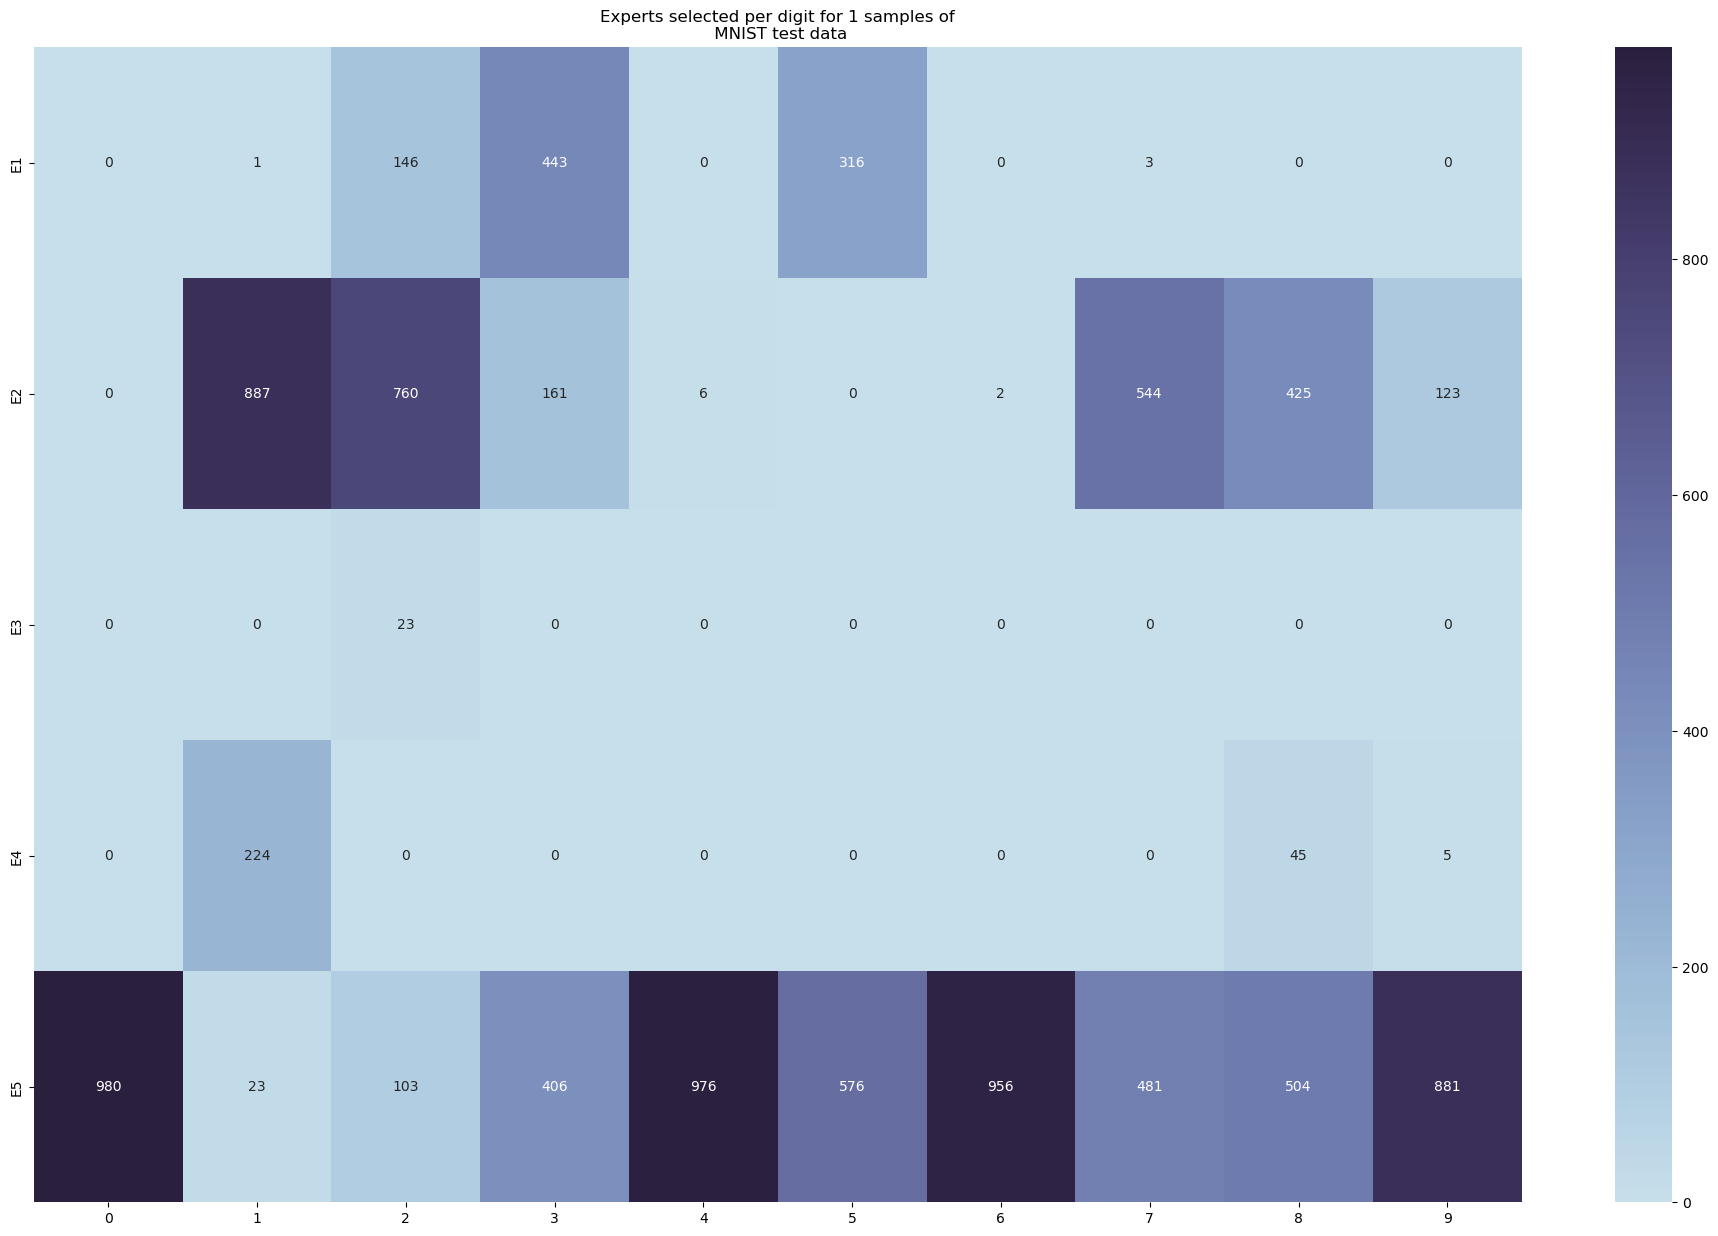

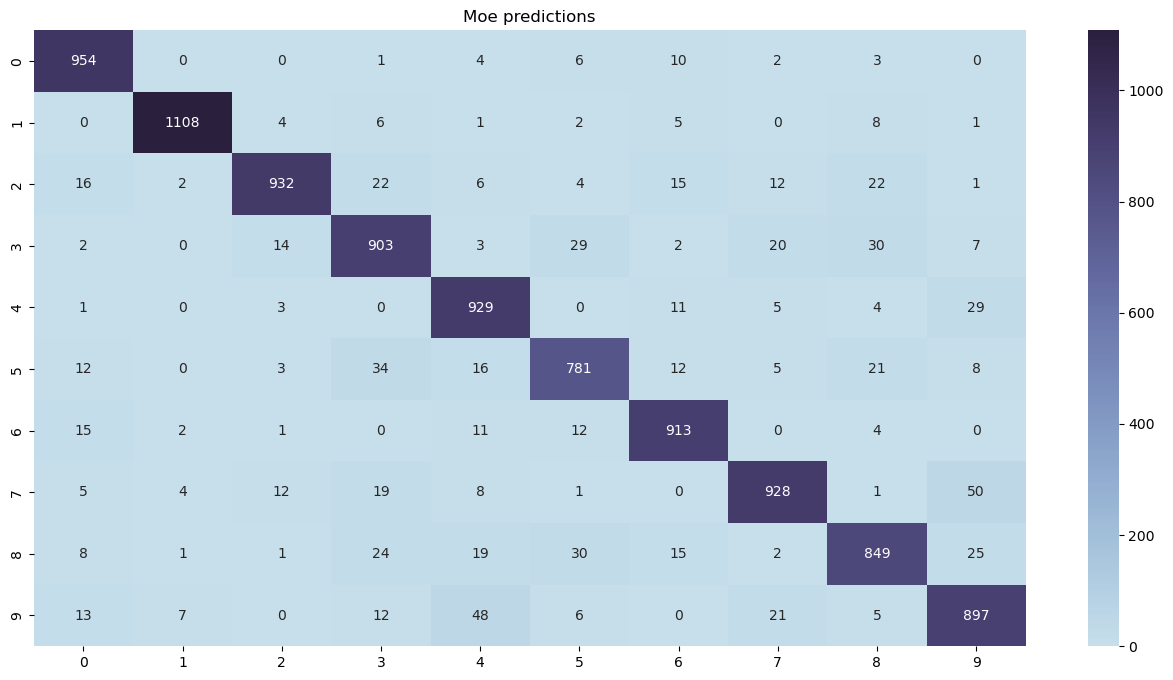

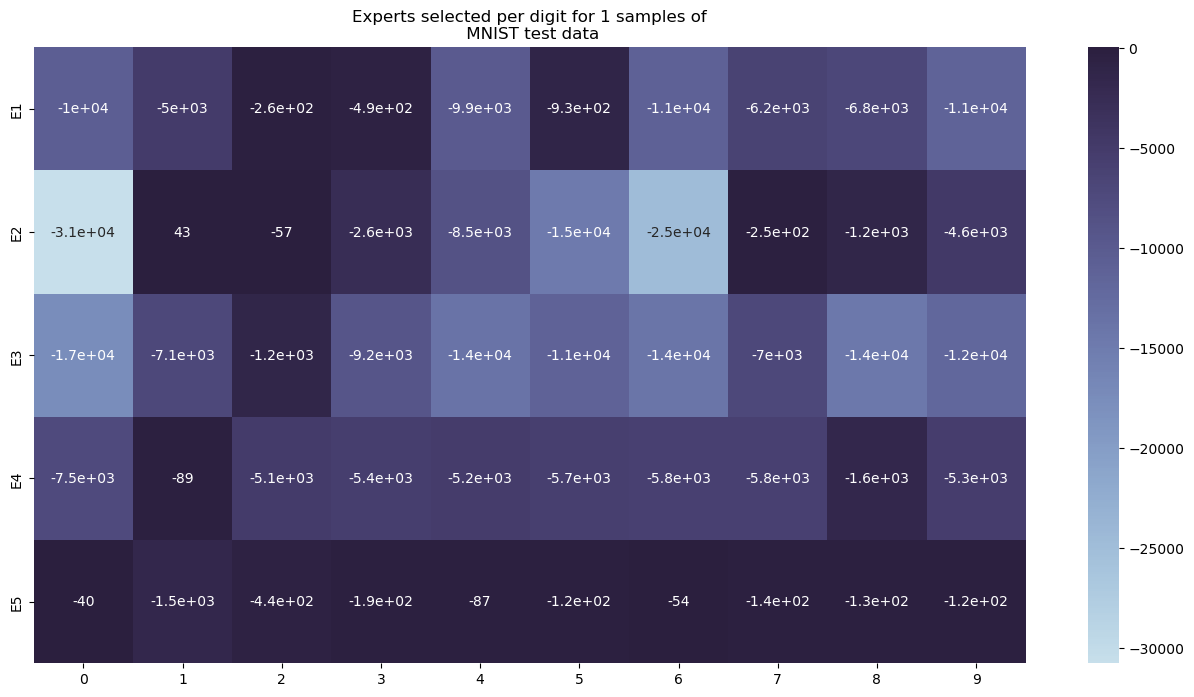

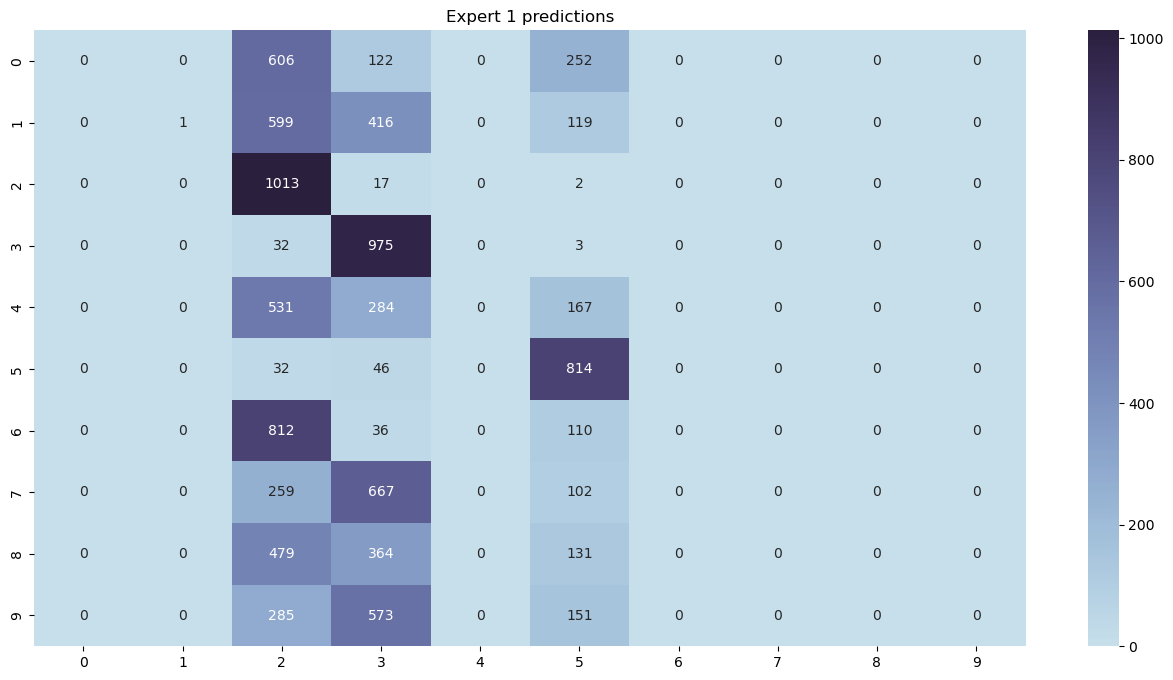

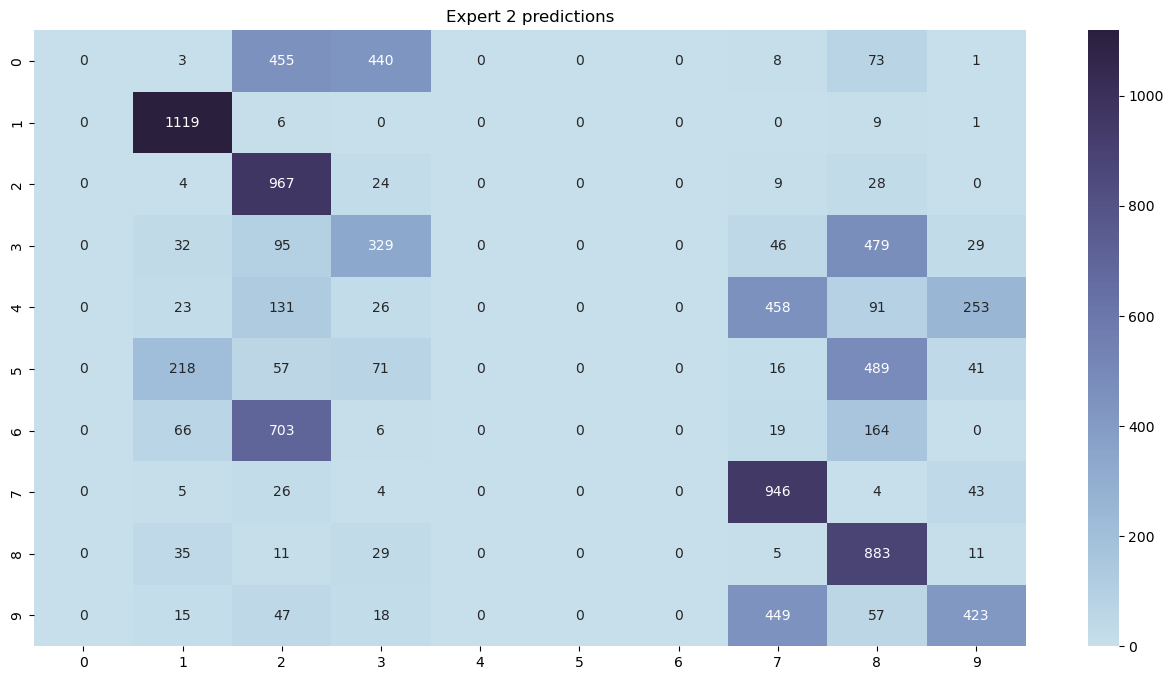

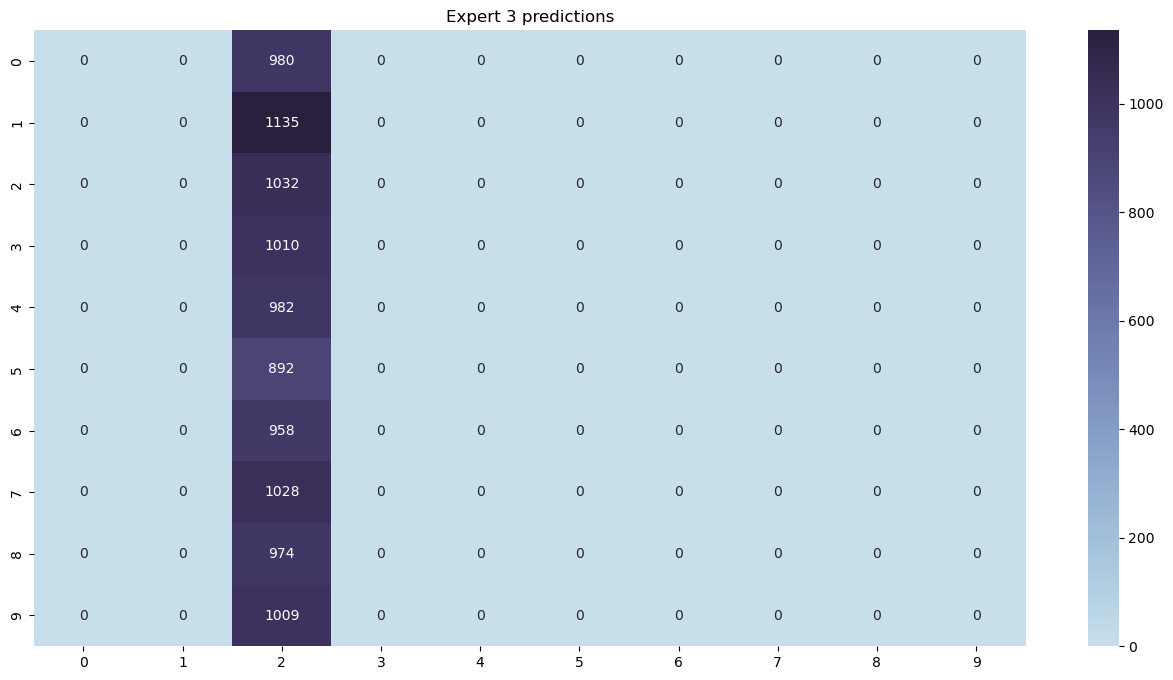

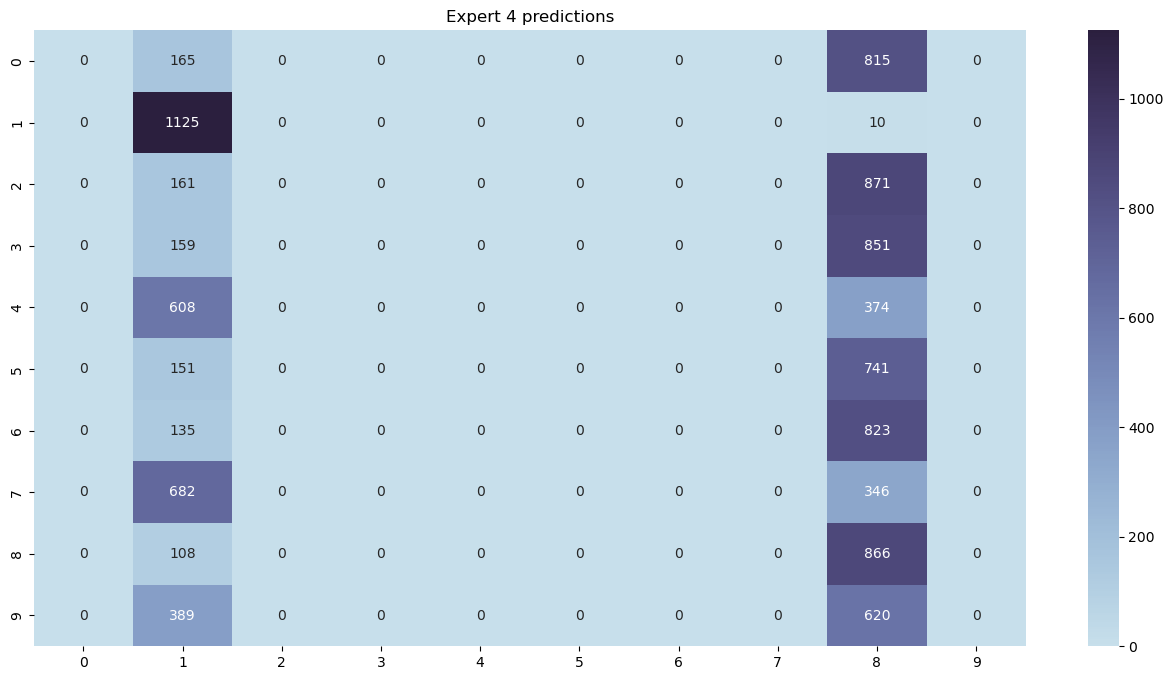

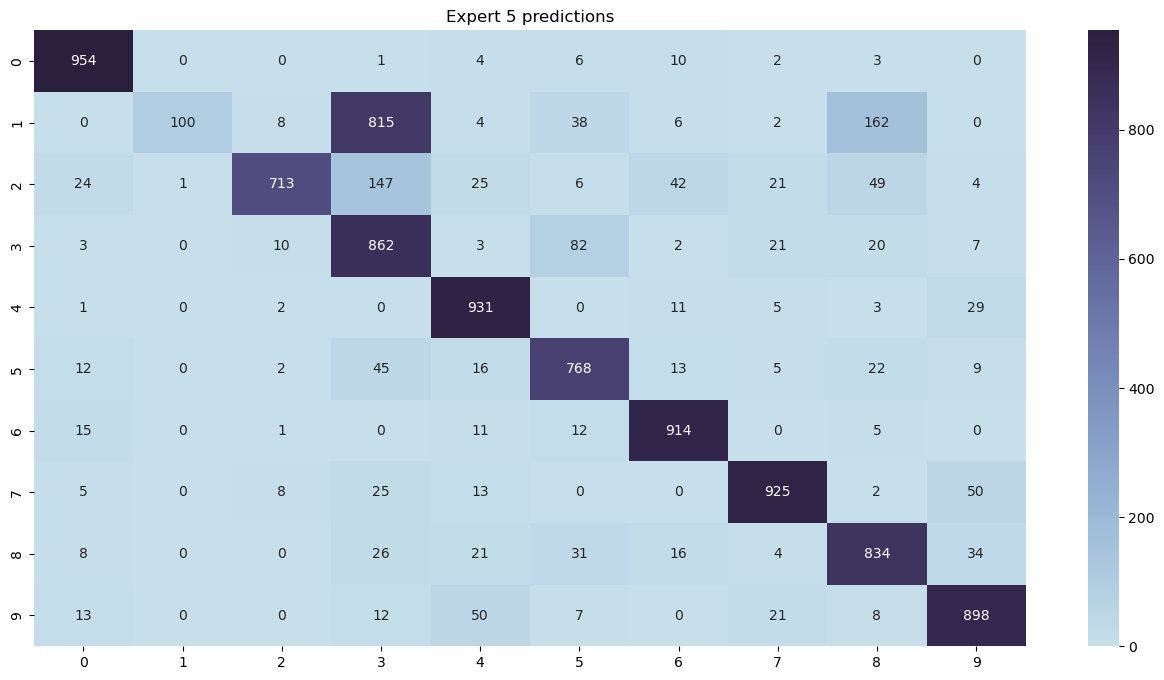

In [26]:
m=  'mnist_without_reg_stochastic_t_update_0.05'
model_type = 'moe_expert_stochastic_model'

# for T_sched in range(1,11):
T_sched = 1
print('T_sched', T_sched)
show_results(m, model_type, T_sched)

1
expert log loss:
 tensor([[-1.4079e+01, -4.7684e-07, -1.3129e+01, -2.1479e+01,  0.0000e+00],
        [ 0.0000e+00, -3.4538e+01,  0.0000e+00, -1.9335e+01,  0.0000e+00],
        [-1.4516e+01, -2.3842e-07, -3.7281e+00, -2.1698e+01, -9.4485e+00],
        [-3.4539e+01, -3.2837e-03, -2.4977e+01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.6164e-04, -1.4581e+01, -1.4403e+01, -2.9433e+01]],
       device='cuda:0', grad_fn=<SliceBackward0>)
expert log loss predicted by gate:
 tensor([[-1.5367e+01, -1.1915e-01, -1.3690e+01, -2.1432e+01,  2.0500e-01],
        [ 5.9694e-02, -3.6652e+01,  4.4512e-01, -1.8956e+01,  9.0891e-01],
        [-1.3731e+01,  9.6470e-03, -3.3941e+00, -2.0743e+01, -1.0472e+01],
        [-3.6827e+01, -1.5596e+00, -2.5638e+01,  2.8618e-01,  1.2831e-01],
        [-6.8585e-01,  8.7460e-02, -1.4707e+01, -1.7280e+01, -2.4718e+01]],
       device='cuda:0', grad_fn=<SliceBackward0>)


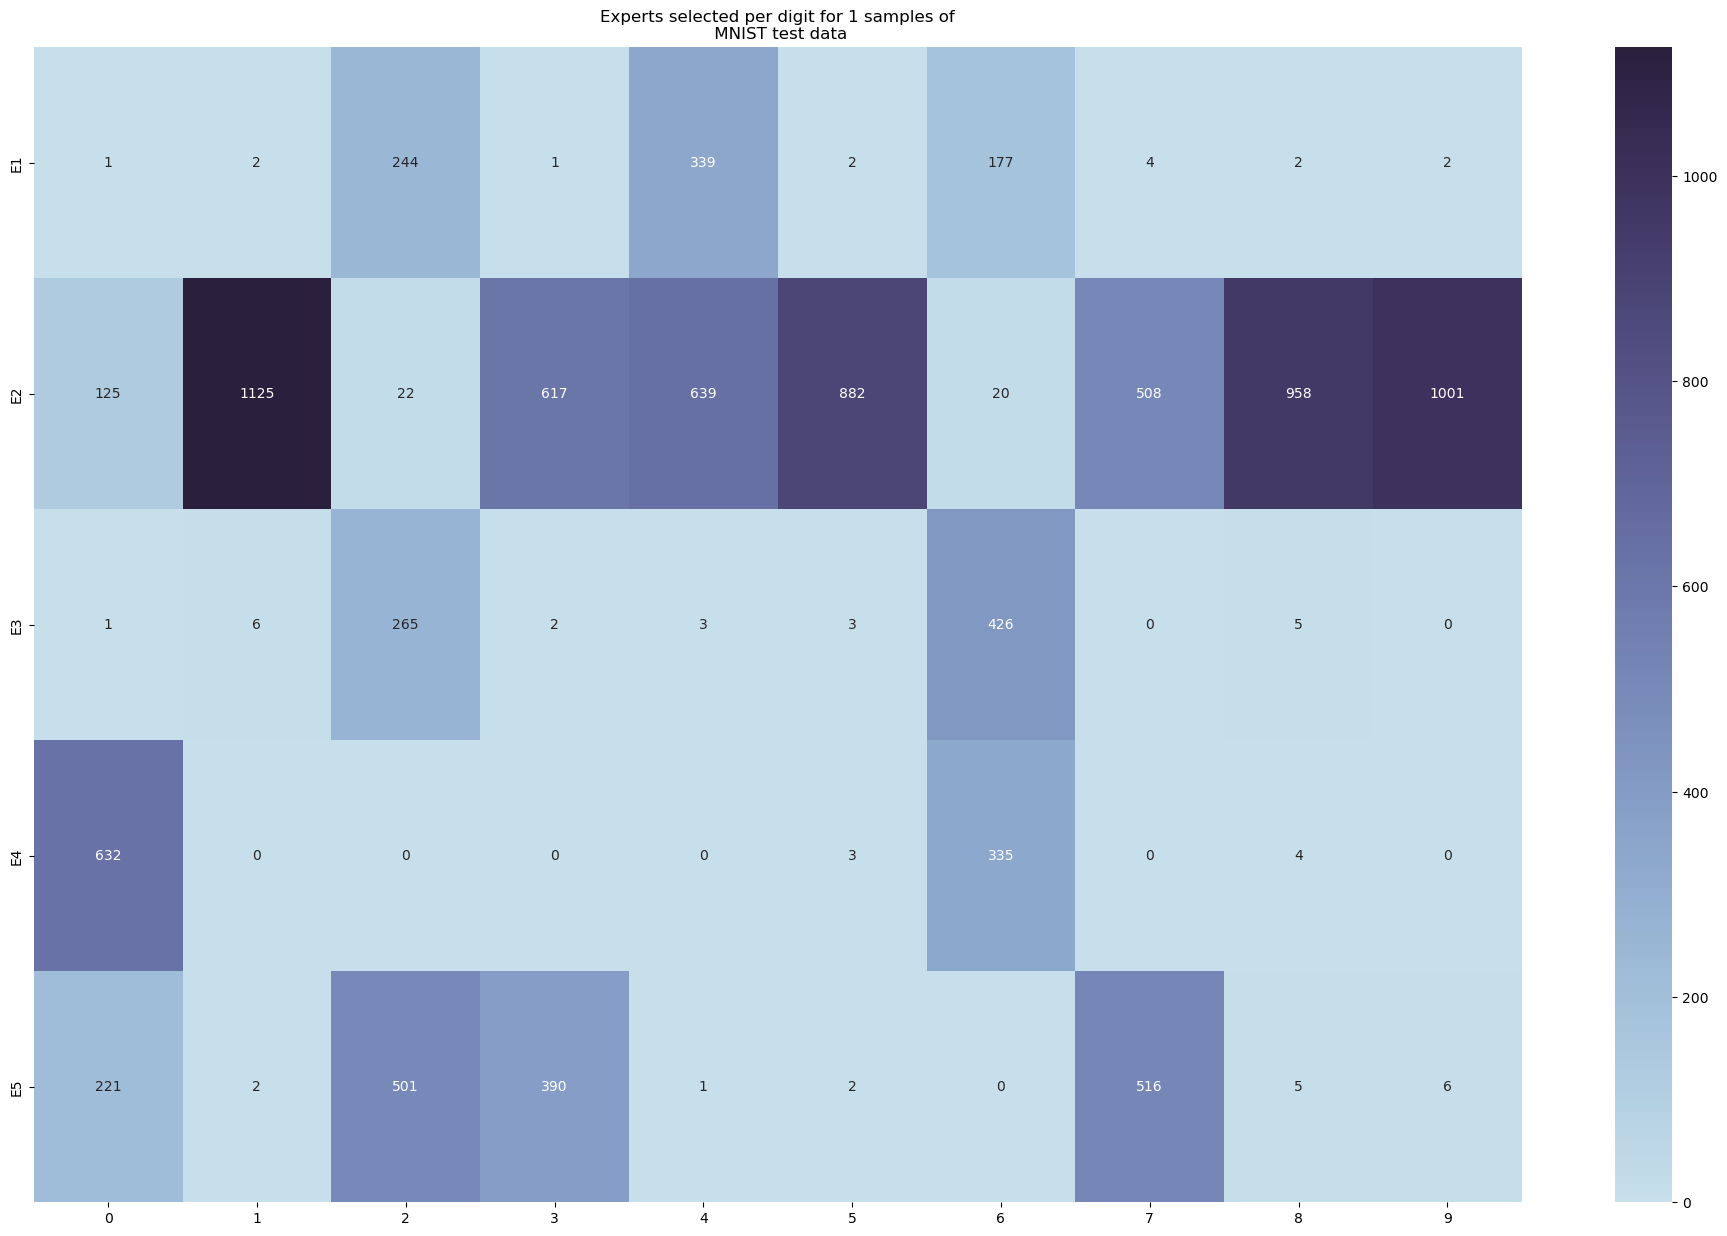

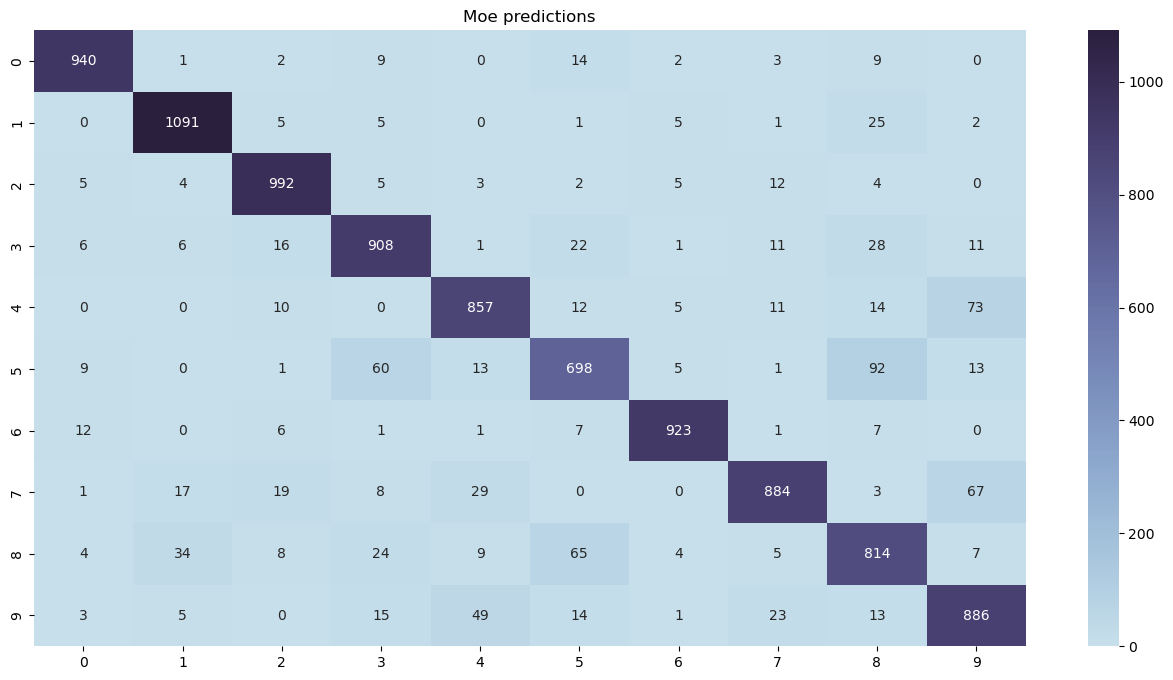

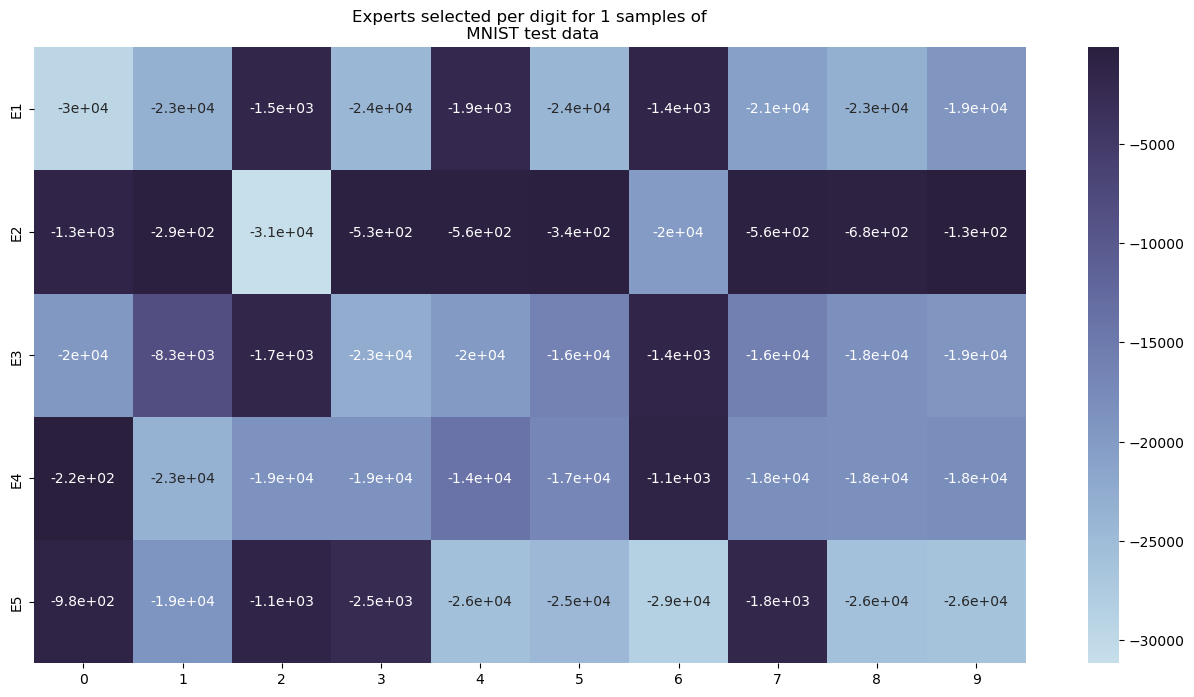

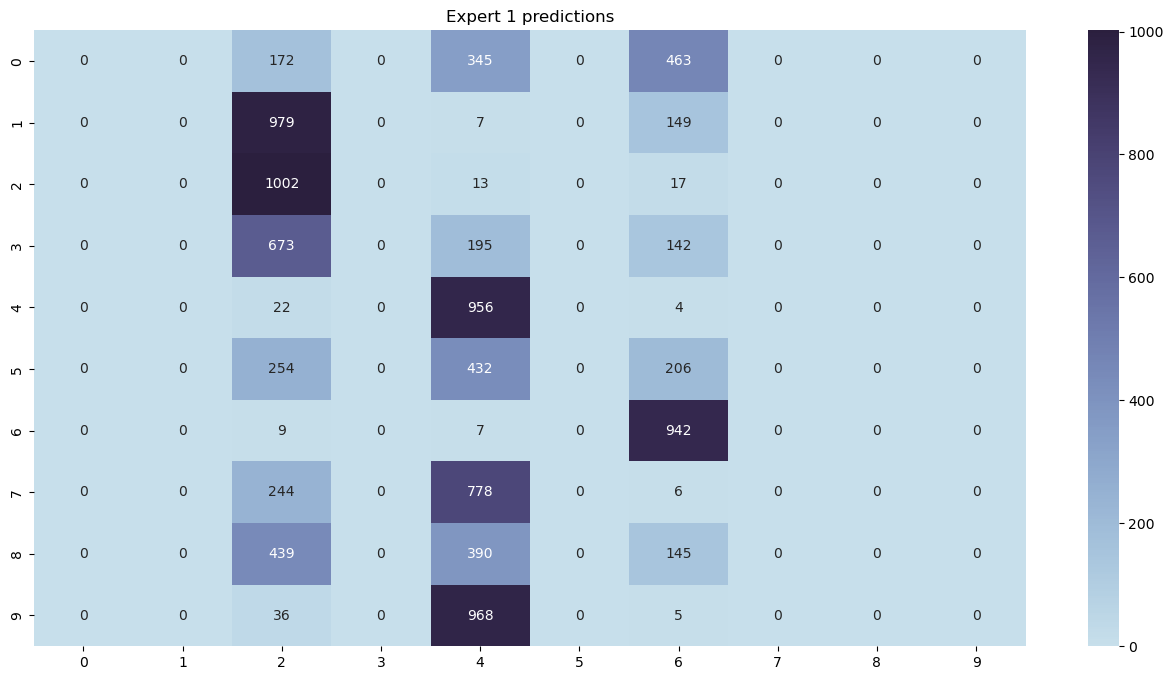

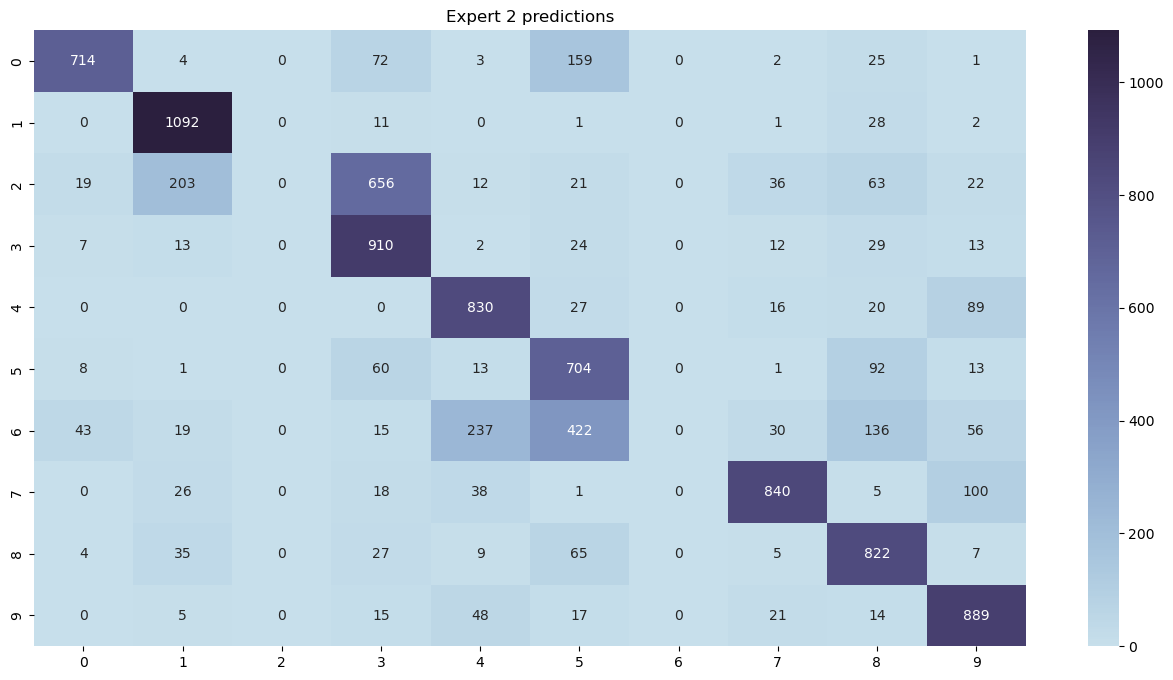

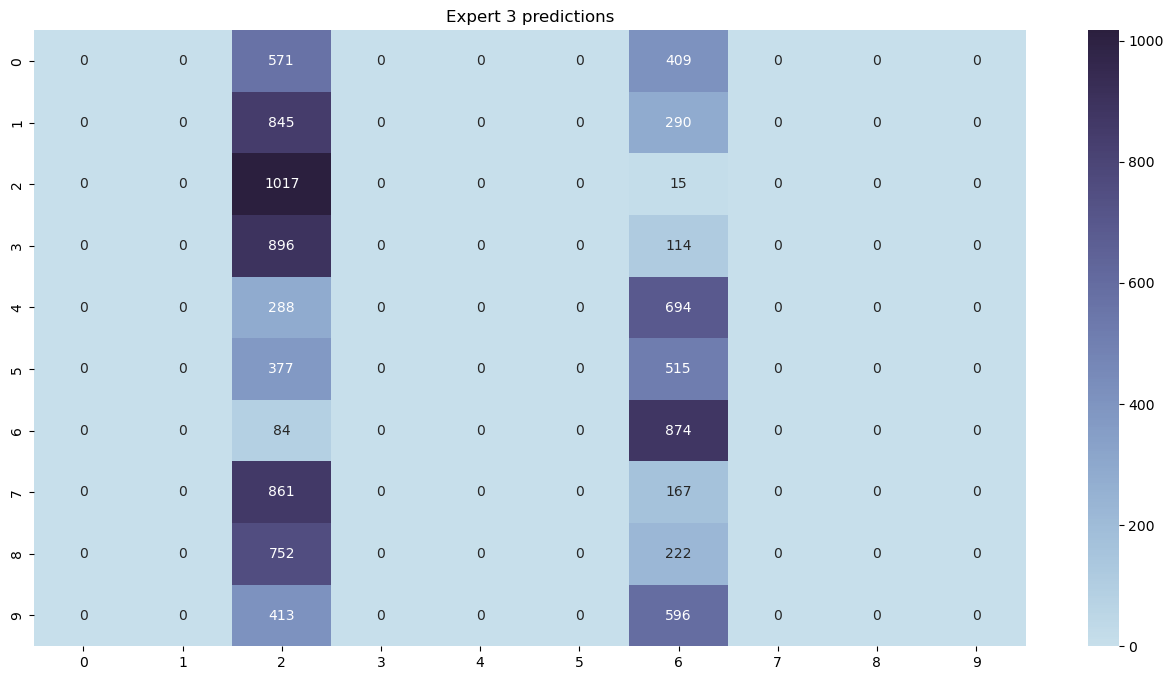

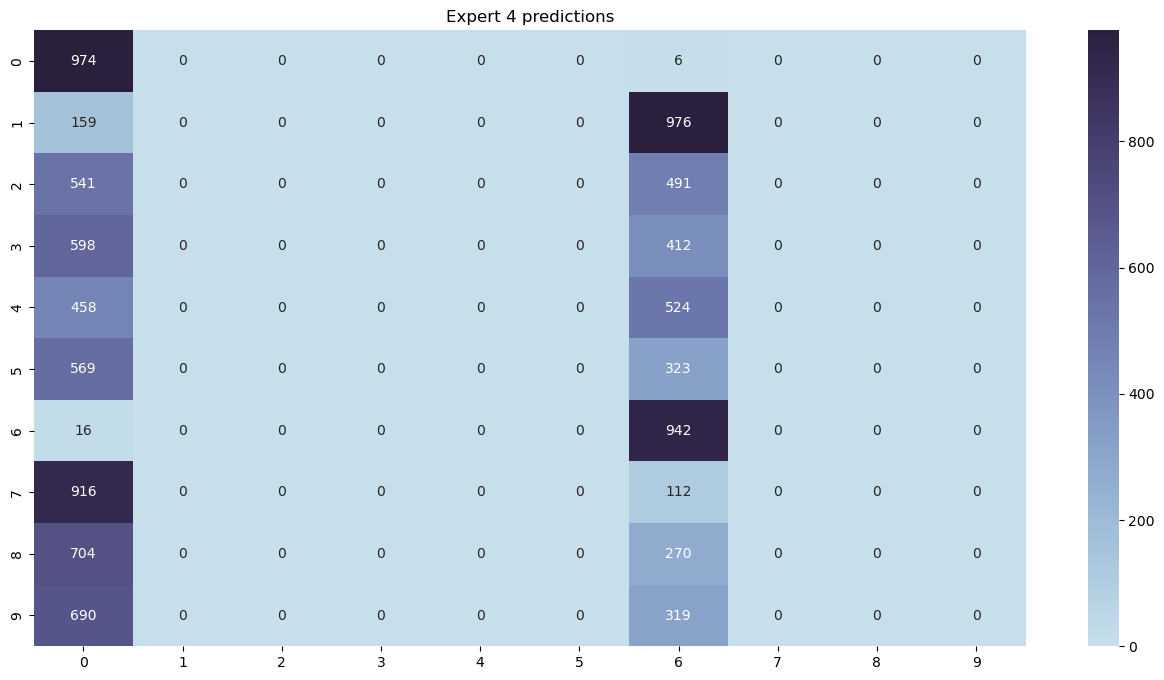

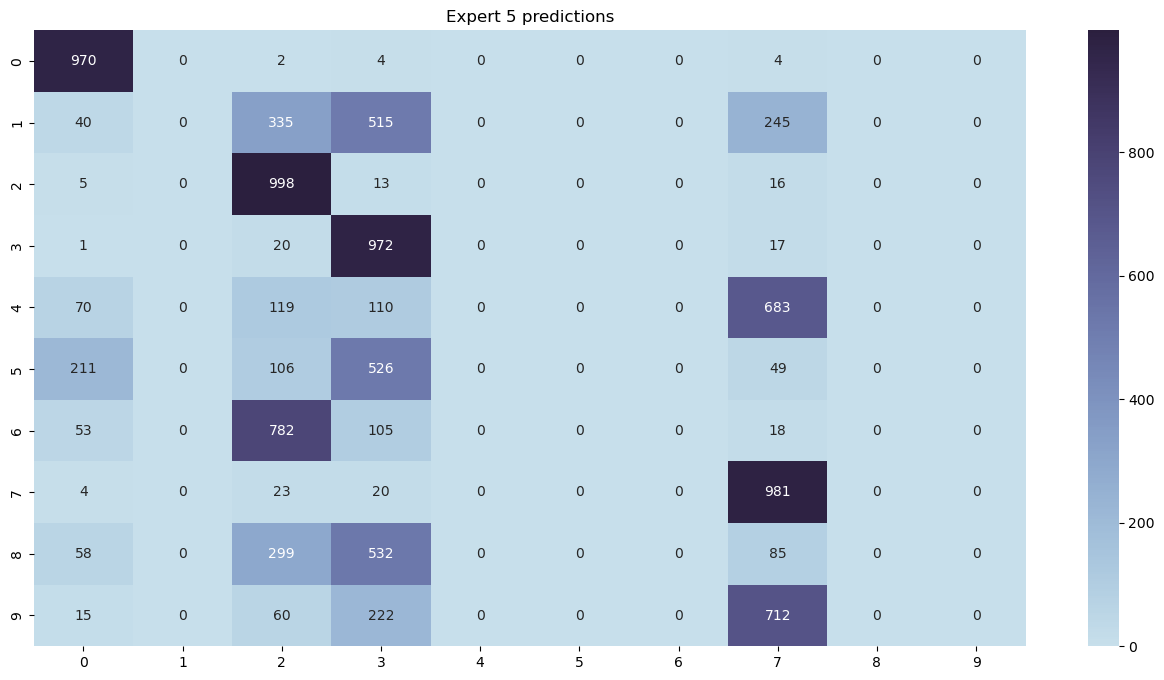

In [31]:
m = 'mnist_without_reg_expectation'
model_type = 'moe_expert_expectation_model'
show_results(m, model_type)

1
expert log loss:
 tensor([[-9.5649e+00, -1.0460e+01, -7.6424e+00,  0.0000e+00, -5.5298e+00],
        [-6.8705e+00, -8.8331e+00, -8.1828e+00, -3.4144e+01, -9.9586e-02],
        [-1.0471e-01, -1.0205e+01, -9.2119e+00, -1.3527e+01, -6.7141e+00],
        [-9.6991e+00, -3.9804e-02, -7.2444e+00, -3.4539e+01, -5.9506e+00],
        [-9.0380e+00, -8.0844e+00, -1.0863e+01, -2.6226e-06, -5.7898e+00]],
       device='cuda:0')
expert log loss predicted by gate:
 tensor([[ -9.3762, -10.1261,  -7.9787,  -0.6258,  -5.5588],
        [ -6.8192,  -9.9055,  -8.2368, -33.2432,  -0.2227],
        [  0.1547,  -9.6101,  -9.5848, -13.5108,  -6.8713],
        [ -9.1476,  -0.1127,  -7.6784, -34.1187,  -6.1272],
        [ -9.3848,  -8.2420, -10.6834,   0.6798,  -5.9684]], device='cuda:0',
       grad_fn=<SliceBackward0>)


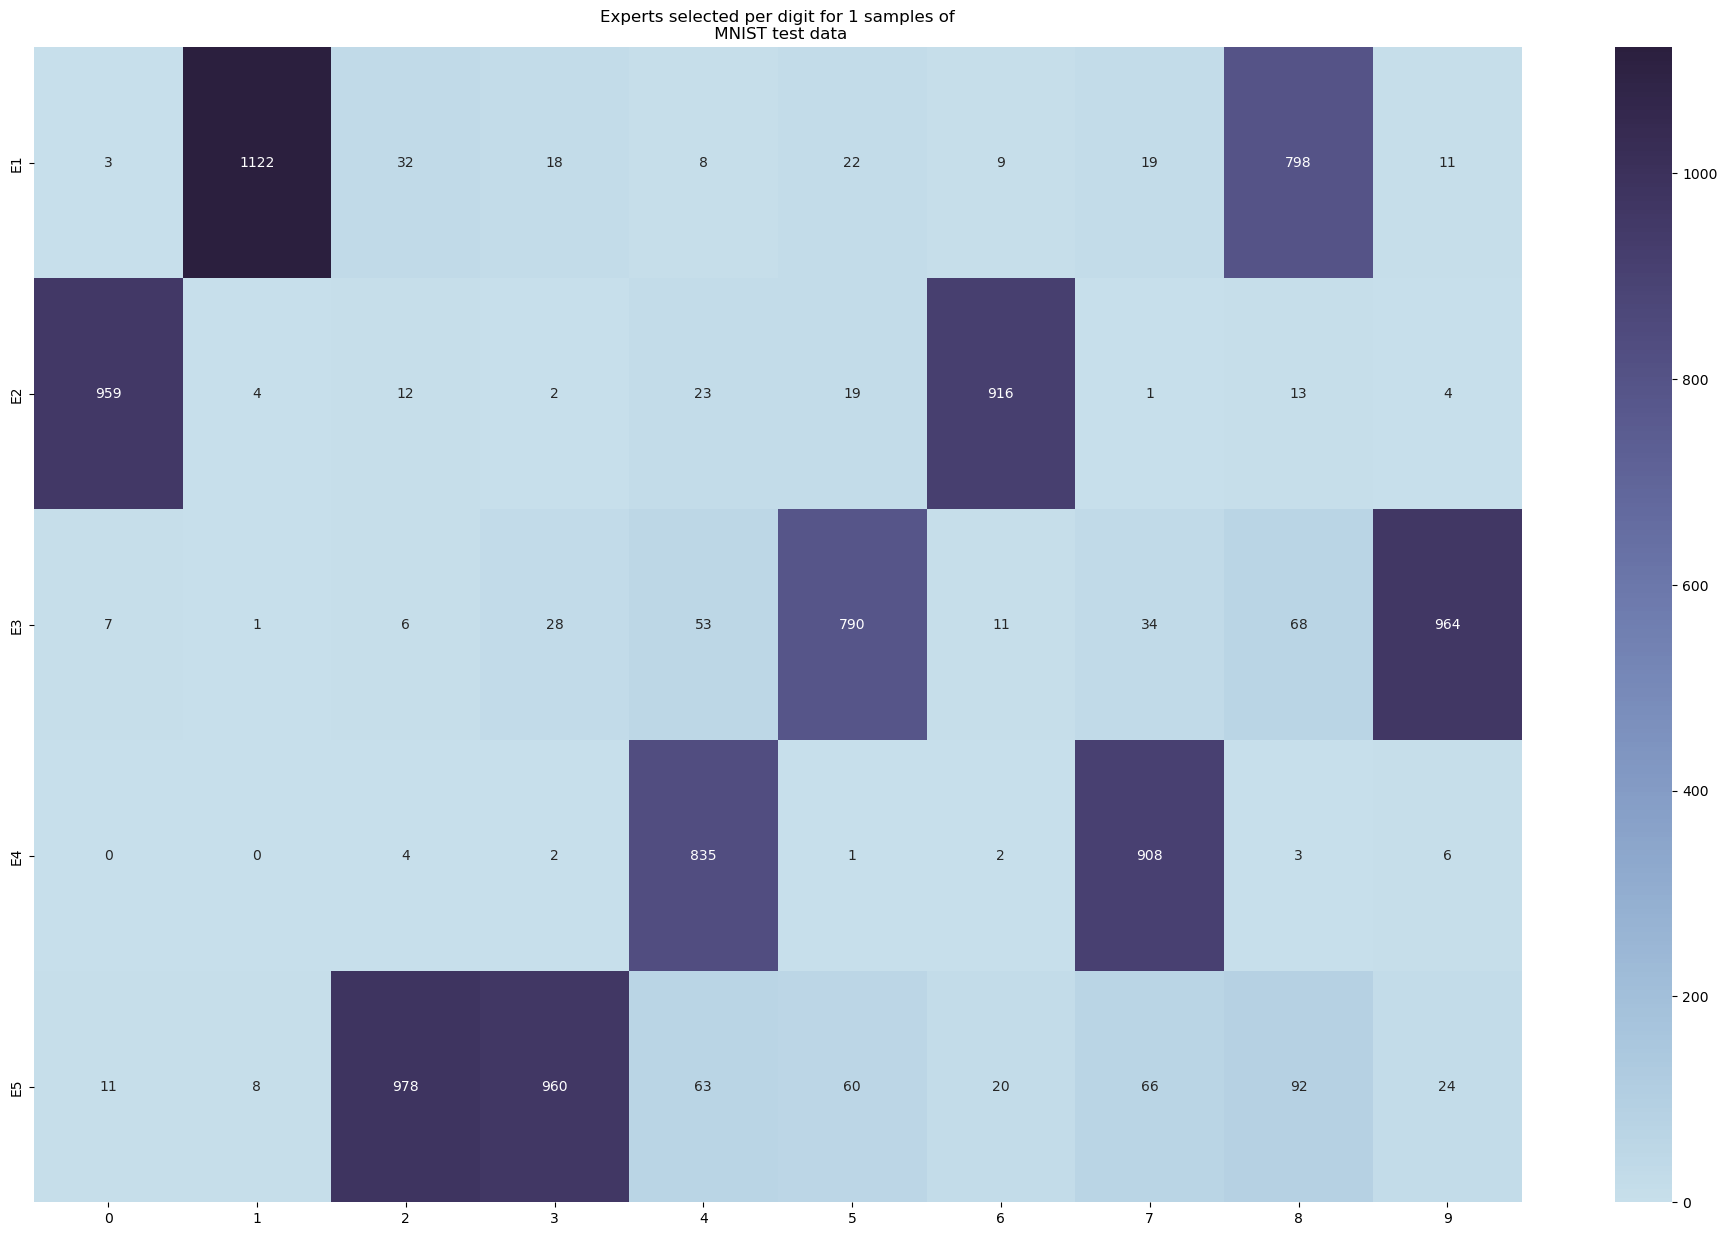

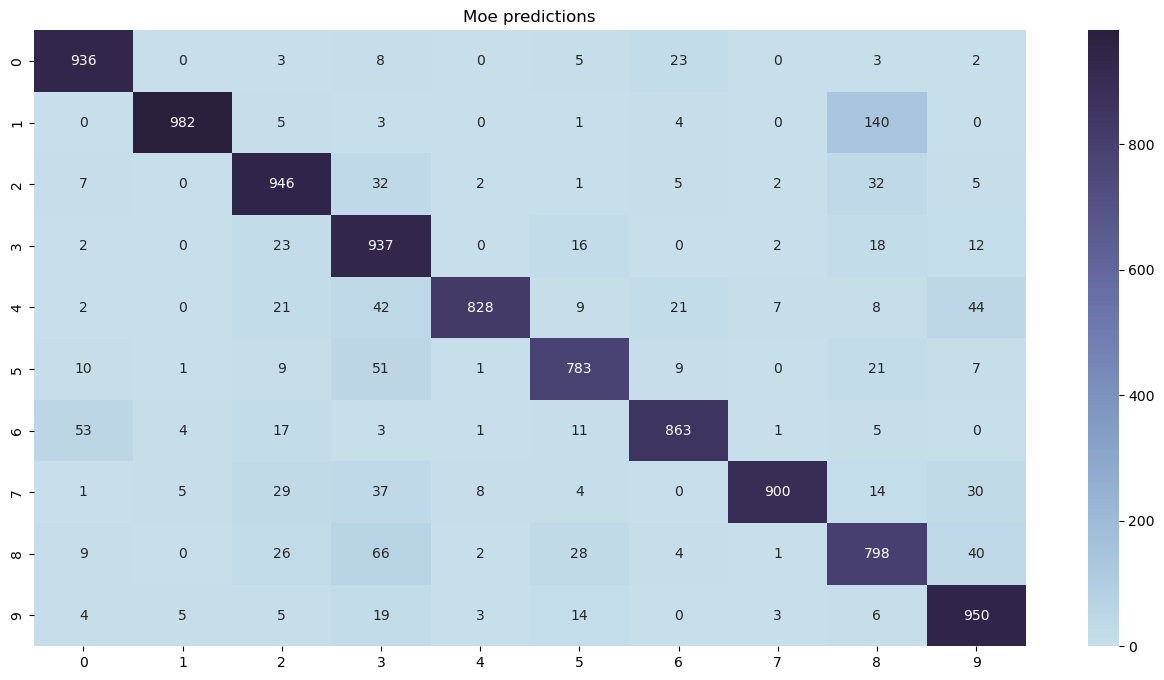

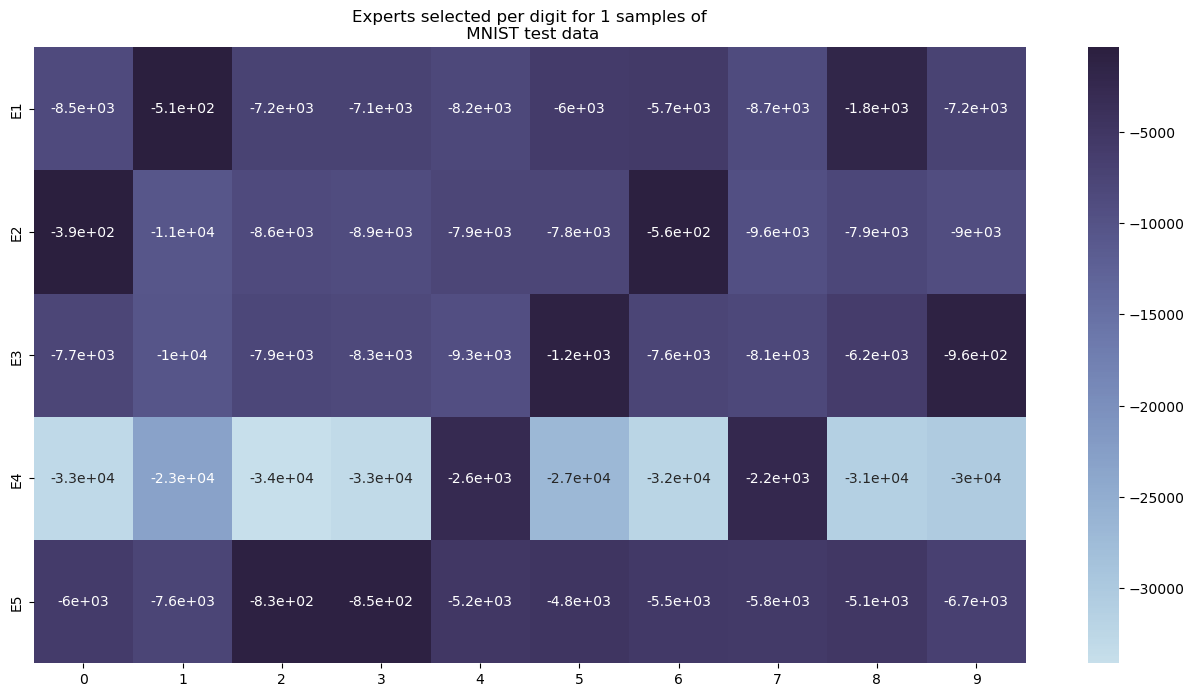

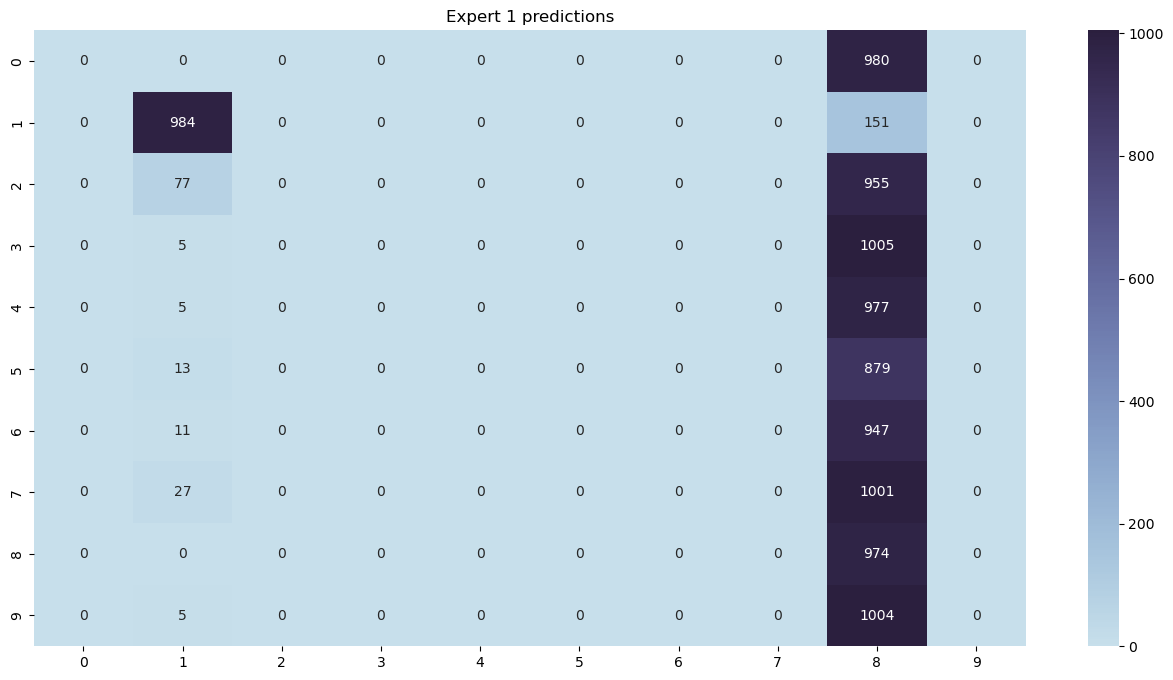

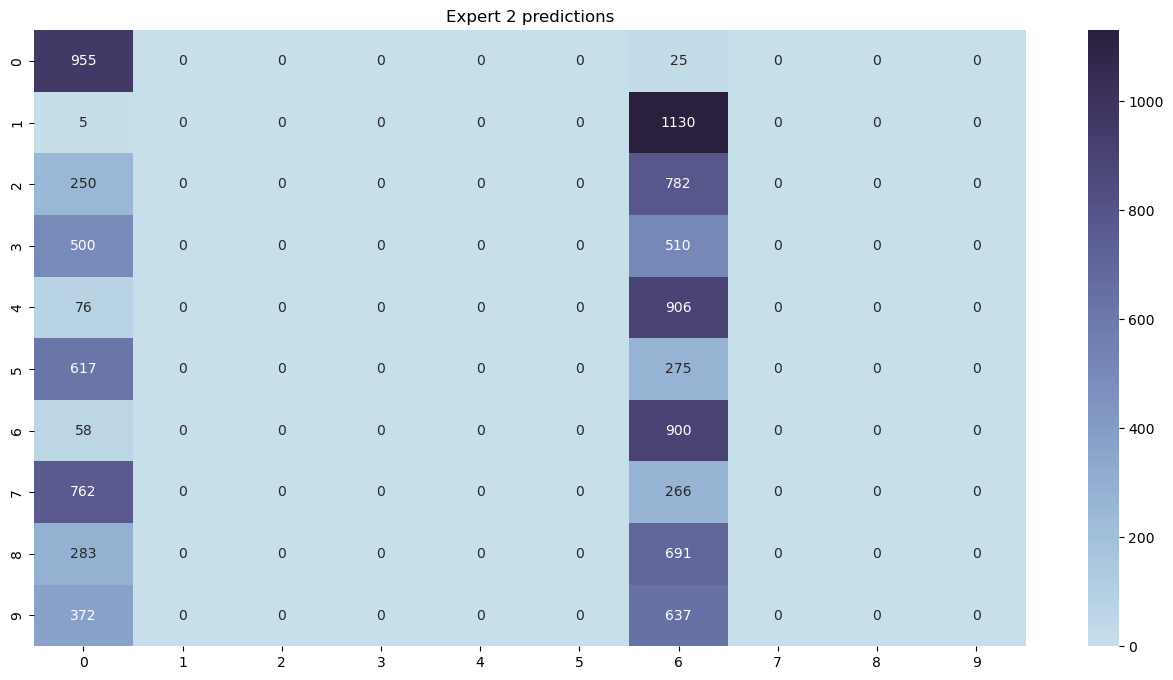

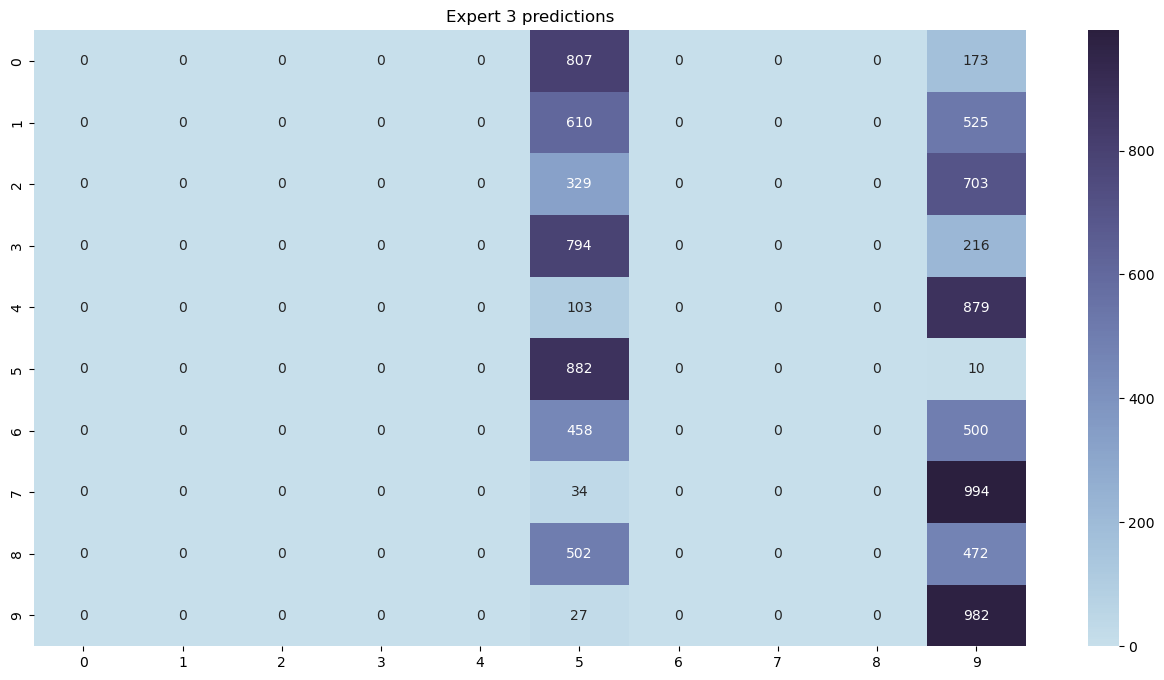

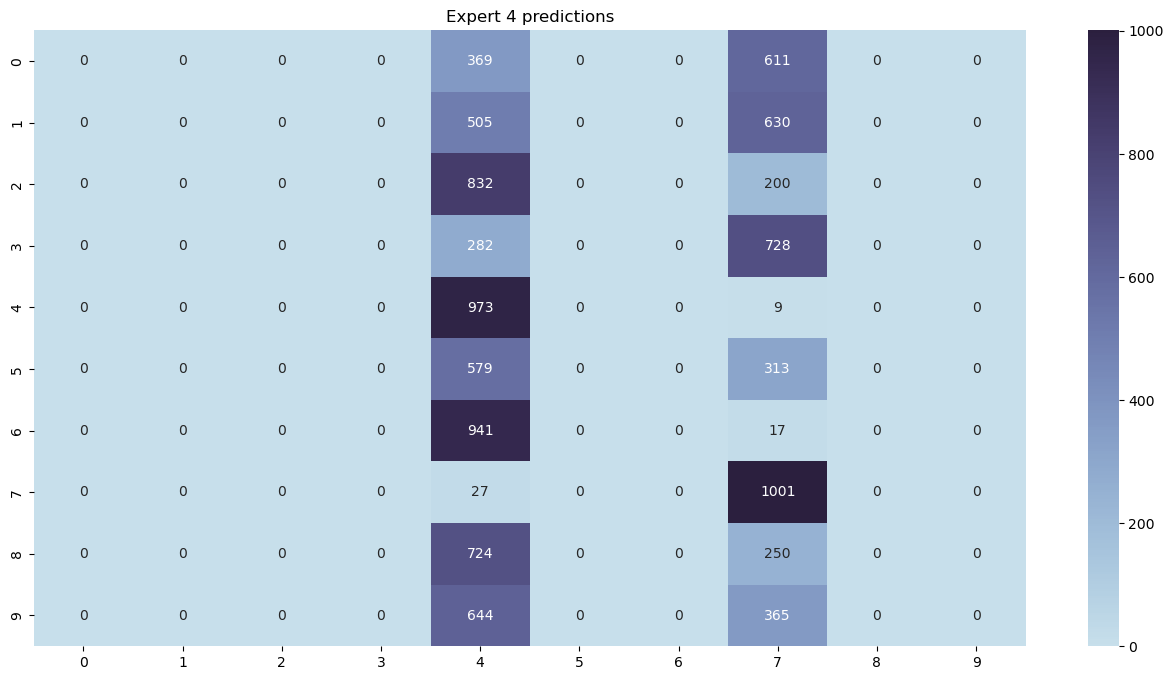

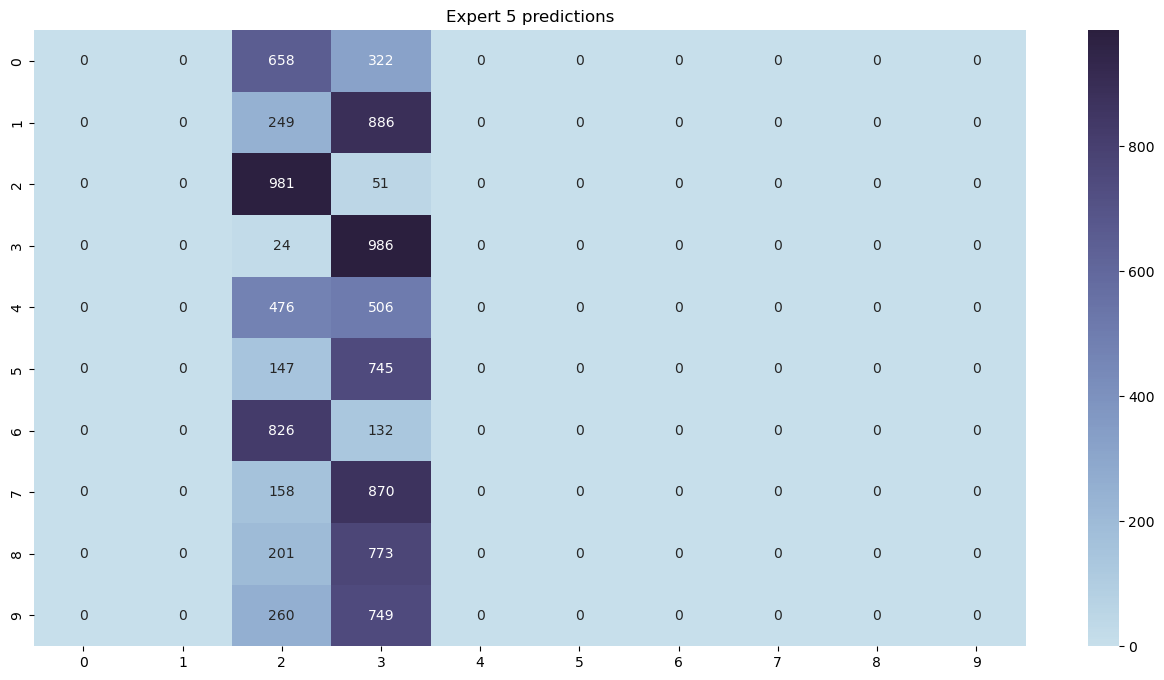

In [58]:
m = 'mnist_pretrained_experts_stochastic'
model_type = 'moe_expert_stochastic_model'
show_results(m, model_type)

1
expert log loss:
 tensor([[-9.5649e+00, -1.0460e+01, -7.6424e+00,  0.0000e+00, -5.5298e+00],
        [-6.8705e+00, -8.8331e+00, -8.1828e+00, -3.4144e+01, -9.9586e-02],
        [-1.0471e-01, -1.0205e+01, -9.2119e+00, -1.3527e+01, -6.7141e+00],
        [-9.6991e+00, -3.9804e-02, -7.2444e+00, -3.4539e+01, -5.9506e+00],
        [-9.0380e+00, -8.0844e+00, -1.0863e+01, -2.6226e-06, -5.7898e+00]],
       device='cuda:0')
expert log loss predicted by gate:
 tensor([[-9.6605e+00, -1.0211e+01, -8.1363e+00, -4.7195e-03, -5.4680e+00],
        [-6.9951e+00, -9.6059e+00, -8.4655e+00, -3.3342e+01, -2.3395e-01],
        [-3.3328e-01, -1.0093e+01, -8.9679e+00, -1.3565e+01, -6.6917e+00],
        [-9.3250e+00,  1.6295e-01, -7.1159e+00, -3.5350e+01, -6.3730e+00],
        [-9.1904e+00, -8.0242e+00, -1.0099e+01,  6.2538e-01, -6.0438e+00]],
       device='cuda:0', grad_fn=<SliceBackward0>)


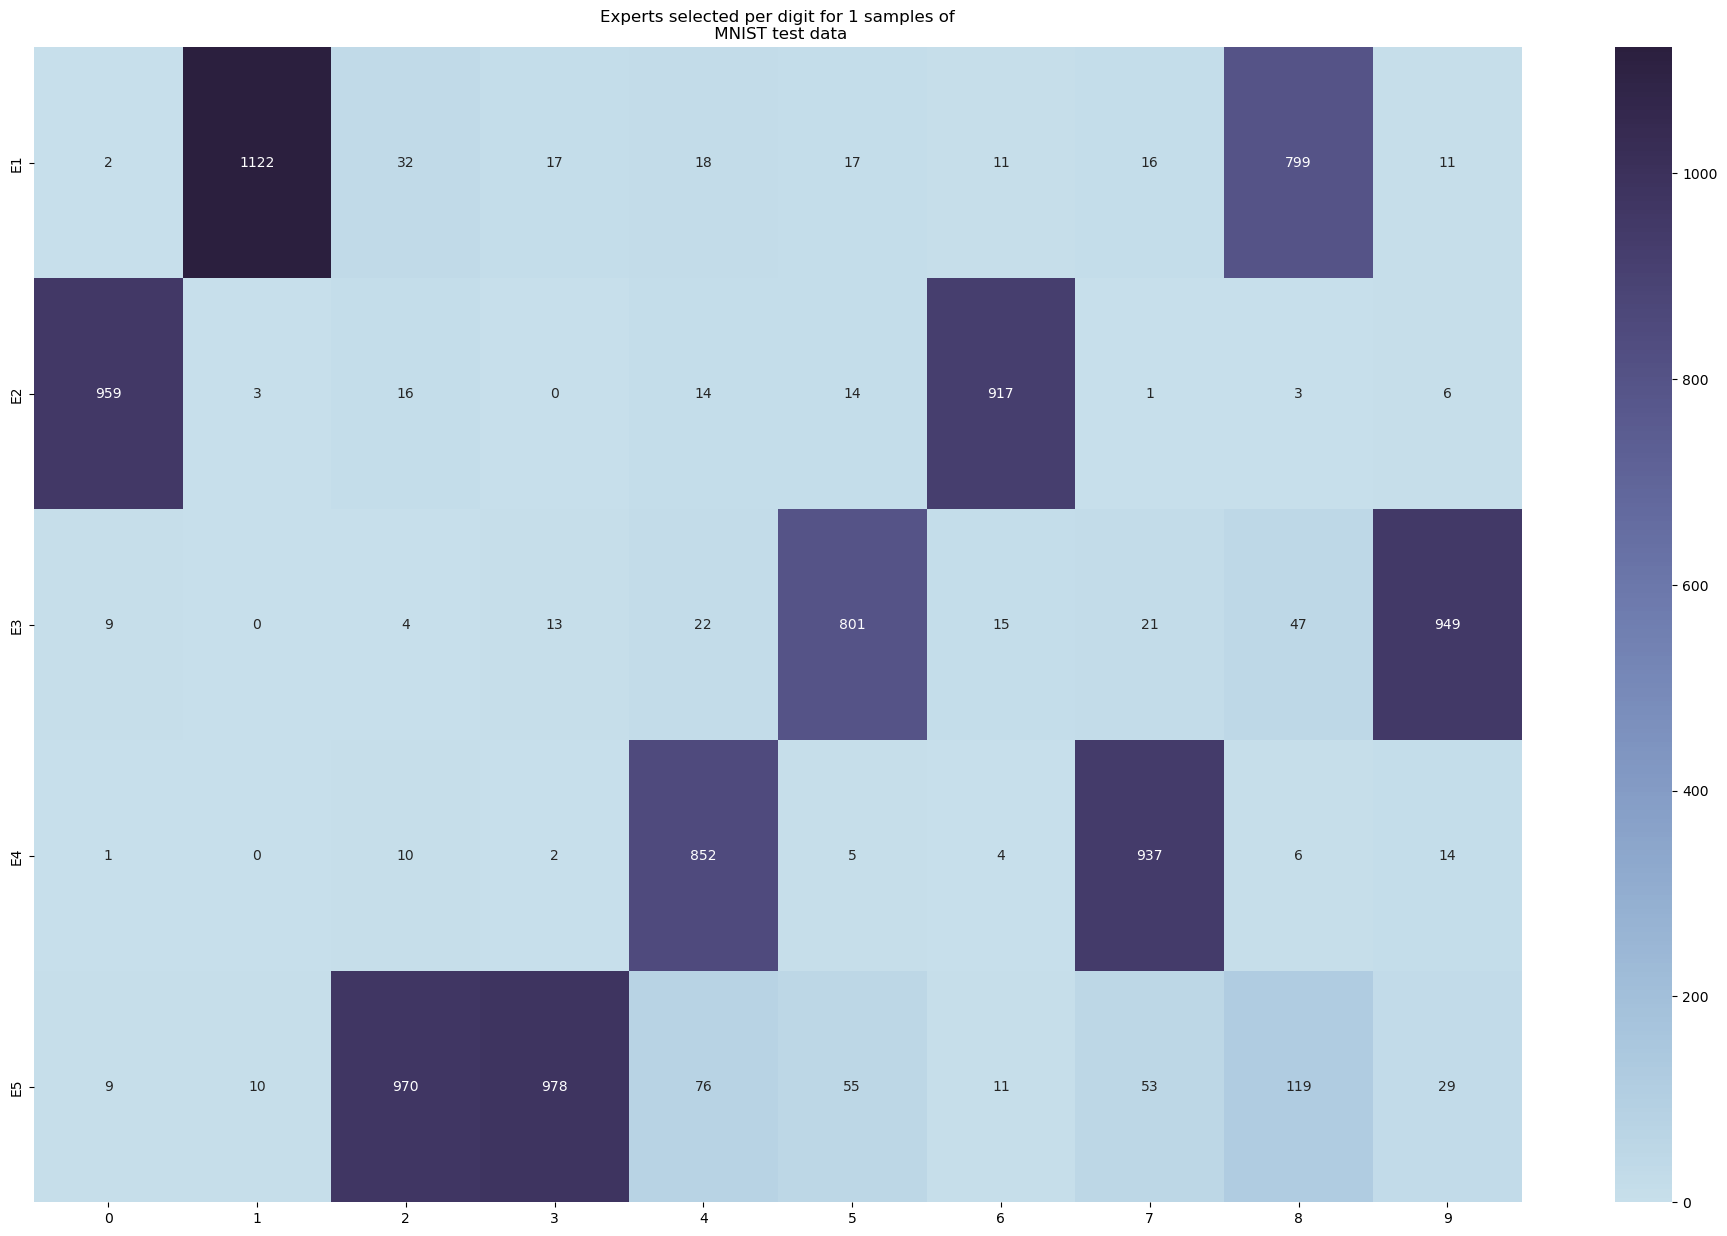

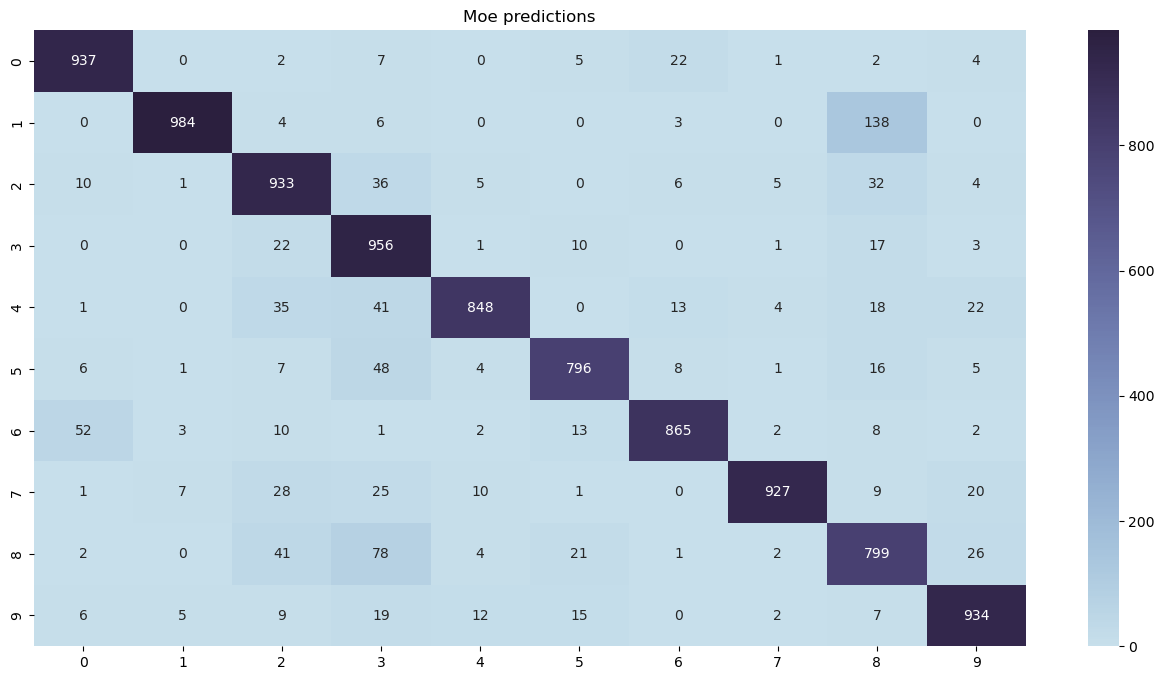

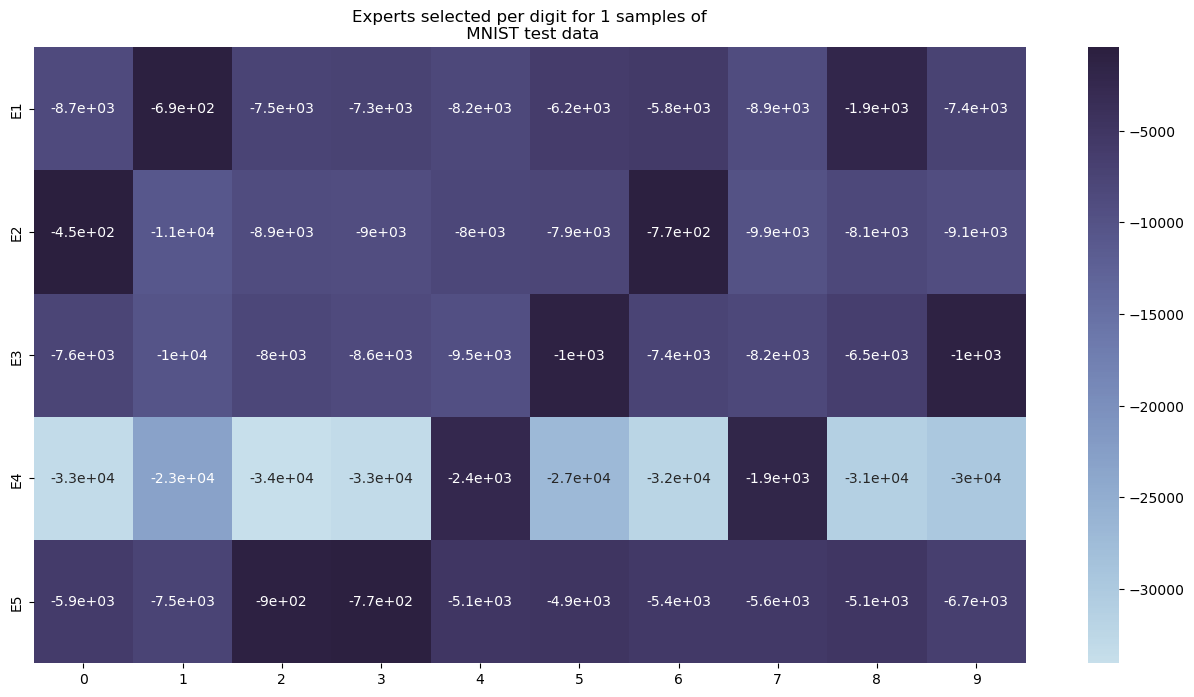

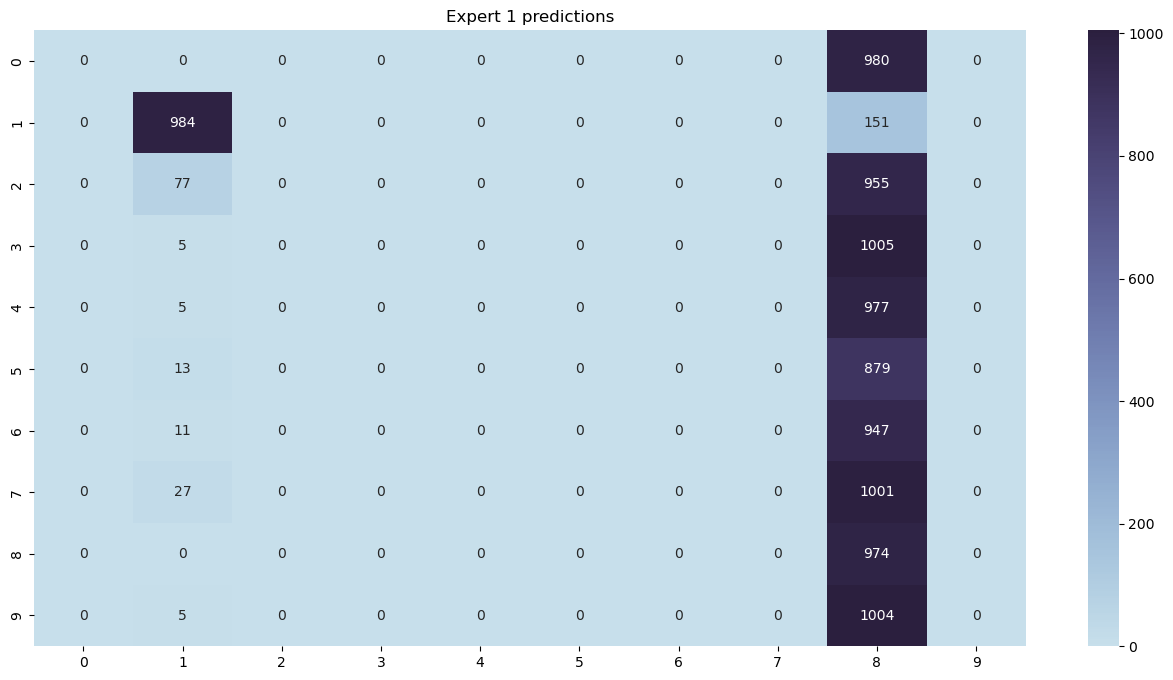

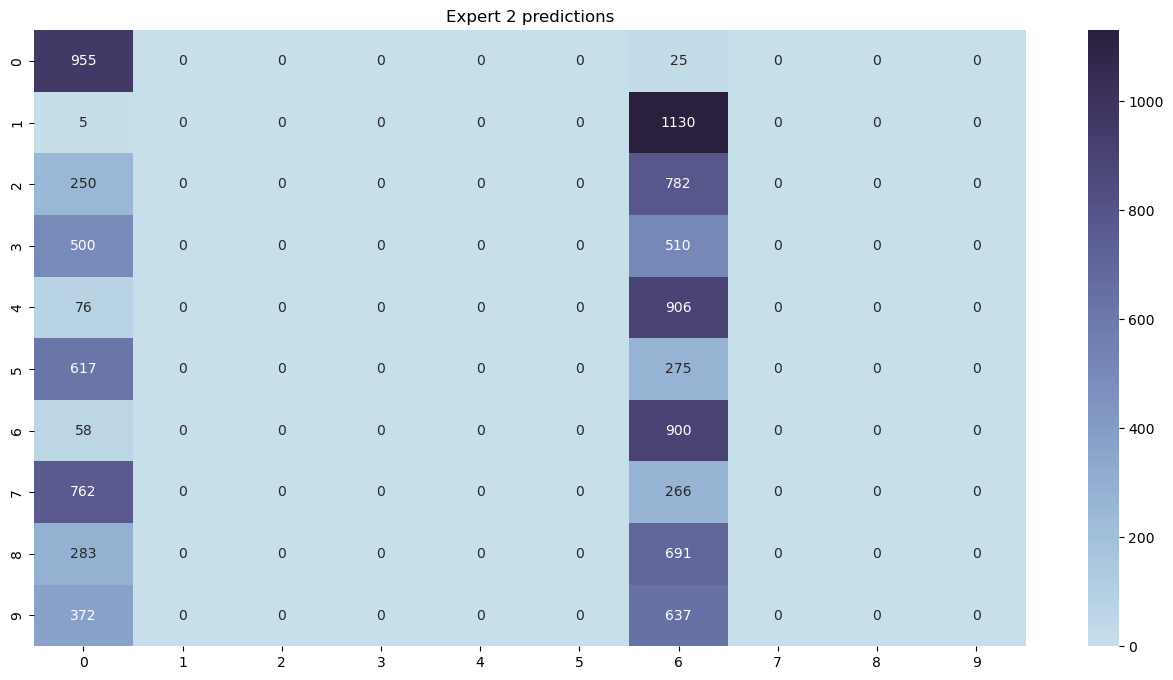

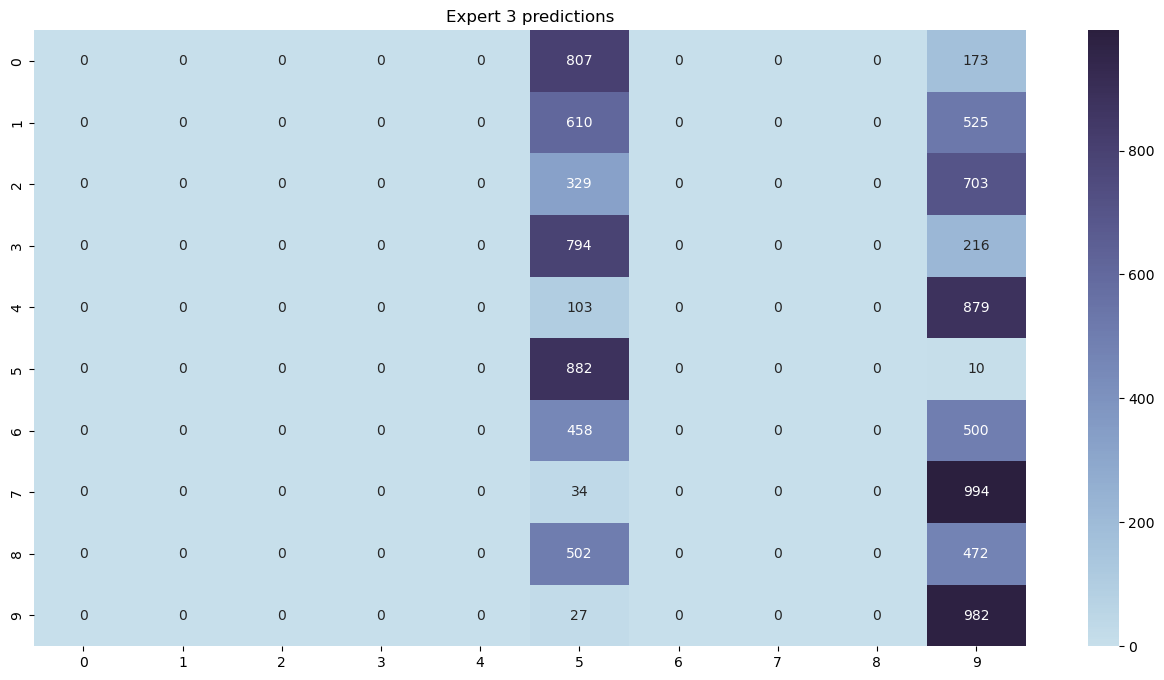

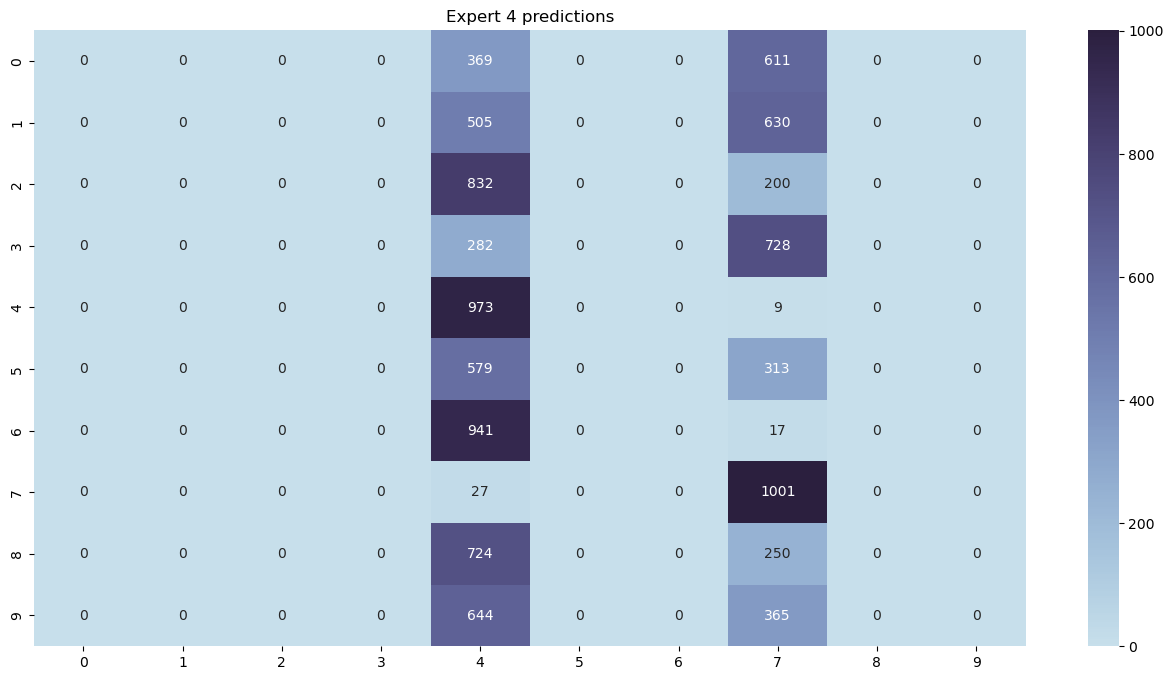

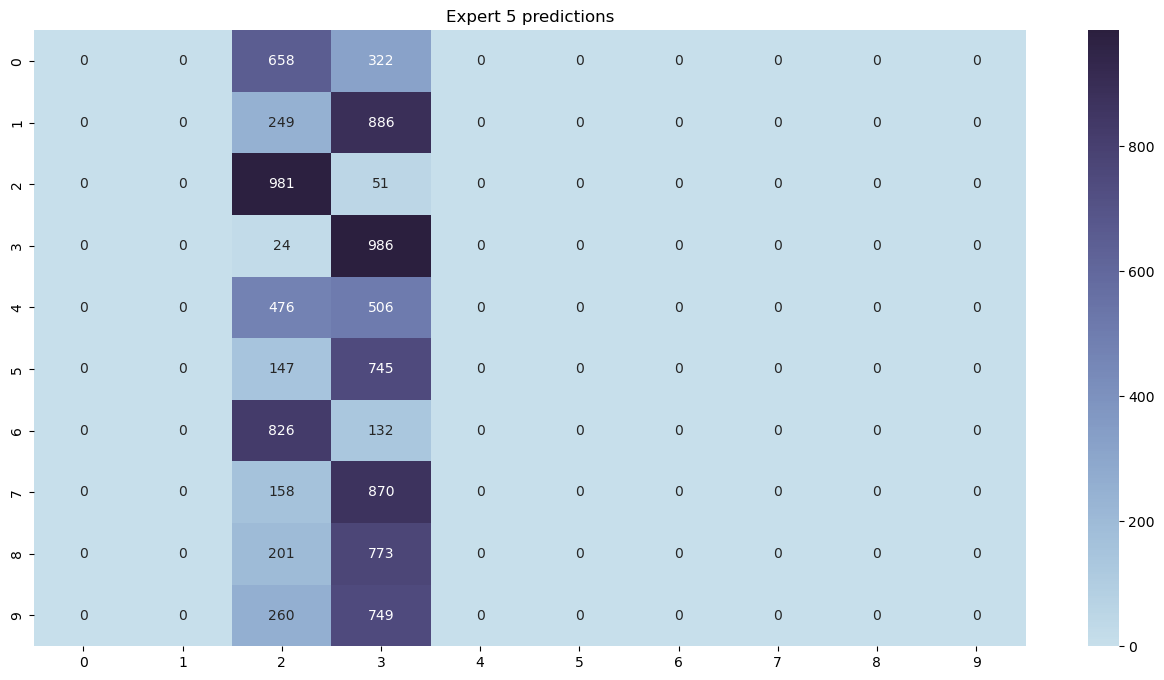

In [61]:
m = 'mnist_pretrained_experts_expectation'
model_type = 'moe_expert_expectation_model'
show_results(m, model_type)

1
expert log loss:
 tensor([[-1.8613e-03, -1.1520e-02, -3.8513e-02, -9.6864e-02, -2.9476e-03],
        [-3.5066e-02, -2.8316e-01, -2.7004e-01, -1.1370e+00, -2.3833e-02],
        [-1.1209e-01, -2.0894e-02, -1.2234e-01, -1.3288e-01, -3.2435e-02],
        [-3.5853e-04, -5.6623e-04, -2.9276e-02, -5.8592e-02, -4.0196e-03],
        [-5.3698e-02, -6.5927e-02, -3.9900e-01, -1.7427e-01, -3.4322e-01]],
       device='cuda:0')
expert log loss predicted by gate:
 tensor([[ 0.0274,  0.0085, -0.1029, -0.1327,  0.0137],
        [-0.0771, -0.1151, -0.4198, -0.4493, -0.1058],
        [-0.0627, -0.0199, -0.1280, -0.1182, -0.0458],
        [ 0.0065, -0.0009, -0.0797, -0.0842, -0.0020],
        [-0.0616, -0.0527, -0.3543, -0.3943, -0.0757]], device='cuda:0',
       grad_fn=<SliceBackward0>)


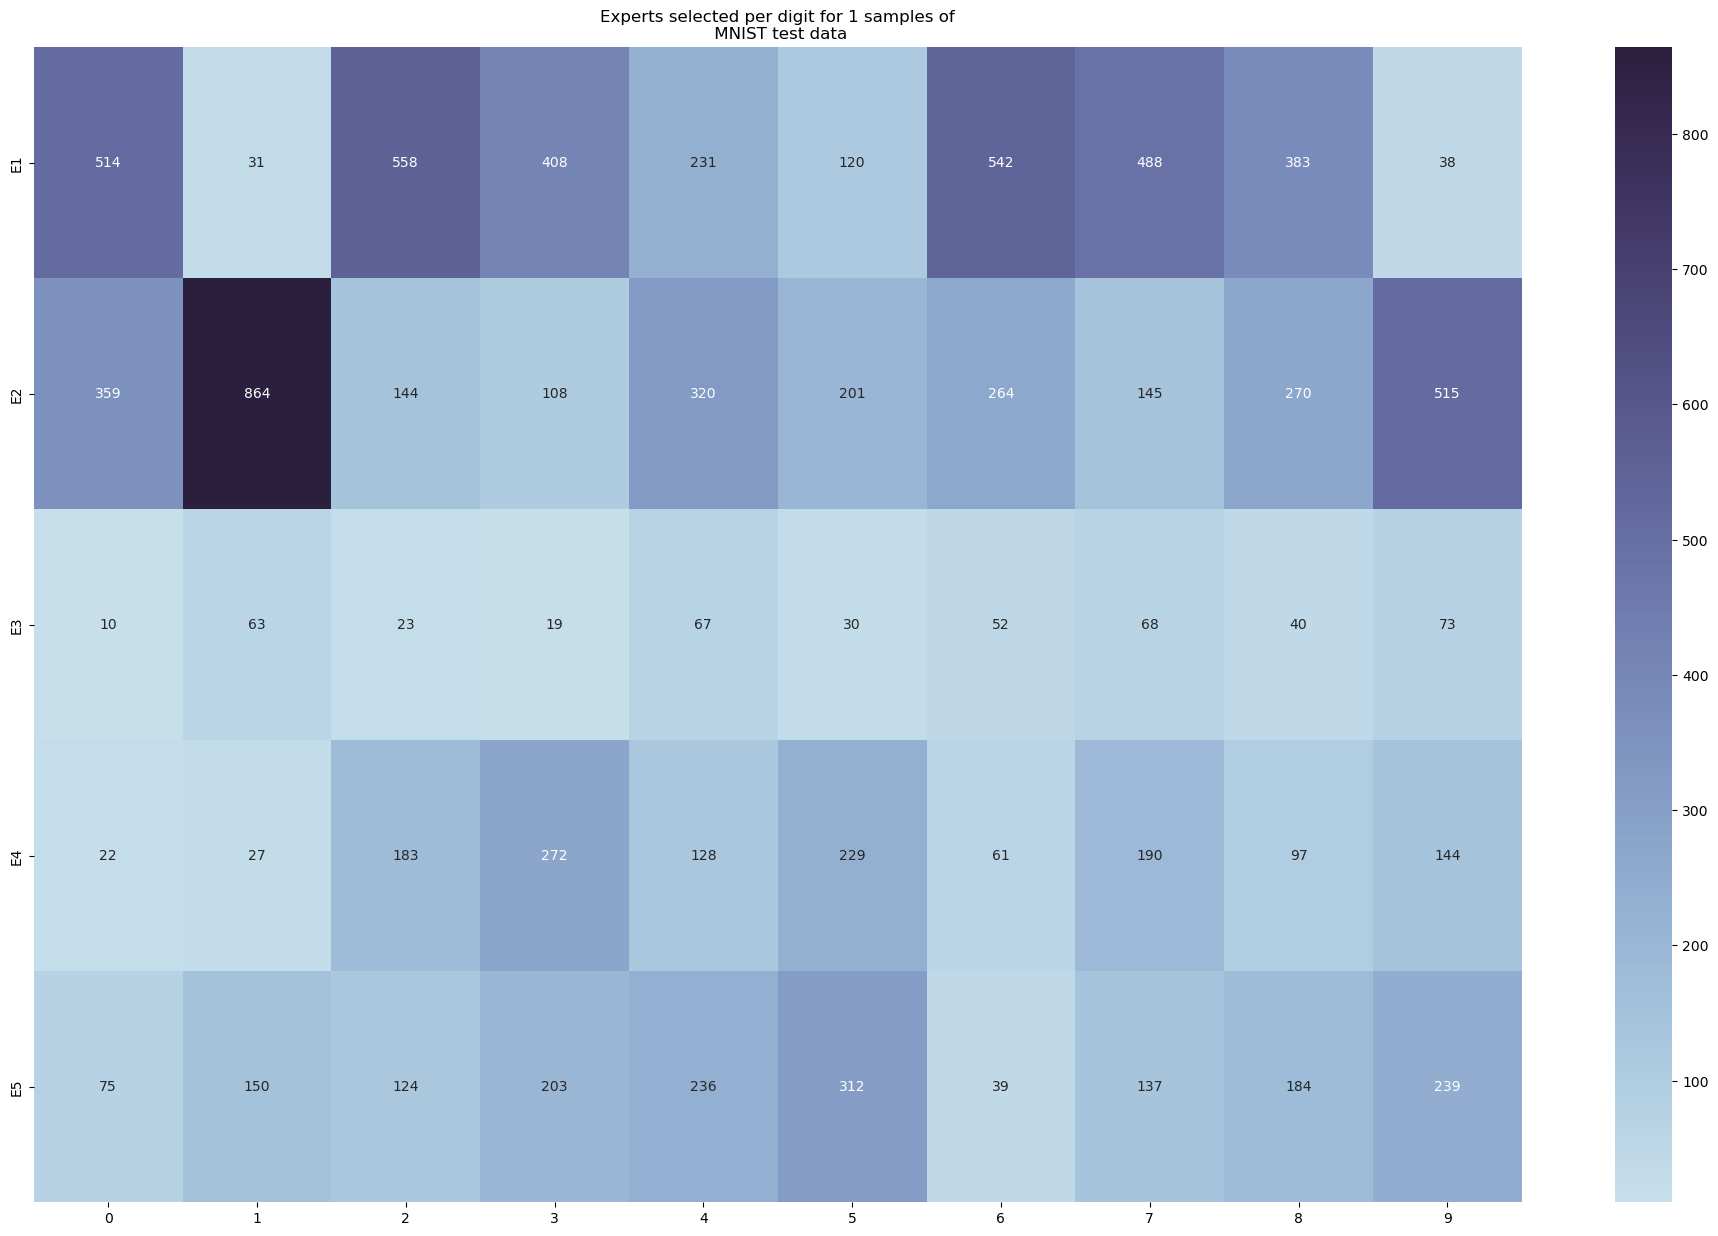

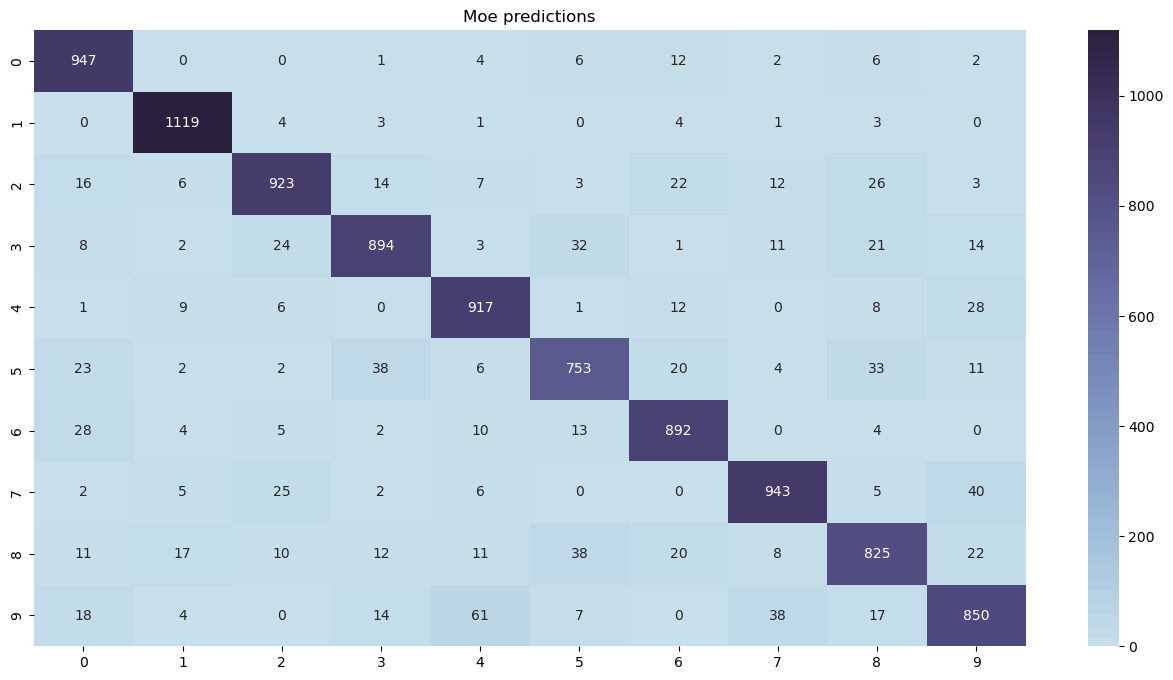

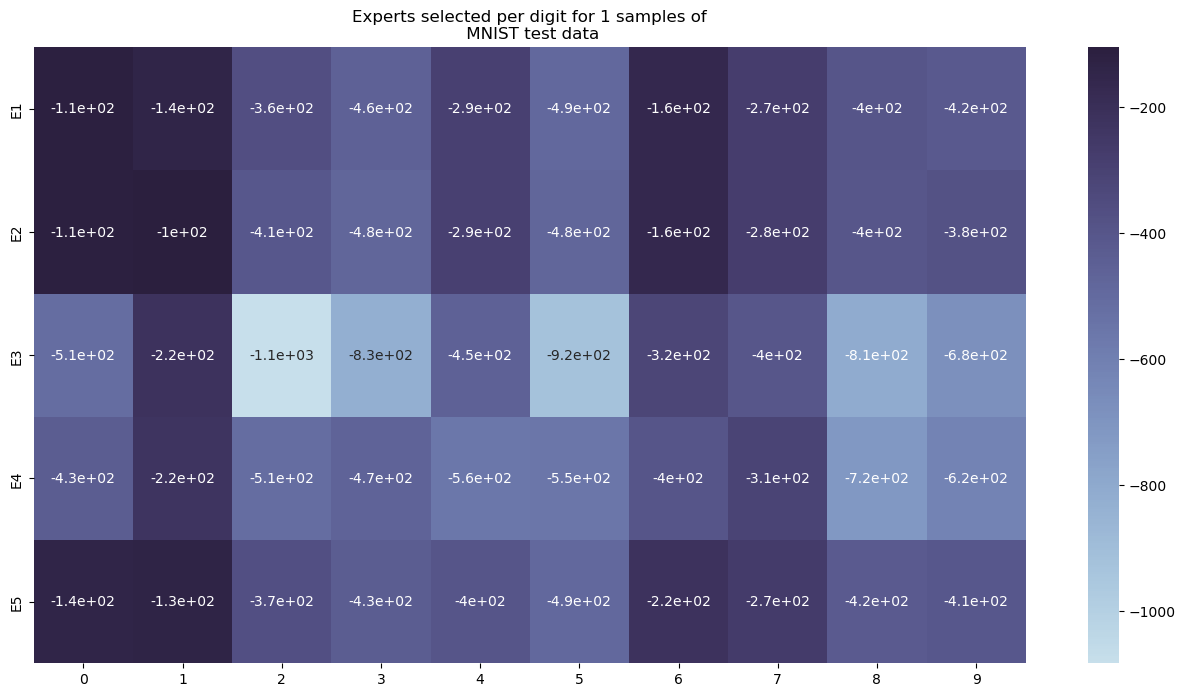

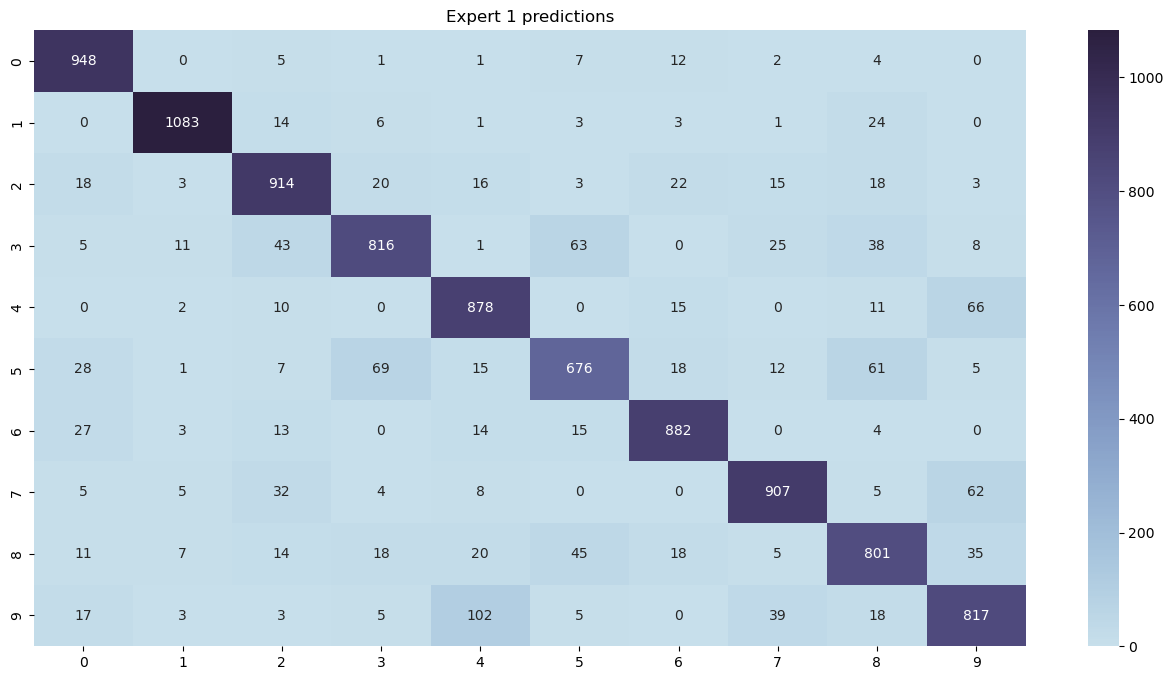

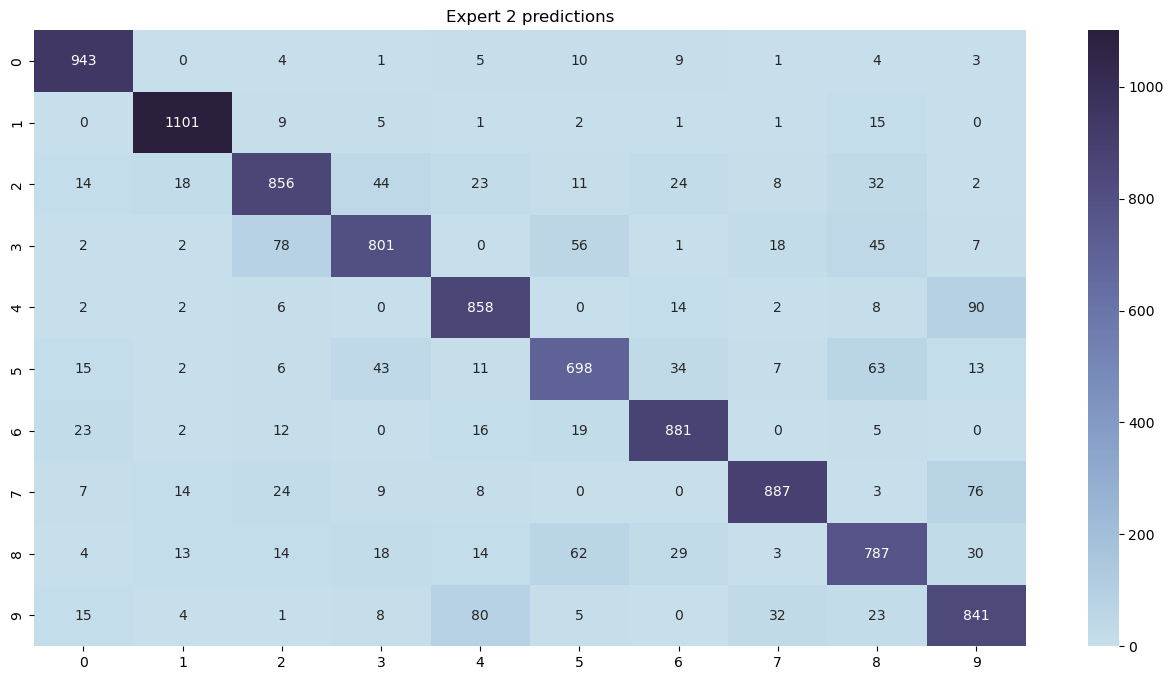

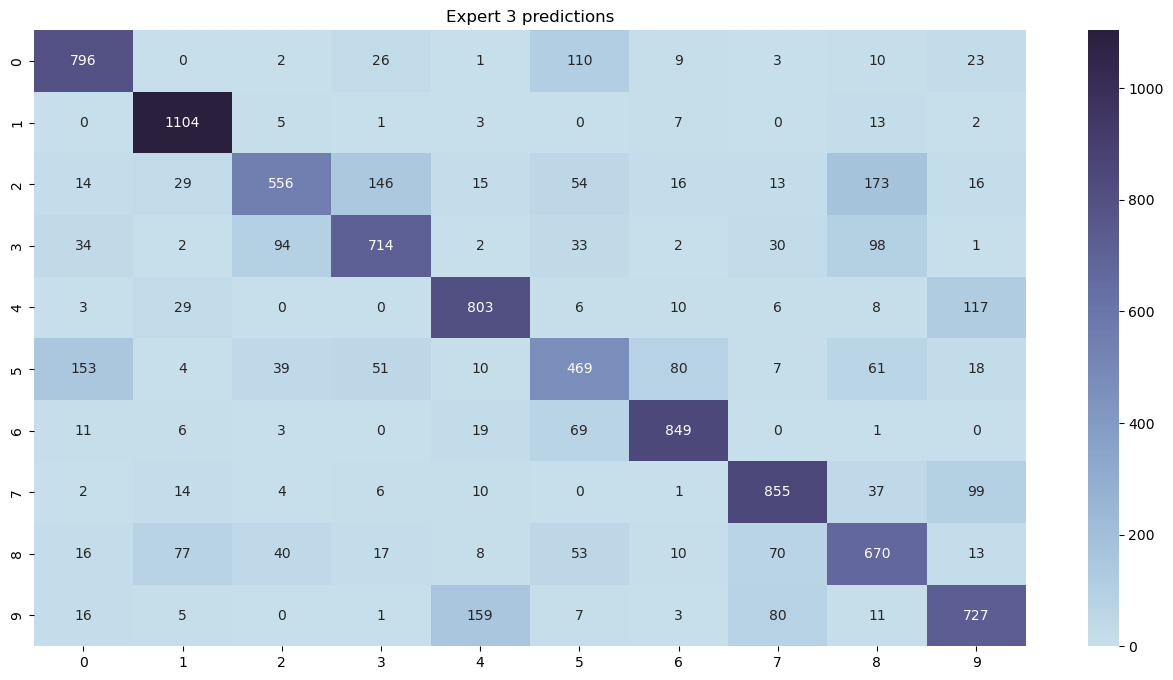

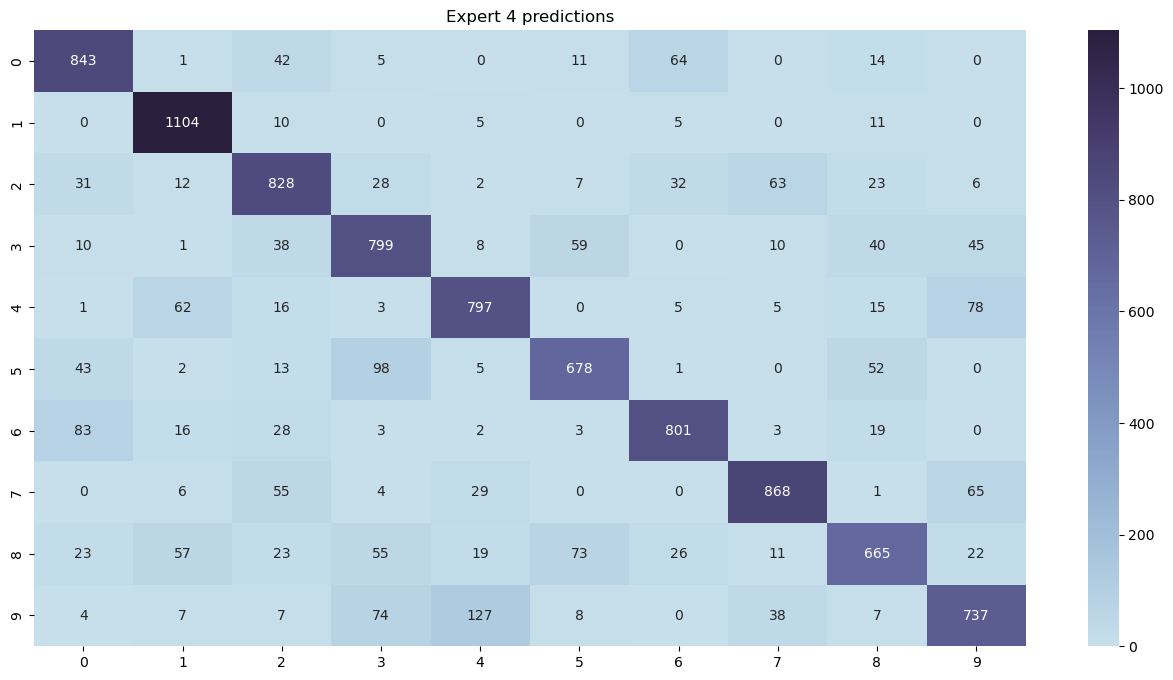

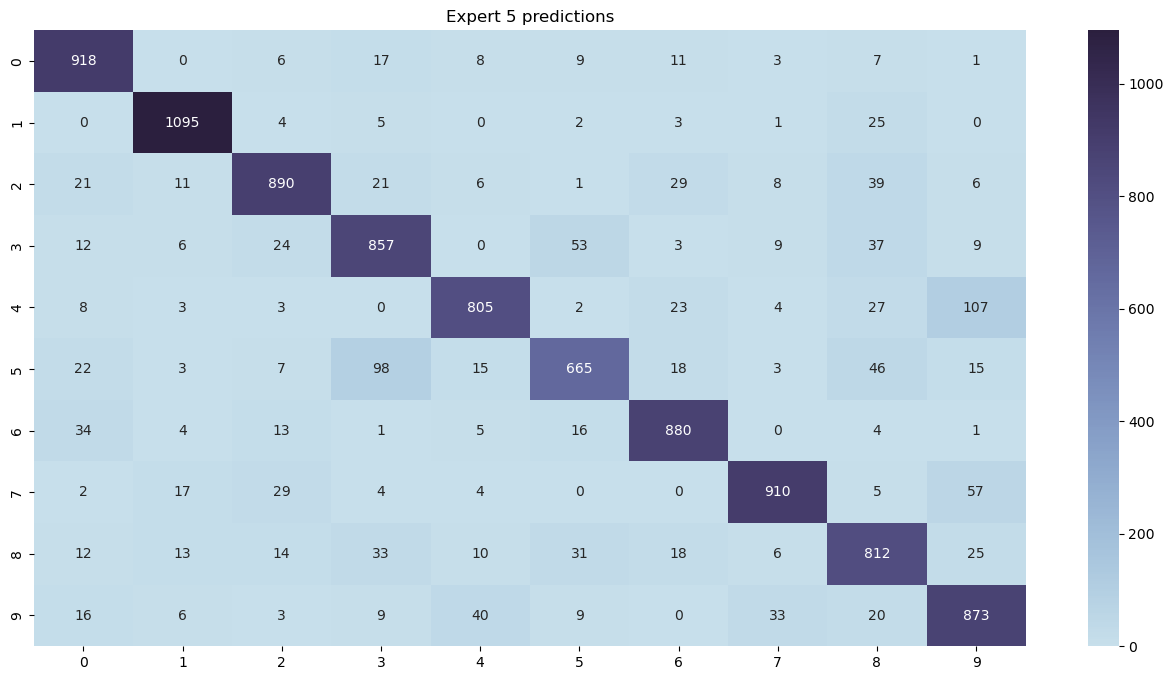

In [62]:
m = 'mnist_pretrained_splits_experts_stochastic'
model_type = 'moe_expert_stochastic_model'
show_results(m, model_type)

1
expert log loss:
 tensor([[-1.8613e-03, -1.1520e-02, -3.8513e-02, -9.6864e-02, -2.9476e-03],
        [-3.5066e-02, -2.8316e-01, -2.7004e-01, -1.1370e+00, -2.3833e-02],
        [-1.1209e-01, -2.0894e-02, -1.2234e-01, -1.3288e-01, -3.2435e-02],
        [-3.5853e-04, -5.6623e-04, -2.9276e-02, -5.8592e-02, -4.0196e-03],
        [-5.3698e-02, -6.5927e-02, -3.9900e-01, -1.7427e-01, -3.4322e-01]],
       device='cuda:0')
expert log loss predicted by gate:
 tensor([[ 0.0157, -0.0021, -0.0459, -0.0470, -0.0041],
        [-0.1069, -0.1537, -0.4244, -0.2916, -0.1455],
        [-0.0286, -0.0046, -0.1024, -0.1253, -0.0069],
        [-0.0029, -0.0029, -0.0112, -0.0772,  0.0008],
        [-0.0680, -0.0524, -0.2534, -0.1755, -0.1632]], device='cuda:0',
       grad_fn=<SliceBackward0>)


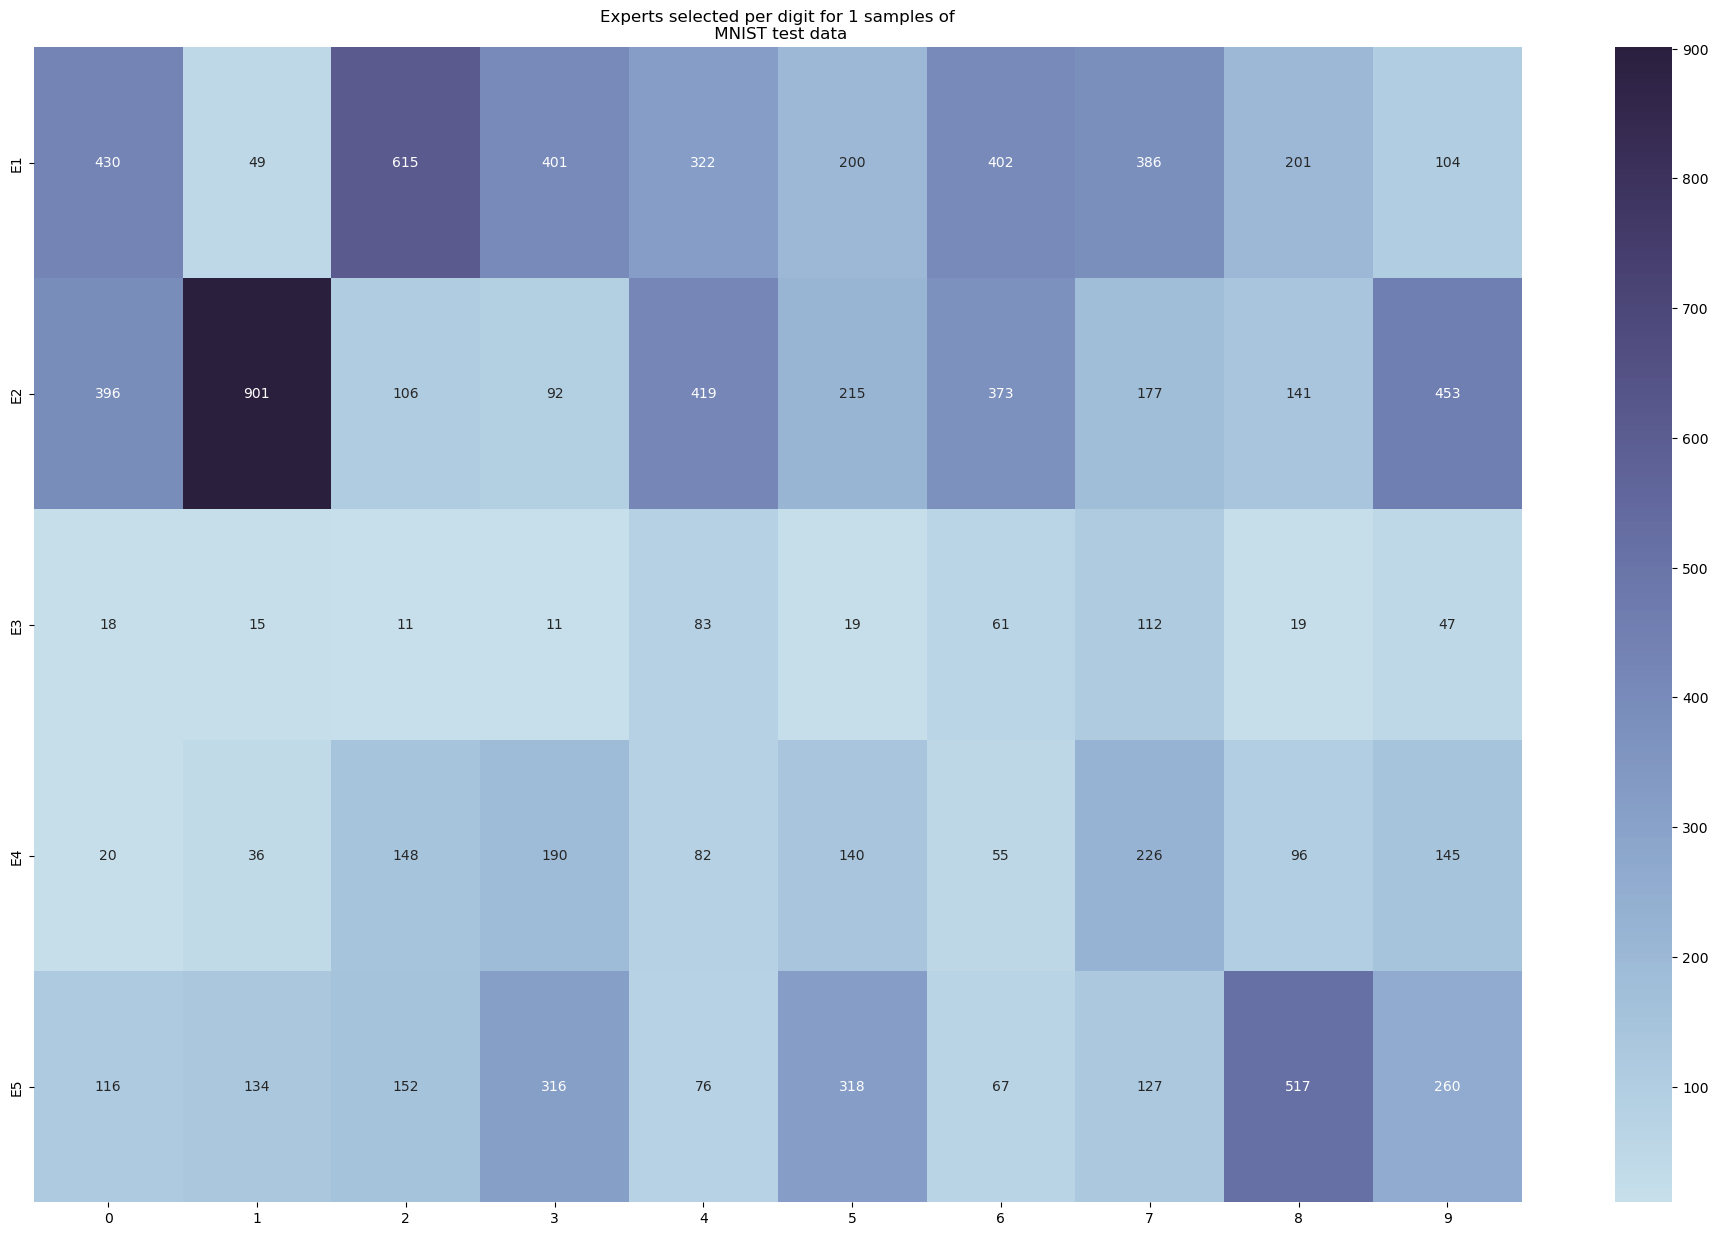

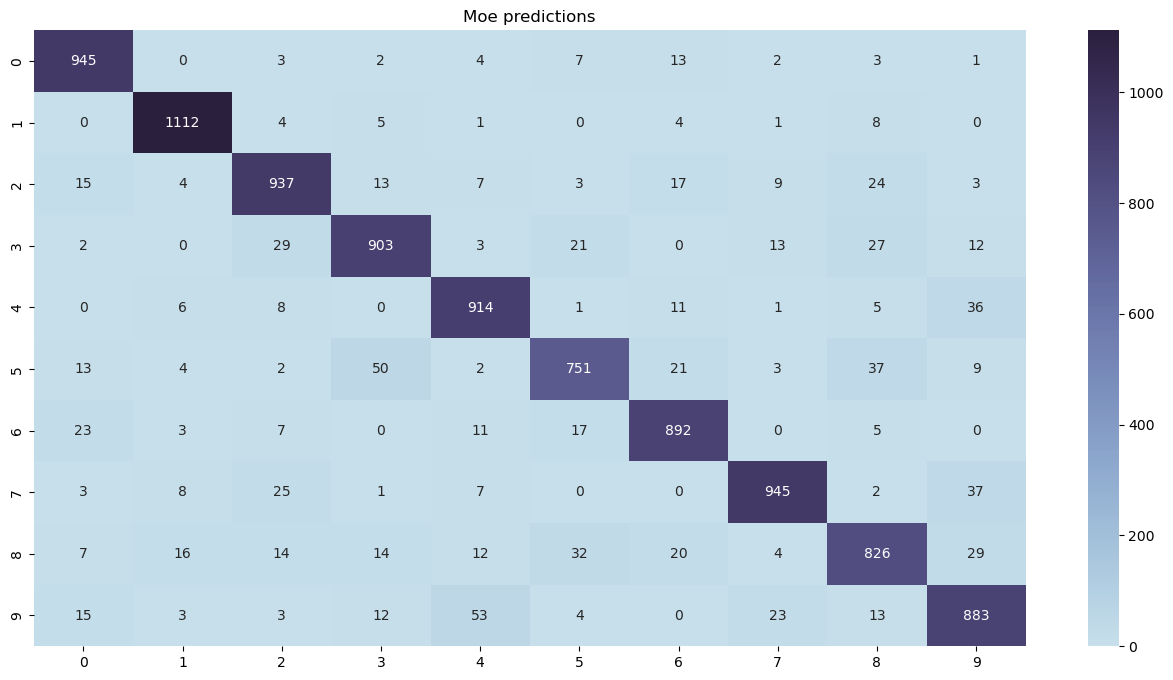

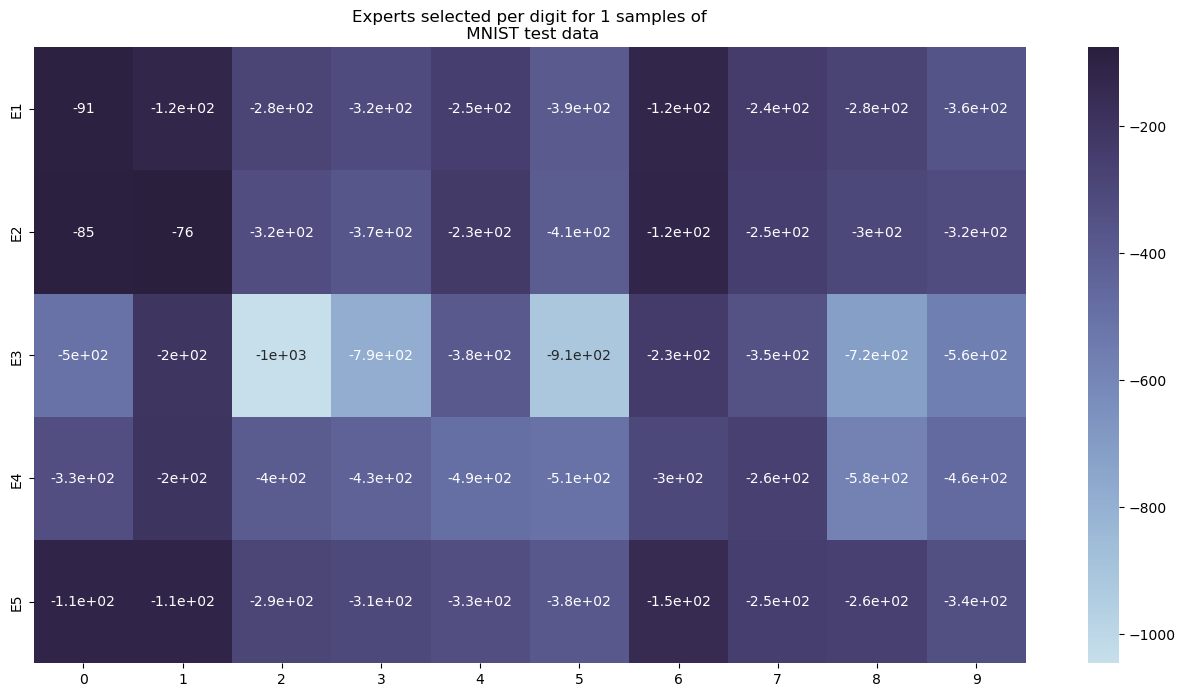

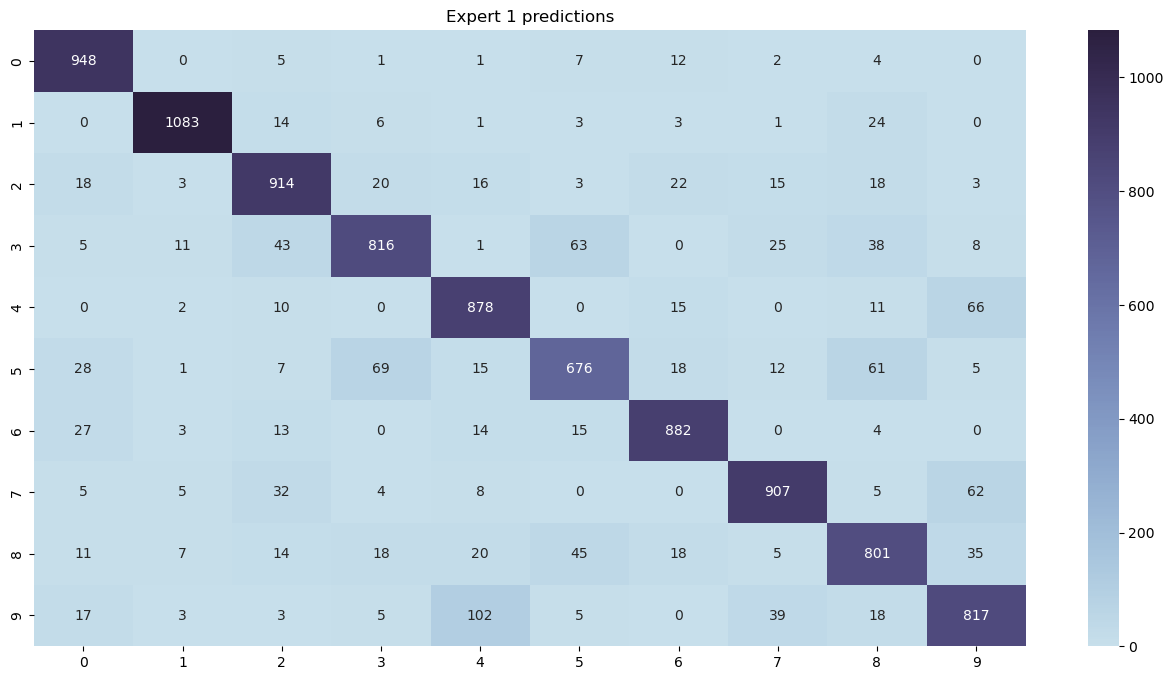

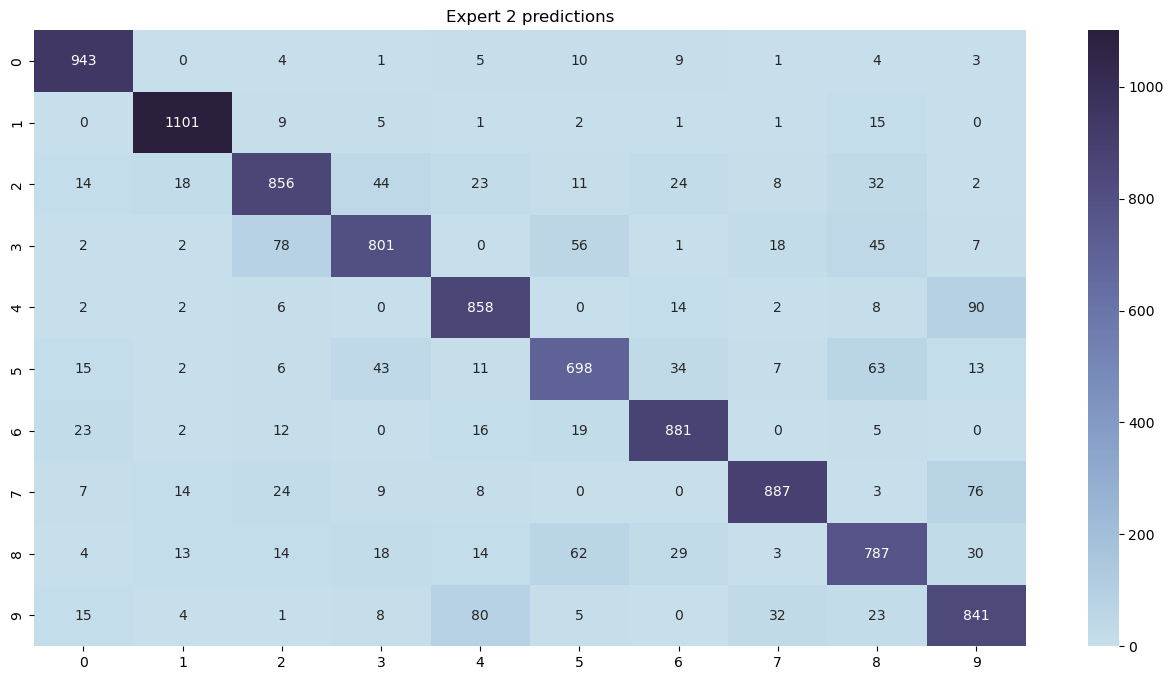

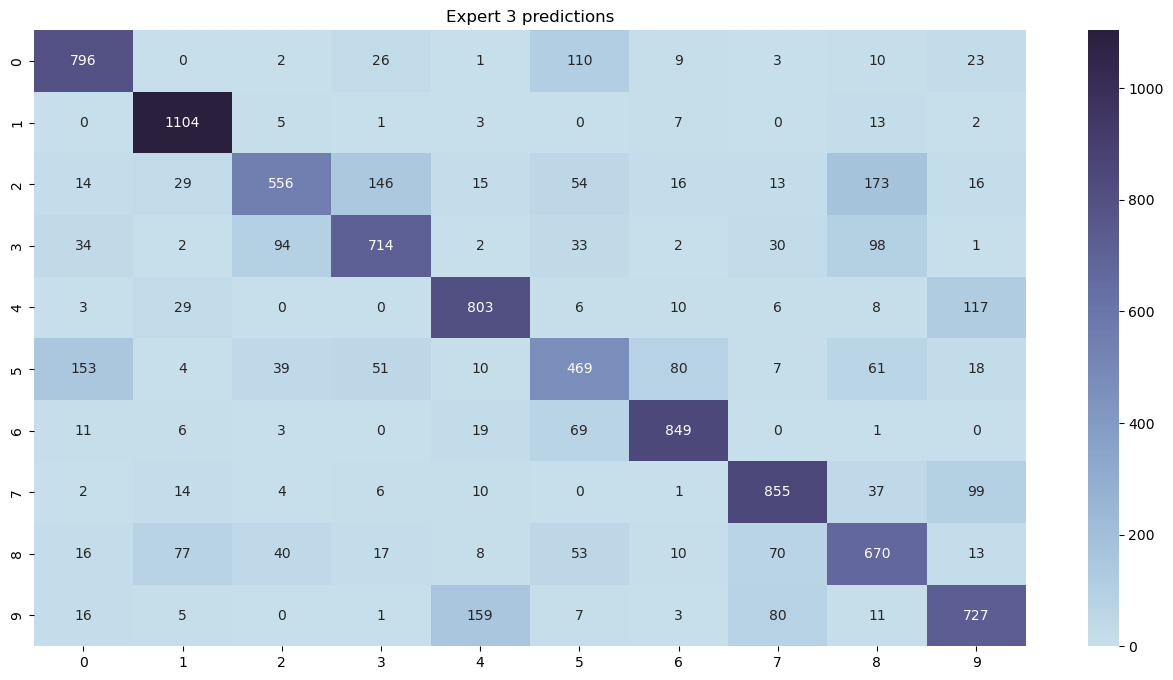

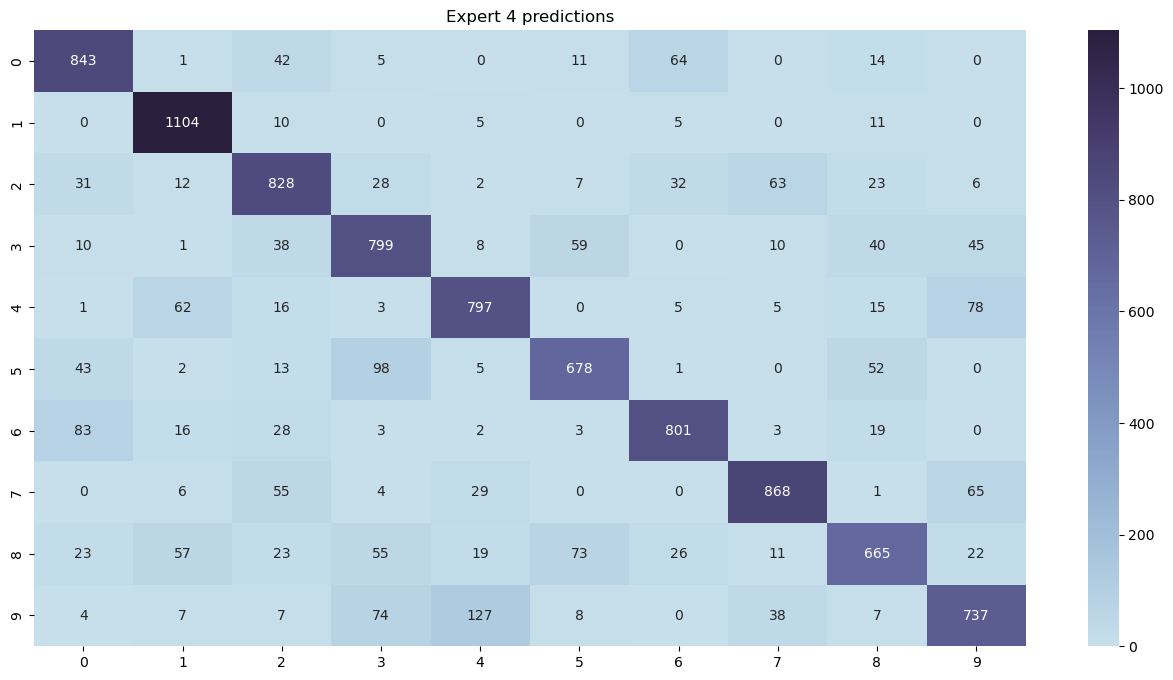

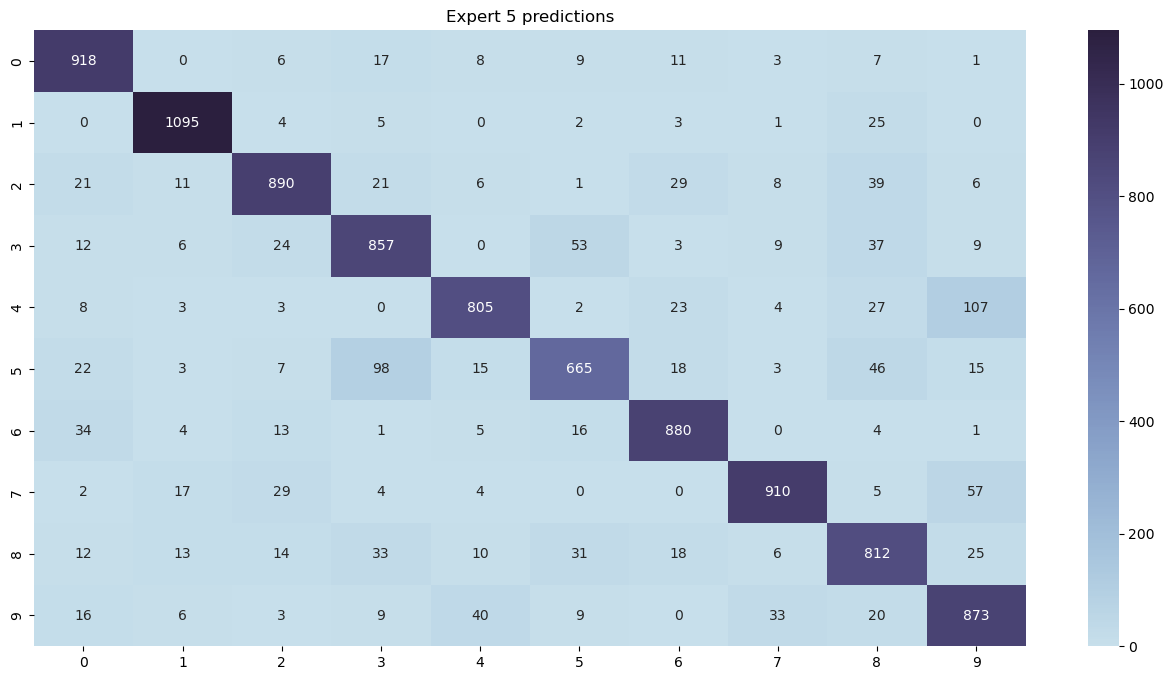

In [63]:
m = 'mnist_pretrained_splits_experts_expectation'
model_type = 'moe_expert_expectation_model'
show_results(m, model_type)

In [47]:
pre_trained_model_path = model_path

10000
mnist_without_reg_loss_gate_top_1_10_10_models.pt
Min Training Error 0.063
Mutual Information 1.126
Sample Entropy 0.328
Expert Usage 0.000
mnist_without_reg_loss_gate_top_1_10_10_models.pt


<Figure size 640x480 with 0 Axes>

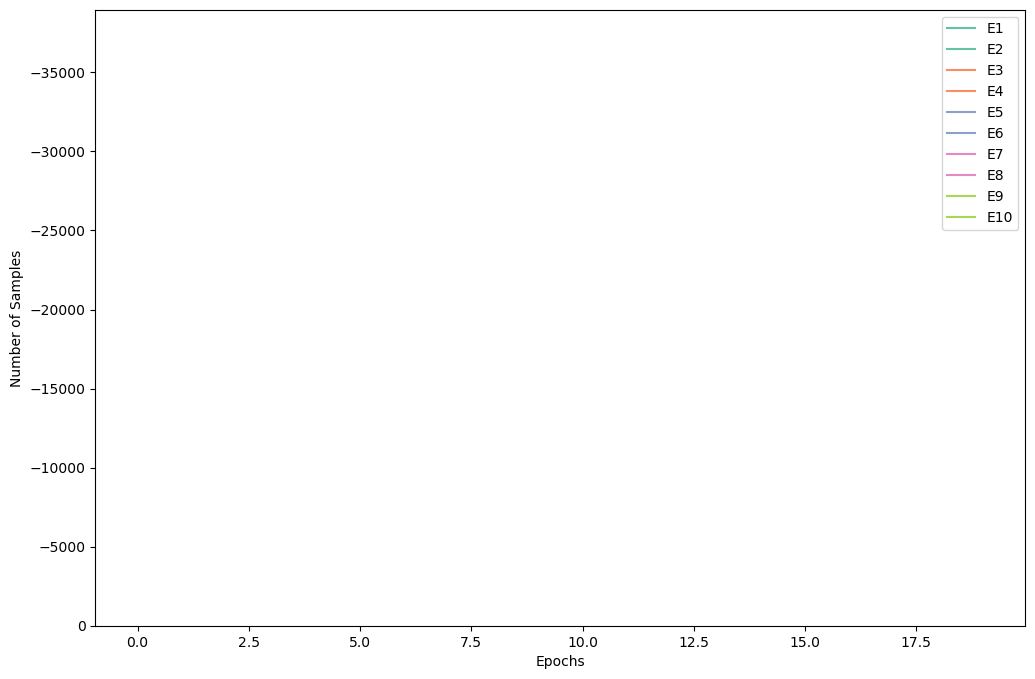

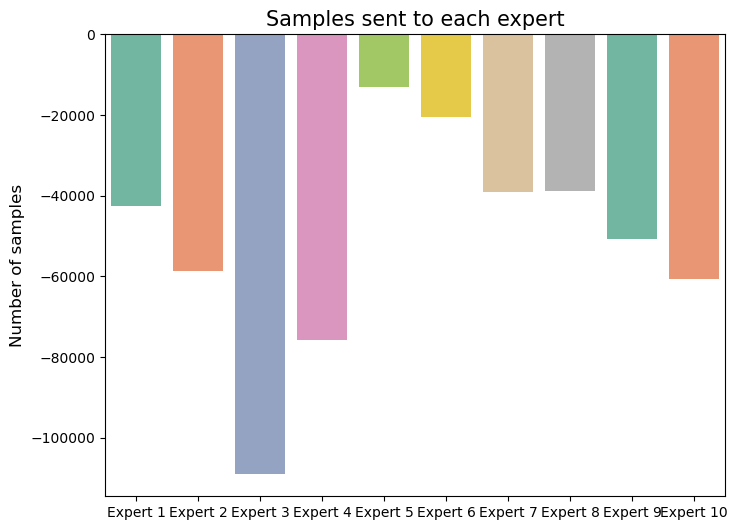

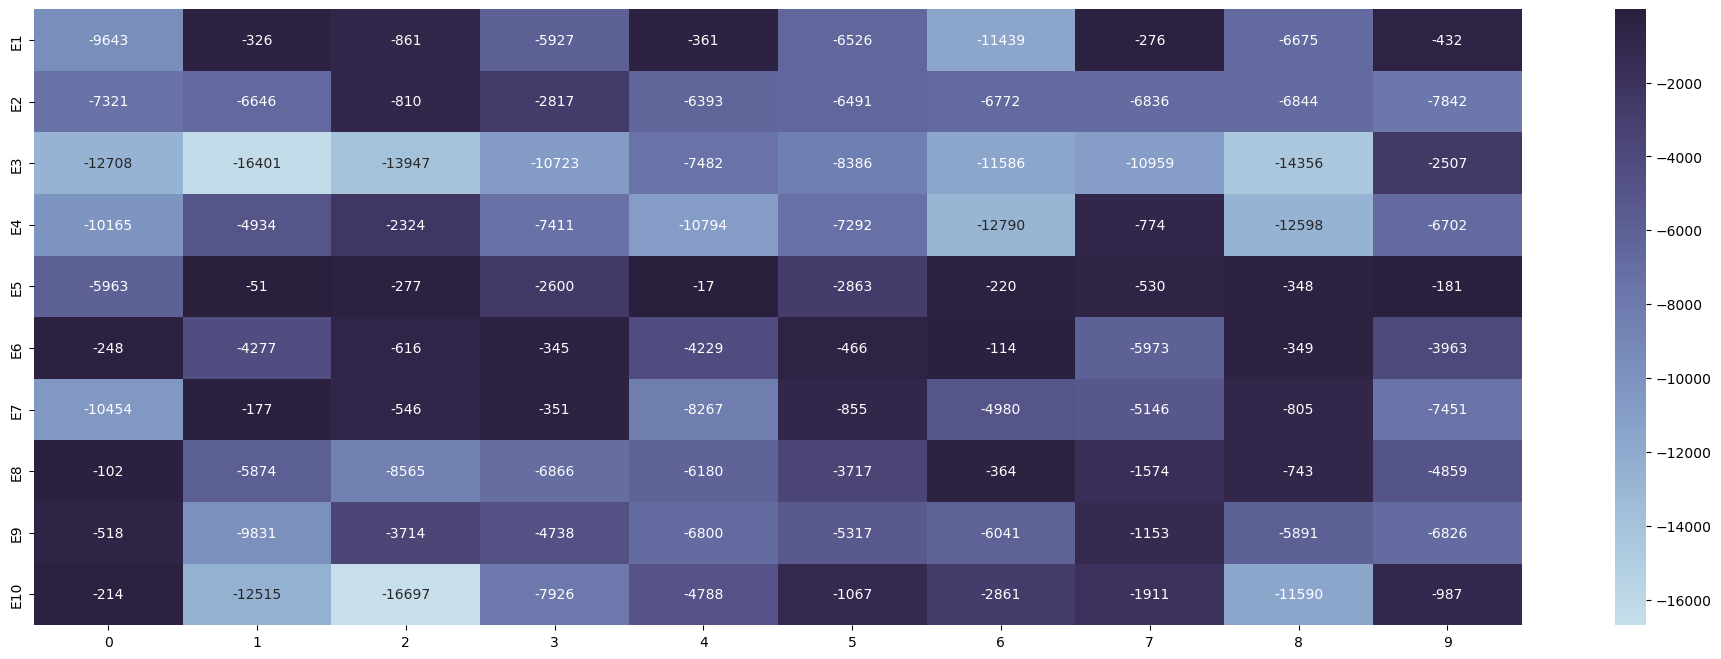


Experts used by the gate for classification of each class


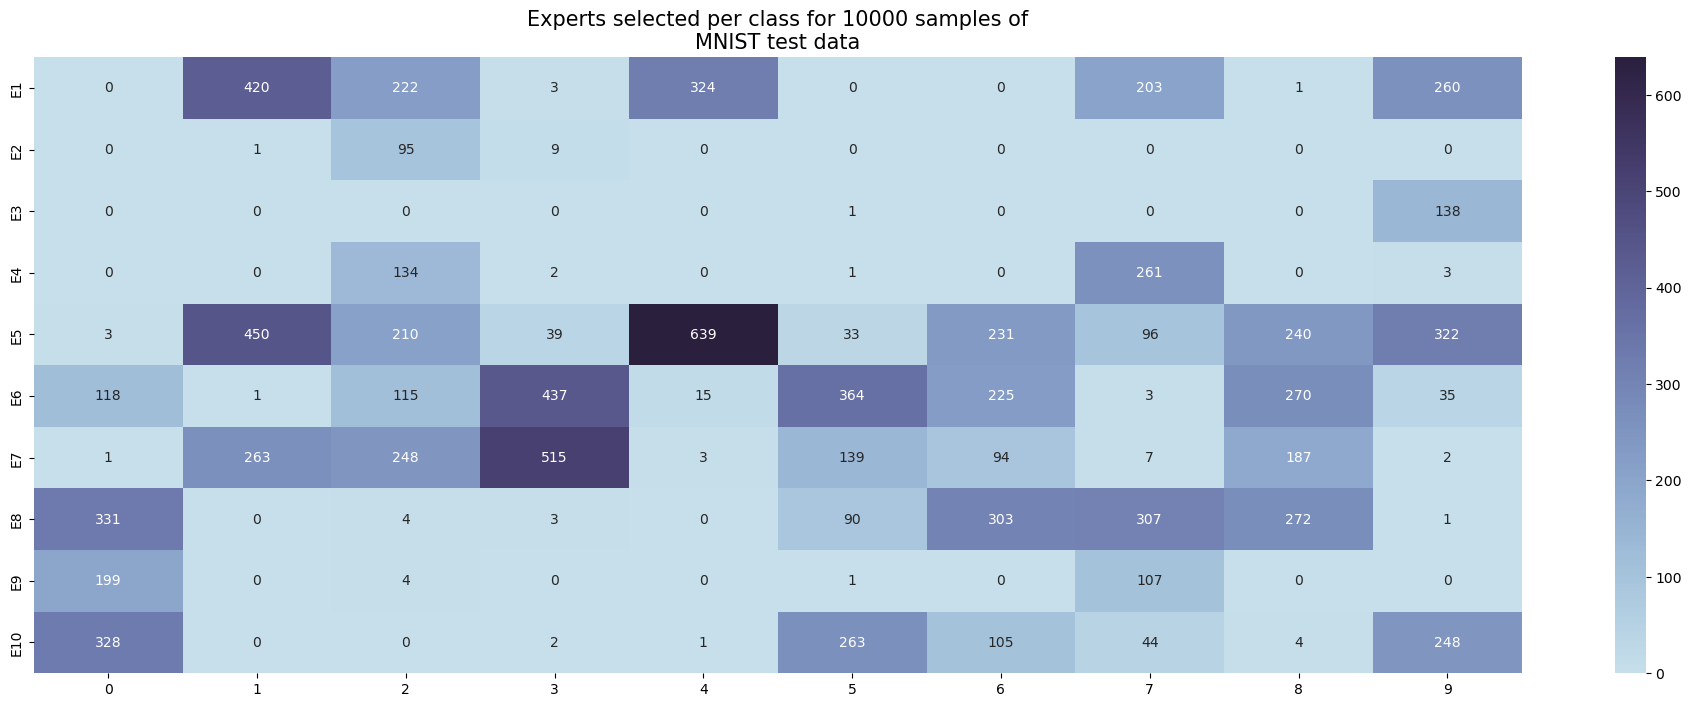

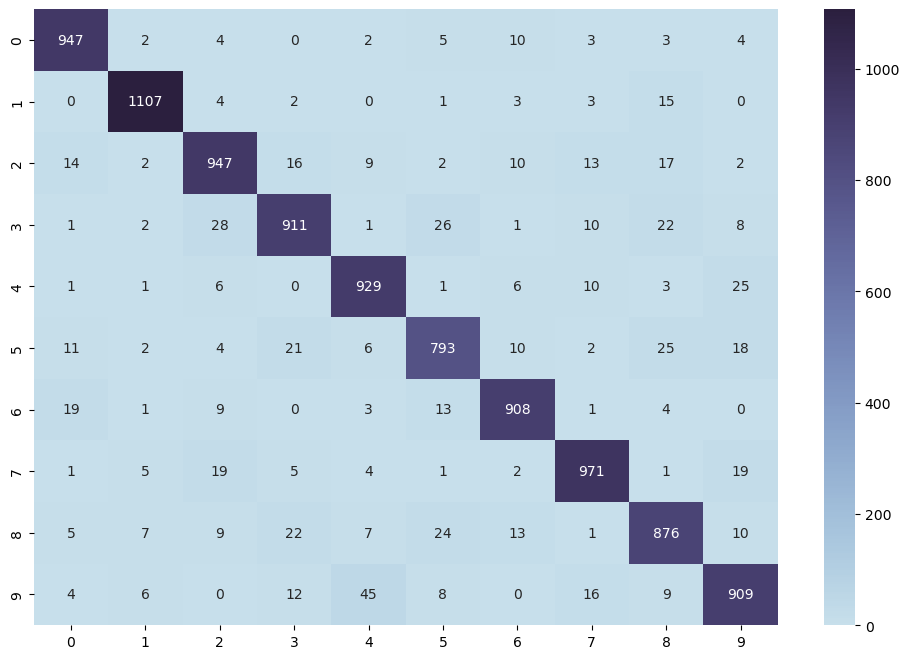

In [38]:
m = 'mnist_without_reg_loss_gate_top_1'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader
print(len(test_loader.dataset))
plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_without_reg_stochastic_10_5_models.pt
Min Training Error 0.090
Mutual Information 0.066
Sample Entropy 0.084
Expert Usage 0.000
mnist_without_reg_stochastic_10_5_models.pt


<Figure size 640x480 with 0 Axes>

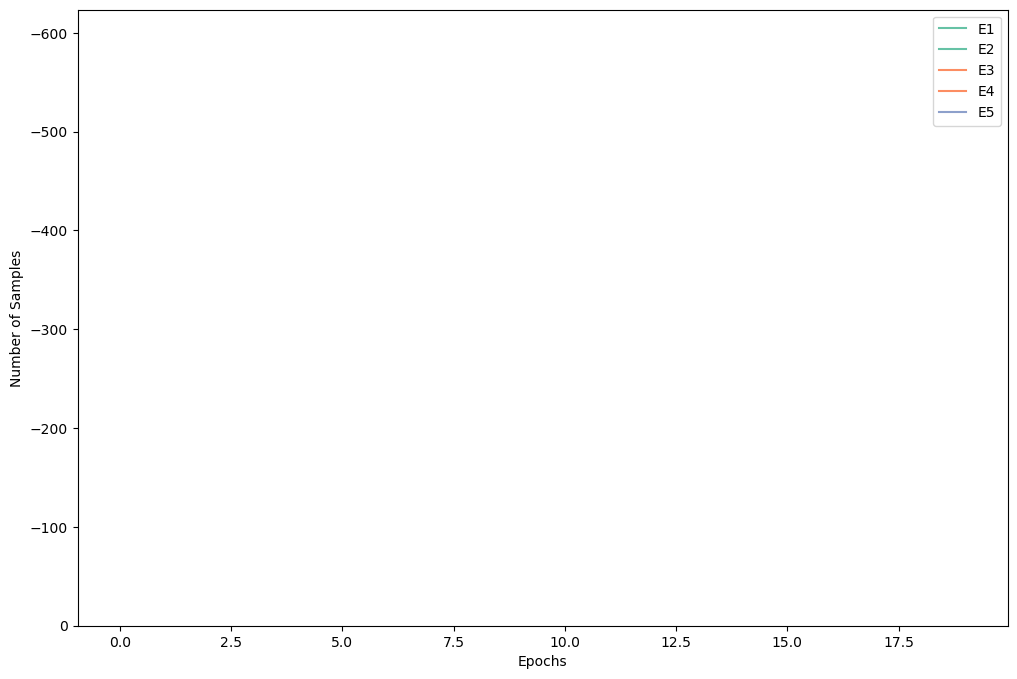

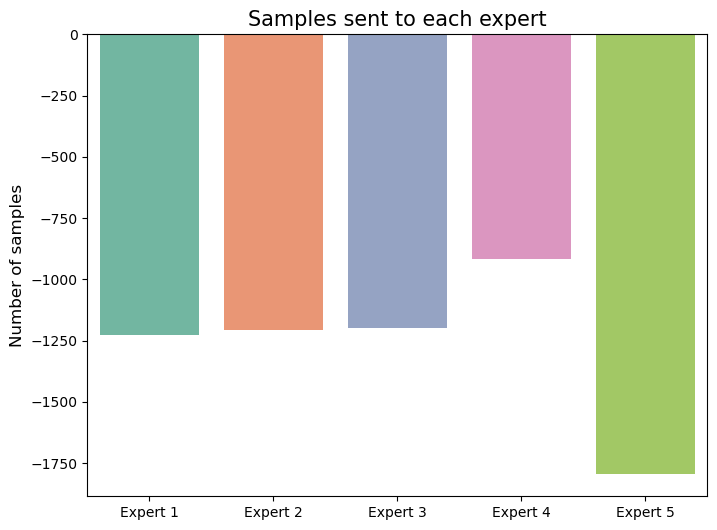

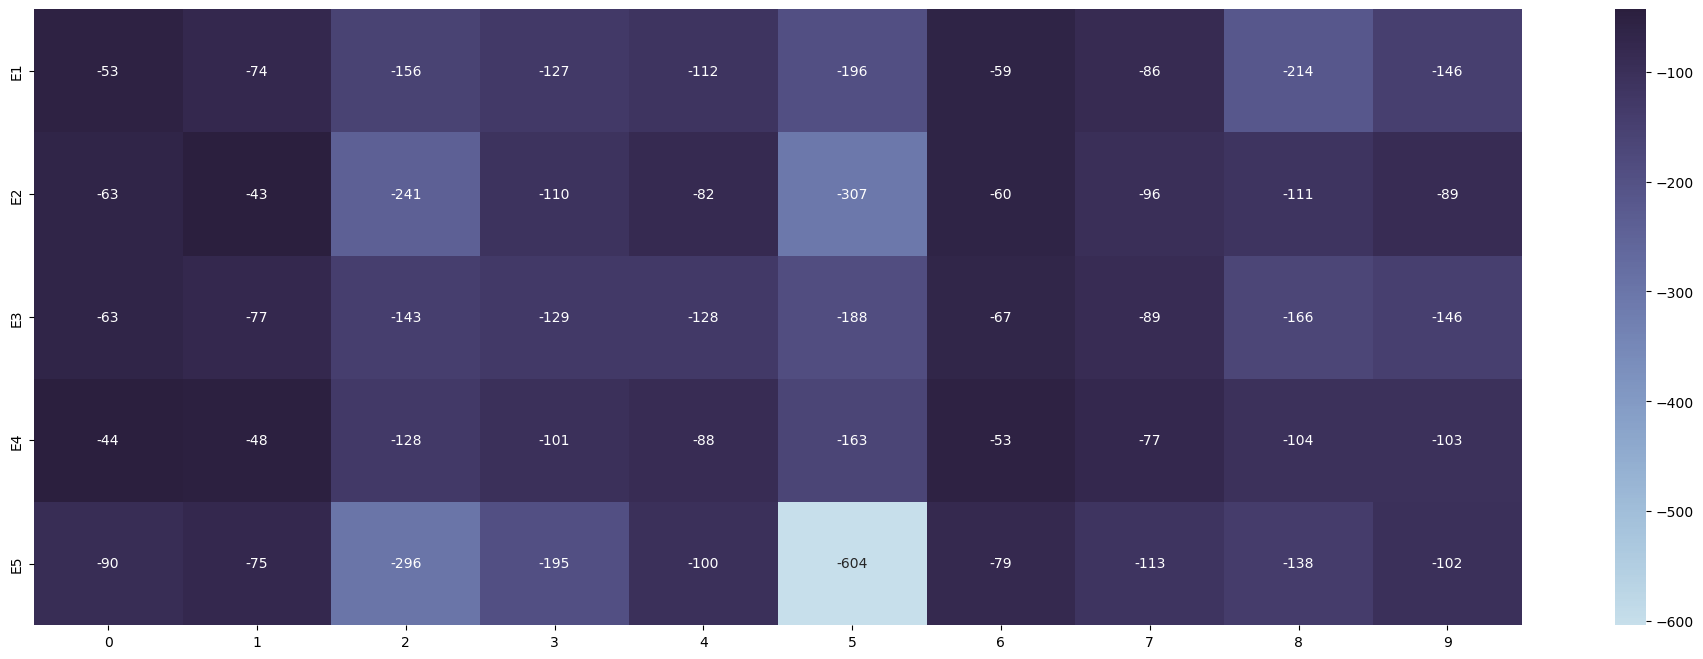


Experts used by the gate for classification of each class


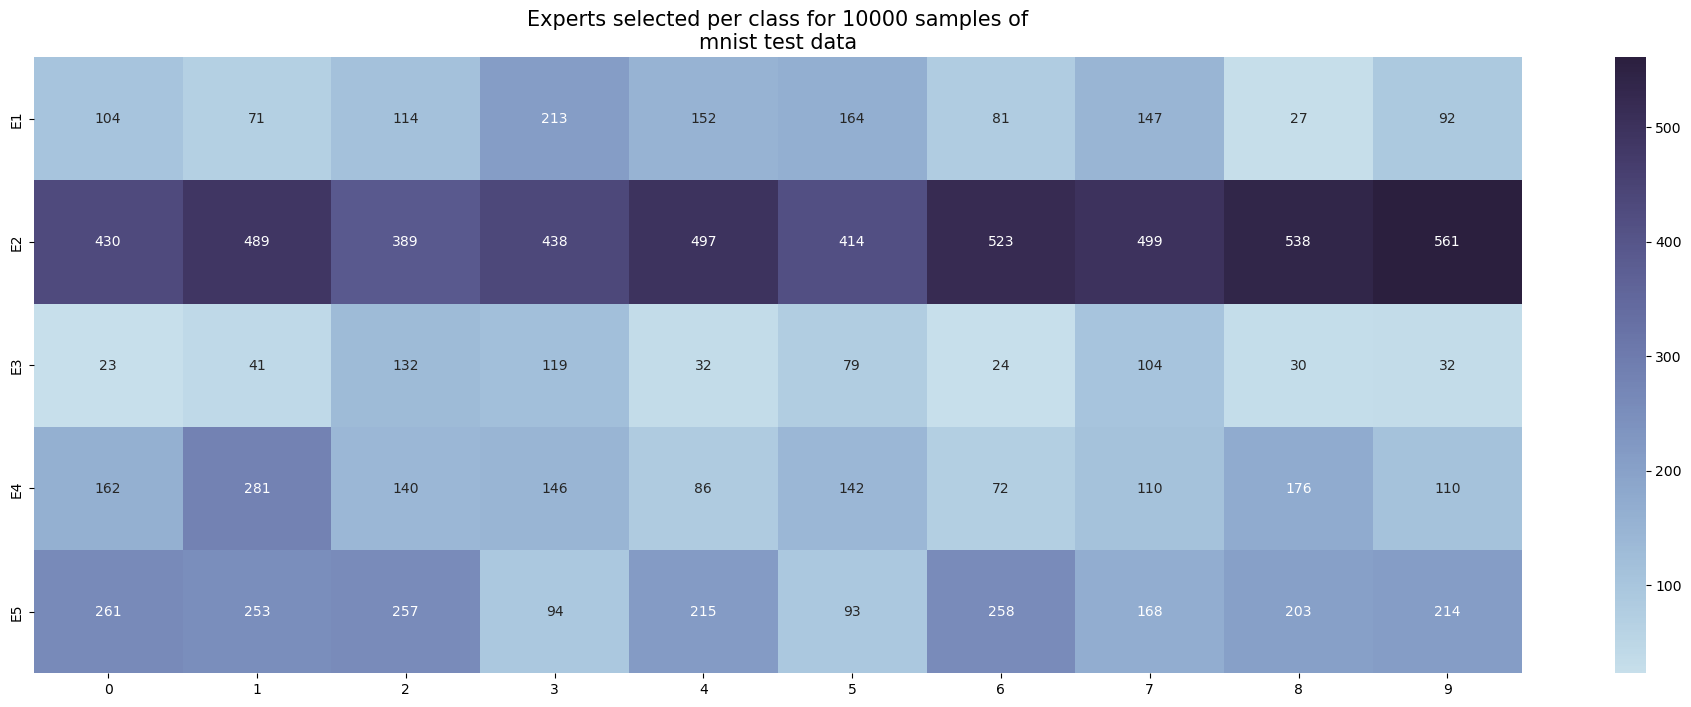

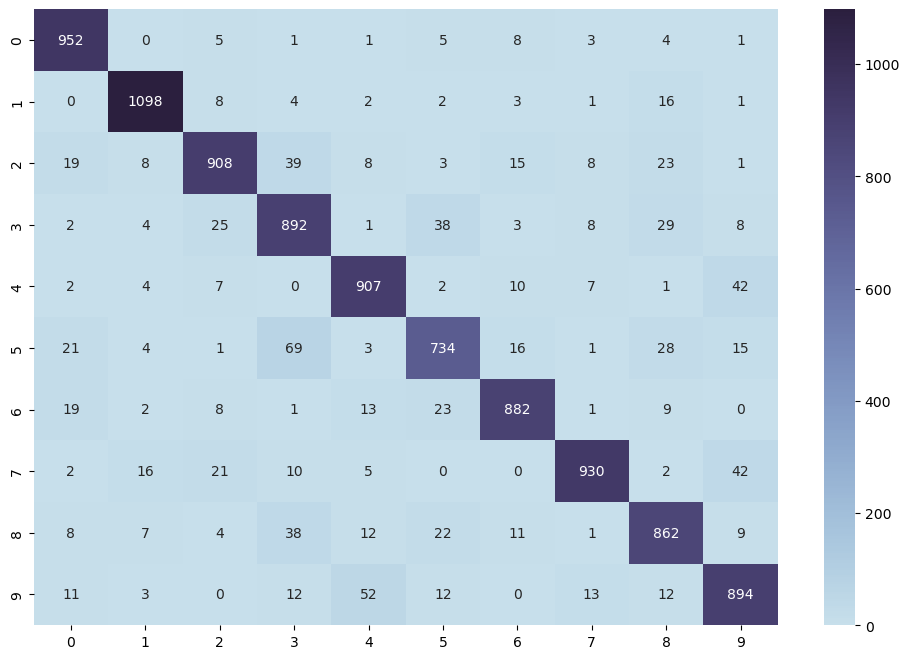

In [35]:
m = 'mnist_without_reg_stochastic'

total_experts = 5
classes = range(num_classes)
num_epochs = 20
temps=[[1]*num_epochs]
test_loader = testloader

w_importance_range = [0.0]

plot_expert_usage(m, test_loader, temps=temps,
                  w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=pre_trained_model_path, dataset='mnist', device=device)